In [4]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [357]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

In [358]:
# Load the data
house = pd.read_csv('/Users/KStamp/Desktop/GA/resource-datasets/project_3/housing.csv')

In [359]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [360]:
# no duplicate values
house.duplicated().sum()

0

In [361]:
# check through the dataframe for punctuation that isn't na values
import string
punc = string.punctuation

for column in house:
    for item in column:
        if item in punc:
            print(house[column])

In [362]:
# remove any houses that are not residential from the dataset.
house.MSZoning.unique()
# A, C and I - remove 

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [363]:
house_res = house[house.MSZoning != 'C (all)']
house_res.MSZoning.unique()

array(['RL', 'RM', 'FV', 'RH'], dtype=object)

In [364]:
# there are large amounts of NaN values - however in the data dictionary we can see that they actually mean the
# feature is just non-applicable or not within this house.
house_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1191 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   Street         1450 non-null   object 
 6   Alley          89 non-null     object 
 7   LotShape       1450 non-null   object 
 8   LandContour    1450 non-null   object 
 9   Utilities      1450 non-null   object 
 10  LotConfig      1450 non-null   object 
 11  LandSlope      1450 non-null   object 
 12  Neighborhood   1450 non-null   object 
 13  Condition1     1450 non-null   object 
 14  Condition2     1450 non-null   object 
 15  BldgType       1450 non-null   object 
 16  HouseStyle     1450 non-null   object 
 17  OverallQual    1450 non-null   int64  
 18  OverallC

In [365]:
house_res.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1361
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [366]:
# 17 columns have NA values - from data dictionary we need to change 15 with the NaN values to 'No xxx'
house_res.PoolQC.unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [367]:
house_res.fillna( {
                    'BsmtQual': 'No_Basement',
                    'BsmtCond': 'No_Basement',
                    'BsmtExposure': 'No_Basement',
                    'BsmtFinType1': 'No_Basement',
                    'BsmtFinType2': 'No_Basement',
                    'BsmtFinType2': 'No_Basement',
                    'LotFrontage': 0,
                    'Alley': 'No_Alley_Access',
                    'FireplaceQu': 'No_Fireplace',
                    'GarageType': 'No_Garage',
                    'GarageFinish': 'No_Garage',
                    'GarageQual': 'No_Garage',
                    'GarageCond': 'No_Garage',
                    'PoolQC': 'No_Pool',
                    'Fence': 'No_Fence',
                    'MiscFeature': 'No_Extra_Features',
                                                        } , inplace=True)

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [368]:
# check values have changed
house_res.BsmtFinType2.unique()

array(['Unf', 'BLQ', 'No_Basement', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
      dtype=object)

In [369]:
# check values have changed
house_res.MiscFeature.unique()

array(['No_Extra_Features', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [370]:
# Electrical and GarageYrBuilt have NAs not described in dictionary
pd.set_option('display.max_columns', 500)
house_res[(house_res['Electrical'].isnull())]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street            Alley  \
1379  1380          80       RL         73.0     9735   Pave  No_Alley_Access   

     LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
1379      Reg         Lvl    AllPub    Inside       Gtl       Timber   

     Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
1379       Norm       Norm     1Fam       SLvl            5            5   

      YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
1379       2006          2007     Gable  CompShg     VinylSd     VinylSd   

     MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
1379       None         0.0        TA        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
1379           No          Unf           0          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
1379        384          384    GasA        Gd          Y        NaN   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1379       754       640             0       1394             0             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1379         2         1             3             1          Gd   

      TotRmsAbvGrd Functional  Fireplaces   FireplaceQu GarageType  \
1379             7        Typ           0  No_Fireplace    BuiltIn   

      GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond  \
1379       2007.0          Fin           2         400         TA         TA   

     PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
1379          Y         100            0              0          0   

      ScreenPorch  PoolArea   PoolQC     Fence        MiscFeature  MiscVal  \
1379            0         0  No_Pool  No_Fence  No_Extra_Features        0   

      MoSold  YrSold SaleType SaleCondition  SalePrice  
1379       5    2008       WD        Normal     167500

In [371]:
house_res.Electrical.describe()

count      1449
unique        5
top       SBrkr
freq       1328
Name: Electrical, dtype: object

In [372]:
# replace the nas with most common value 
house_res.fillna( {'Electrical': 'SBrkr'} , inplace=True)

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [373]:
# check no year for garage built vs having no garage as defined above (79 rows match)
house_res[(house_res['GarageYrBlt'].isnull()) & (house_res['GarageType'] == 'No_Garage')].head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street            Alley  \
39   40          90       RL         65.0     6040   Pave  No_Alley_Access   
48   49         190       RM         33.0     4456   Pave  No_Alley_Access   
78   79          90       RL         72.0    10778   Pave  No_Alley_Access   
89   90          20       RL         60.0     8070   Pave  No_Alley_Access   
99  100          20       RL         77.0     9320   Pave  No_Alley_Access   

   LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
39      Reg         Lvl    AllPub    Inside       Gtl      Edwards       Norm   
48      Reg         Lvl    AllPub    Inside       Gtl      OldTown       Norm   
78      Reg         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
89      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
99      IR1         Lvl    AllPub    Inside       Gtl        NAmes       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
39       Norm   Duplex     1Story            4            5       1955   
48       Norm   2fmCon     2Story            4            5       1920   
78       Norm   Duplex     1Story            4            5       1968   
89       Norm     1Fam     1Story            4            5       1994   
99       Norm     1Fam     1Story            4            5       1959   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
39          1955     Gable  CompShg     AsbShng     Plywood       None   
48          2008     Gable  CompShg     MetalSd     MetalSd       None   
78          1968       Hip  CompShg     HdBoard     HdBoard       None   
89          1995     Gable  CompShg     VinylSd     VinylSd       None   
99          1959     Gable  CompShg     Plywood     Plywood       None   

    MasVnrArea ExterQual ExterCond Foundation     BsmtQual     BsmtCond  \
39         0.0        TA        TA      PConc  No_Basement  No_Basement   
48         0.0        TA        TA     BrkTil           TA           TA   
78         0.0        TA        TA     CBlock           TA           TA   
89         0.0        TA        TA      PConc           Gd           TA   
99         0.0        TA        TA     CBlock           TA           TA   

   BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
39  No_Basement  No_Basement           0  No_Basement           0          0   
48           No          Unf           0          Unf           0        736   
78           No          Unf           0          Unf           0       1768   
89           No          GLQ         588          Unf           0        402   
99           No          ALQ         569          Unf           0        381   

    TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  \
39            0    GasA        TA          N      FuseP      1152         0   
48          736    GasA        Gd          Y      SBrkr       736       716   
78         1768    GasA        TA          N      SBrkr      1768         0   
89          990    GasA        Ex          Y      SBrkr       990         0   
99          950    GasA        Fa          Y      SBrkr      1225         0   

    LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
39             0       1152             0             0         2         0   
48             0       1452             0             0         2         0   
78             0       1768             0             0         2         0   
89             0        990             1             0         1         0   
99             0       1225             1             0         1         1   

    BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  \
39             2             2          Fa             6        Typ   
48             2             3          TA             8        Typ   
78             4             2          TA             8        

In [374]:
# replace the nas with 0
house_res.fillna( {'GarageYrBlt': 0} , inplace=True)

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [375]:
# I now understand that if I had dropped the renovatable columns first I would have had less work with the NAs

In [377]:
house_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1450 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   Street         1450 non-null   object 
 6   Alley          1450 non-null   object 
 7   LotShape       1450 non-null   object 
 8   LandContour    1450 non-null   object 
 9   Utilities      1450 non-null   object 
 10  LotConfig      1450 non-null   object 
 11  LandSlope      1450 non-null   object 
 12  Neighborhood   1450 non-null   object 
 13  Condition1     1450 non-null   object 
 14  Condition2     1450 non-null   object 
 15  BldgType       1450 non-null   object 
 16  HouseStyle     1450 non-null   object 
 17  OverallQual    1450 non-null   int64  
 18  OverallC

In [378]:
# dropping columns of renovatable features (qual/cond features)
house_res = house_res.drop(house_res.iloc[:,np.r_[17:19, 21:29, 30, 31, 33:38, 39:43, 45, 53, 56:58, 60, 63:65, 66:76]], axis=1)

In [379]:
house_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1450 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   Street         1450 non-null   object 
 6   Alley          1450 non-null   object 
 7   LotShape       1450 non-null   object 
 8   LandContour    1450 non-null   object 
 9   Utilities      1450 non-null   object 
 10  LotConfig      1450 non-null   object 
 11  LandSlope      1450 non-null   object 
 12  Neighborhood   1450 non-null   object 
 13  Condition1     1450 non-null   object 
 14  Condition2     1450 non-null   object 
 15  BldgType       1450 non-null   object 
 16  HouseStyle     1450 non-null   object 
 17  YearBuilt      1450 non-null   int64  
 18  YearRemo

In [380]:
# dropping columns of renovatable features that aren't graded 
house_res = house_res.drop(house_res.iloc[:, [32, 37, 9]], axis=1)

In [381]:
# still lots of features so I am combining some columns to make it more readable
house_res['TotalBath'] = house_res['BsmtFullBath']/2 + house_res['BsmtHalfBath'] + house_res['FullBath']/2 + house_res['HalfBath']
house_res['TotalSqft'] = house_res['GrLivArea'] + house_res['TotalBsmtSF']

In [382]:
house_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 42 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1450 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   Street         1450 non-null   object 
 6   Alley          1450 non-null   object 
 7   LotShape       1450 non-null   object 
 8   LandContour    1450 non-null   object 
 9   LotConfig      1450 non-null   object 
 10  LandSlope      1450 non-null   object 
 11  Neighborhood   1450 non-null   object 
 12  Condition1     1450 non-null   object 
 13  Condition2     1450 non-null   object 
 14  BldgType       1450 non-null   object 
 15  HouseStyle     1450 non-null   object 
 16  YearBuilt      1450 non-null   int64  
 17  YearRemodAdd   1450 non-null   int64  
 18  Foundati

In [383]:
# remove newly duplicated columns
house_res = house_res.drop(house_res.iloc[:, [20, 21, 22, 23, 24, 25, 26, 27]], axis=1)

In [384]:
# index and id are set at different starter values - change index to datasets Id
house_res.index = house_res['Id']

In [385]:
# drop Id column
house_res.drop('Id', axis=1, inplace=True)

In [386]:
house_res.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
       'YearRemodAdd', 'Foundation', 'BsmtExposure', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'TotalBath', 'TotalSqft'],
      dtype='object')

In [387]:
# dummyfing categorical variables
house_dum = pd.get_dummies(house_res)
house_dum.head()

MSSubClass  LotFrontage  LotArea  YearBuilt  YearRemodAdd  BedroomAbvGr  \
Id                                                                            
1           60         65.0     8450       2003          2003             3   
2           20         80.0     9600       1976          1976             3   
3           60         68.0    11250       2001          2002             3   
4           70         60.0     9550       1915          1970             3   
5           60         84.0    14260       2000          2000             4   

    KitchenAbvGr  TotRmsAbvGrd  GarageYrBlt  GarageCars  GarageArea  MoSold  \
Id                                                                            
1              1             8       2003.0           2         548       2   
2              1             6       1976.0           2         460       5   
3              1             6       2001.0           2         608       9   
4              1             7       1998.0           3         642       2   
5              1             9       2000.0           3         836      12   

    YrSold  SalePrice  TotalBath  TotalSqft  MSZoning_FV  MSZoning_RH  \
Id                                                                      
1     2008     208500        2.5       2566            0            0   
2     2007     181500        2.0       2524            0            0   
3     2008     223500        2.5       2706            0            0   
4     2006     140000        1.0       2473            0            0   
5     2008     250000        2.5       3343            0            0   

    MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  \
Id                                                                   
1             1            0            0            1           0   
2             1            0            0            1           0   
3             1            0            0            1           0   
4             1            0            0            1           0   
5             1            0            0            1           0   

    Alley_No_Alley_Access  Alley_Pave  LotShape_IR1  LotShape_IR2  \
Id                                                                  
1                       1           0             0             0   
2                       1           0             0             0   
3                       1           0             1             0   
4                       1           0             1             0   
5                       1           0             1             0   

    LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
Id                                                                 
1              0             1                0                0   
2              0             1                0                0   
3              0             0                0                0   
4              0             0                0                0   
5              0             0                0                0   

    LandContour_Low  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac  \
Id                                                                          
1                 0                1                 0                  0   
2                 0                1                 0                  0   
3                 0                1                 0                  0   
4                 0                1                 1                  0   
5                 0                1                 0                  0   

    LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  \
Id                                                                  
1               0              0                 1              1   
2               1              0                 0              1   
3               0              0                 1              1   
4               0              0               

In [388]:
# MSSubClass is actually categorical - it wasn't dummified because it has numbers (changing to categories)
house_dum = pd.get_dummies(house_dum, columns=['MSSubClass'])
house_dum.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  BedroomAbvGr  KitchenAbvGr  \
Id                                                                              
1          65.0     8450       2003          2003             3             1   
2          80.0     9600       1976          1976             3             1   
3          68.0    11250       2001          2002             3             1   
4          60.0     9550       1915          1970             3             1   
5          84.0    14260       2000          2000             4             1   

    TotRmsAbvGrd  GarageYrBlt  GarageCars  GarageArea  MoSold  YrSold  \
Id                                                                      
1              8       2003.0           2         548       2    2008   
2              6       1976.0           2         460       5    2007   
3              6       2001.0           2         608       9    2008   
4              7       1998.0           3         642       2    2006   
5              9       2000.0           3         836      12    2008   

    SalePrice  TotalBath  TotalSqft  MSZoning_FV  MSZoning_RH  MSZoning_RL  \
Id                                                                           
1      208500        2.5       2566            0            0            1   
2      181500        2.0       2524            0            0            1   
3      223500        2.5       2706            0            0            1   
4      140000        1.0       2473            0            0            1   
5      250000        2.5       3343            0            0            1   

    MSZoning_RM  Street_Grvl  Street_Pave  Alley_Grvl  Alley_No_Alley_Access  \
Id                                                                             
1             0            0            1           0                      1   
2             0            0            1           0                      1   
3             0            0            1           0                      1   
4             0            0            1           0                      1   
5             0            0            1           0                      1   

    Alley_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  \
Id                                                                       
1            0             0             0             0             1   
2            0             0             0             0             1   
3            0             1             0             0             0   
4            0             1             0             0             0   
5            0             1             0             0             0   

    LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  \
Id                                                                       
1                 0                0                0                1   
2                 0                0                0                1   
3                 0                0                0                1   
4                 0                0                0                1   
5                 0                0                0                1   

    LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
Id                                                                      
1                  0                  0              0              0   
2                  0                  0              1              0   
3                  0                  0              0              0   
4                  1                  0              0              0   
5                  0                  0              1              0   

    LotConfig_Inside  LandSlope_Gtl  LandSlope_Mod  LandSlope_Sev  \
Id                                                                  
1                  1              1              0              0   
2                  0              1              0         

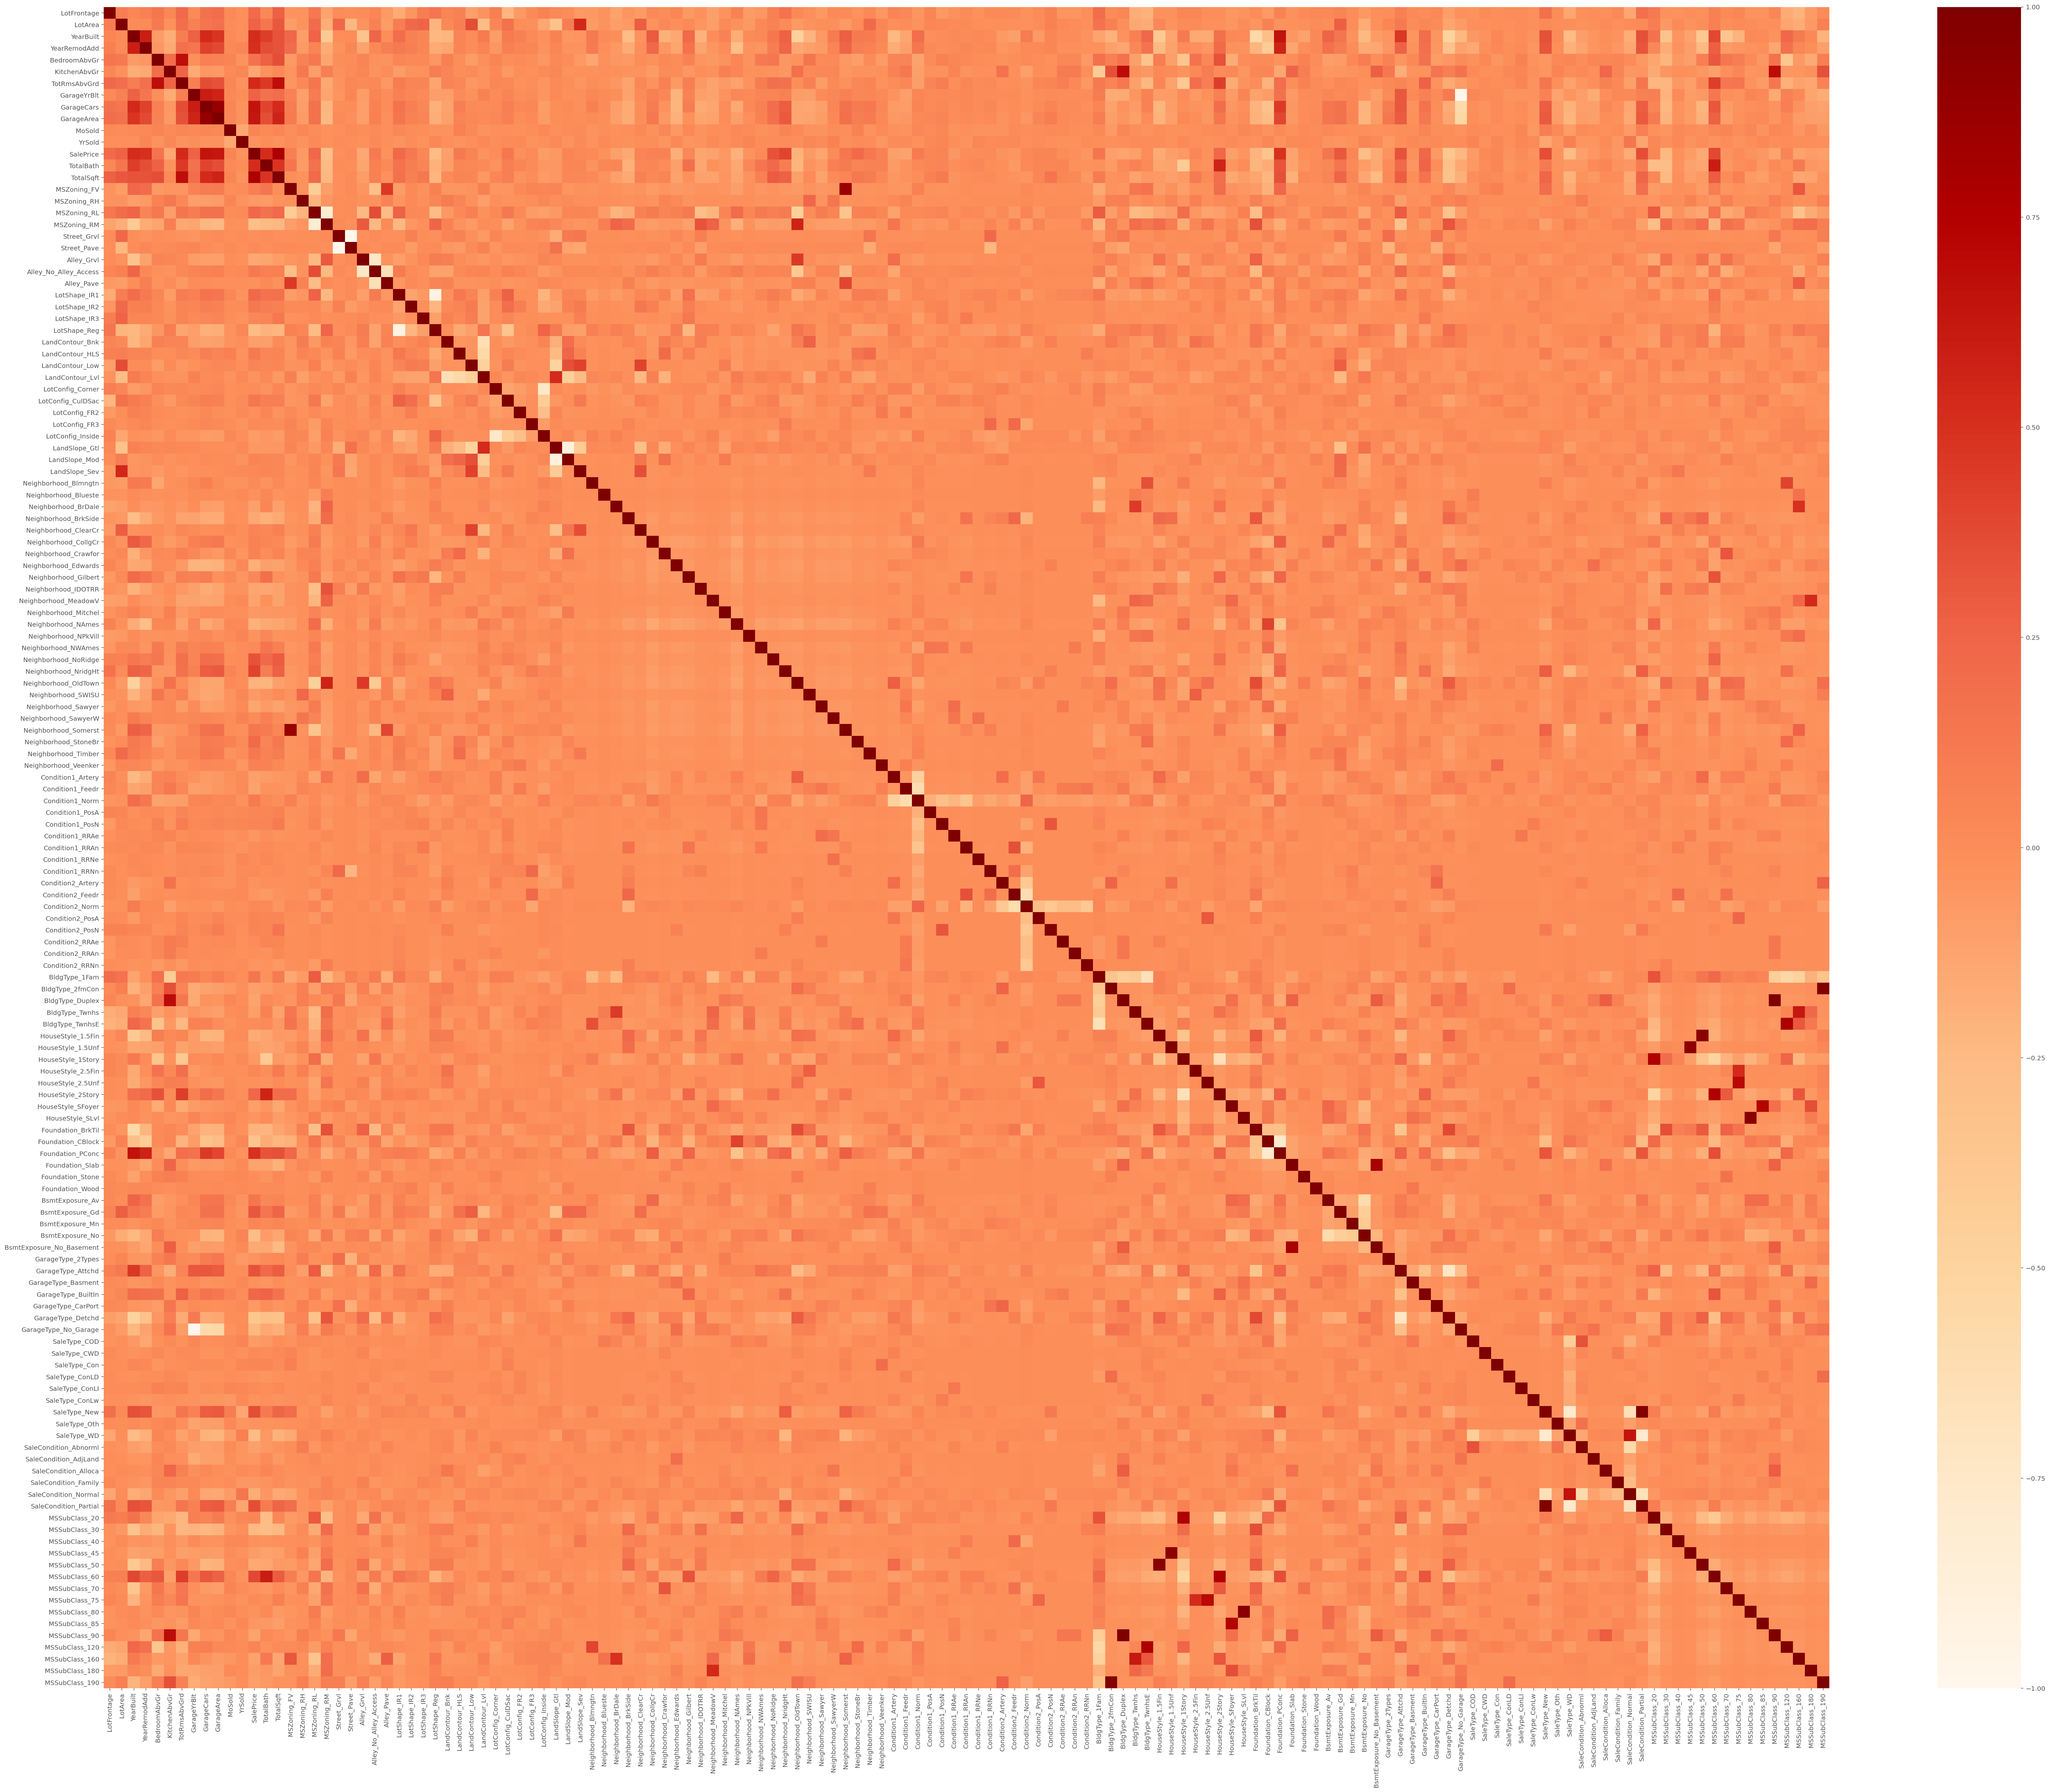

In [389]:
# let's have a look at the correlations 
# if we zoom in we can see strong positive correlations between 'GarageCars' and 'GarageArea' as well as 
# 'SalePrice' and 'TotalSQft' (so we would expect to see that as a high feature importance)
fig = plt.figure(figsize=(60,48))
sns.heatmap(house_dum.corr(), annot=False, cmap='OrRd');

In [390]:
# check the strongest correlations of chosen variables vs sales price 
house_dum.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).head(7)

SalePrice
SalePrice      1.000000
TotalSqft      0.778739
GarageCars     0.642135
GarageArea     0.629831
TotRmsAbvGrd   0.533355
TotalBath      0.523334
YearBuilt      0.517602

In [391]:
strongest = house_dum[['TotalSqft', 'GarageCars', 'GarageArea', 'TotRmsAbvGrd', 'TotalBath', 'YearBuilt', 'SalePrice']]

<Figure size 1440x1296 with 0 Axes>

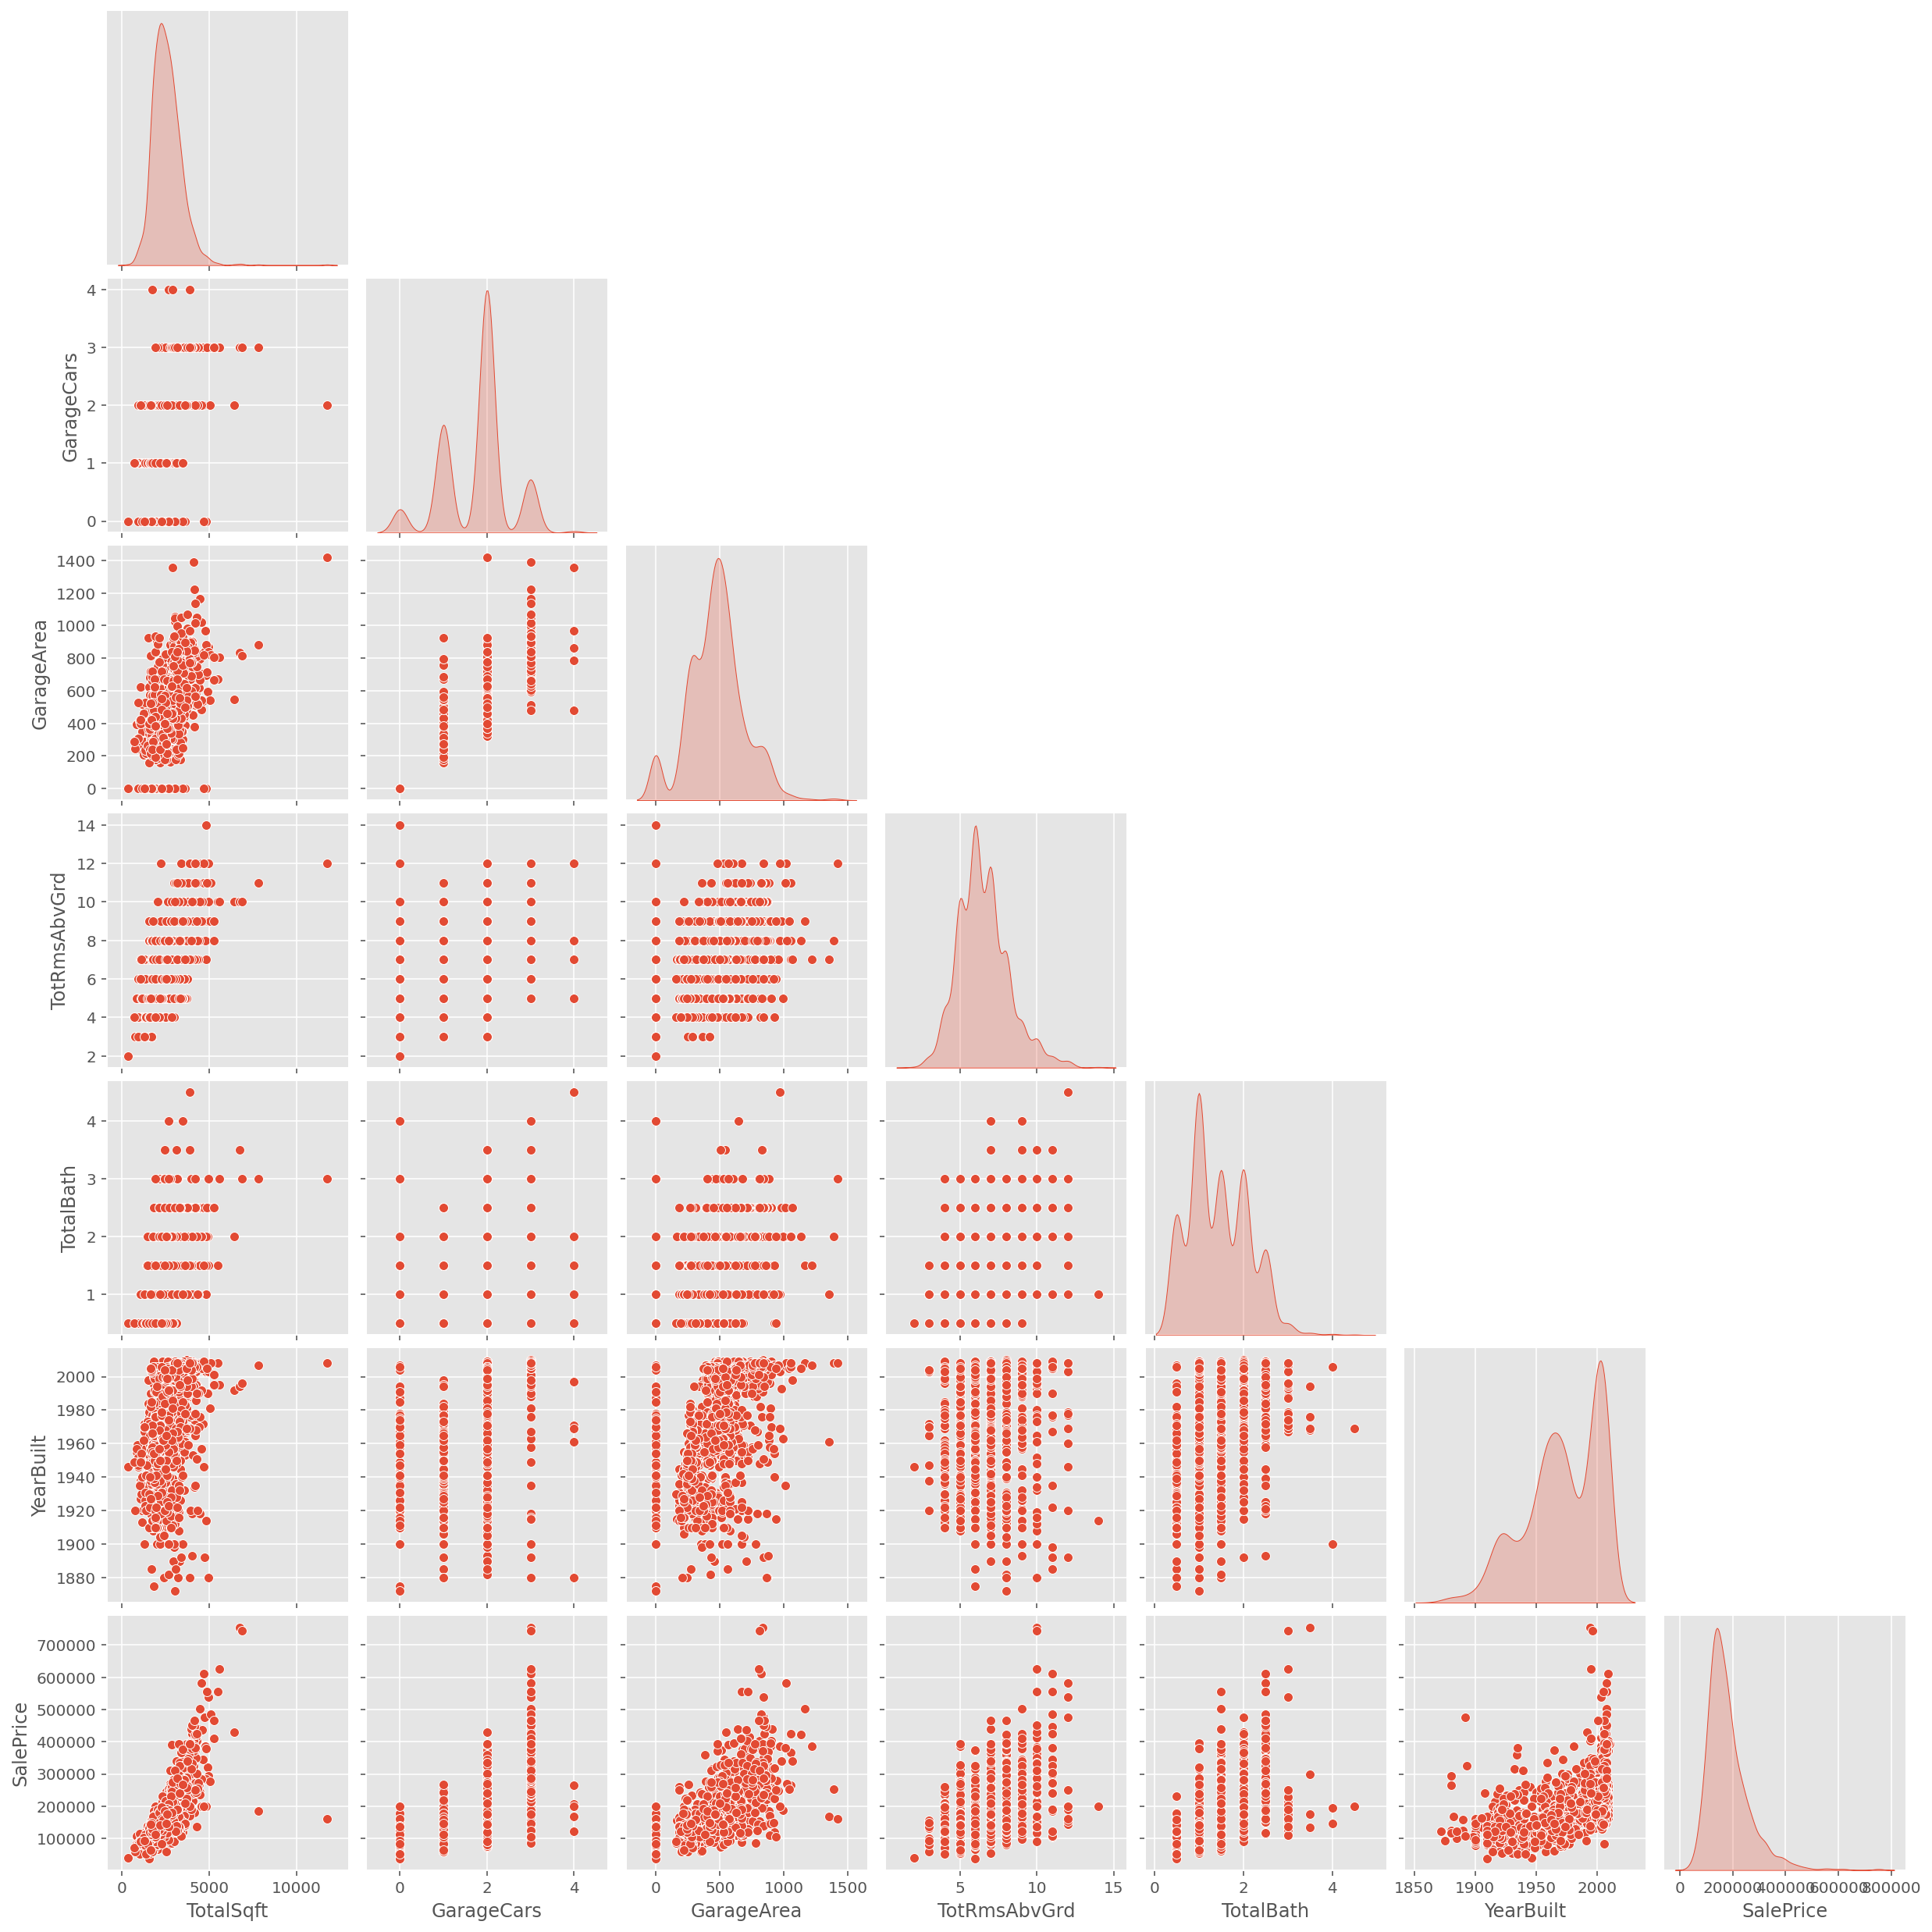

In [392]:
# plotting a pairplot for stongest correlations vs saleprice
fig = plt.figure(figsize=(20,18))
sns.pairplot(strongest, diag_kind='kde', corner=True);

In [41]:
# There are some outliers within all the predictor variables, however, as there are outliers 
# in 'SalePrice' I feel its best to keep all of them for the model.

# Totalsq_ft appears to have the strongest positive correlation to 'SalePrice'.

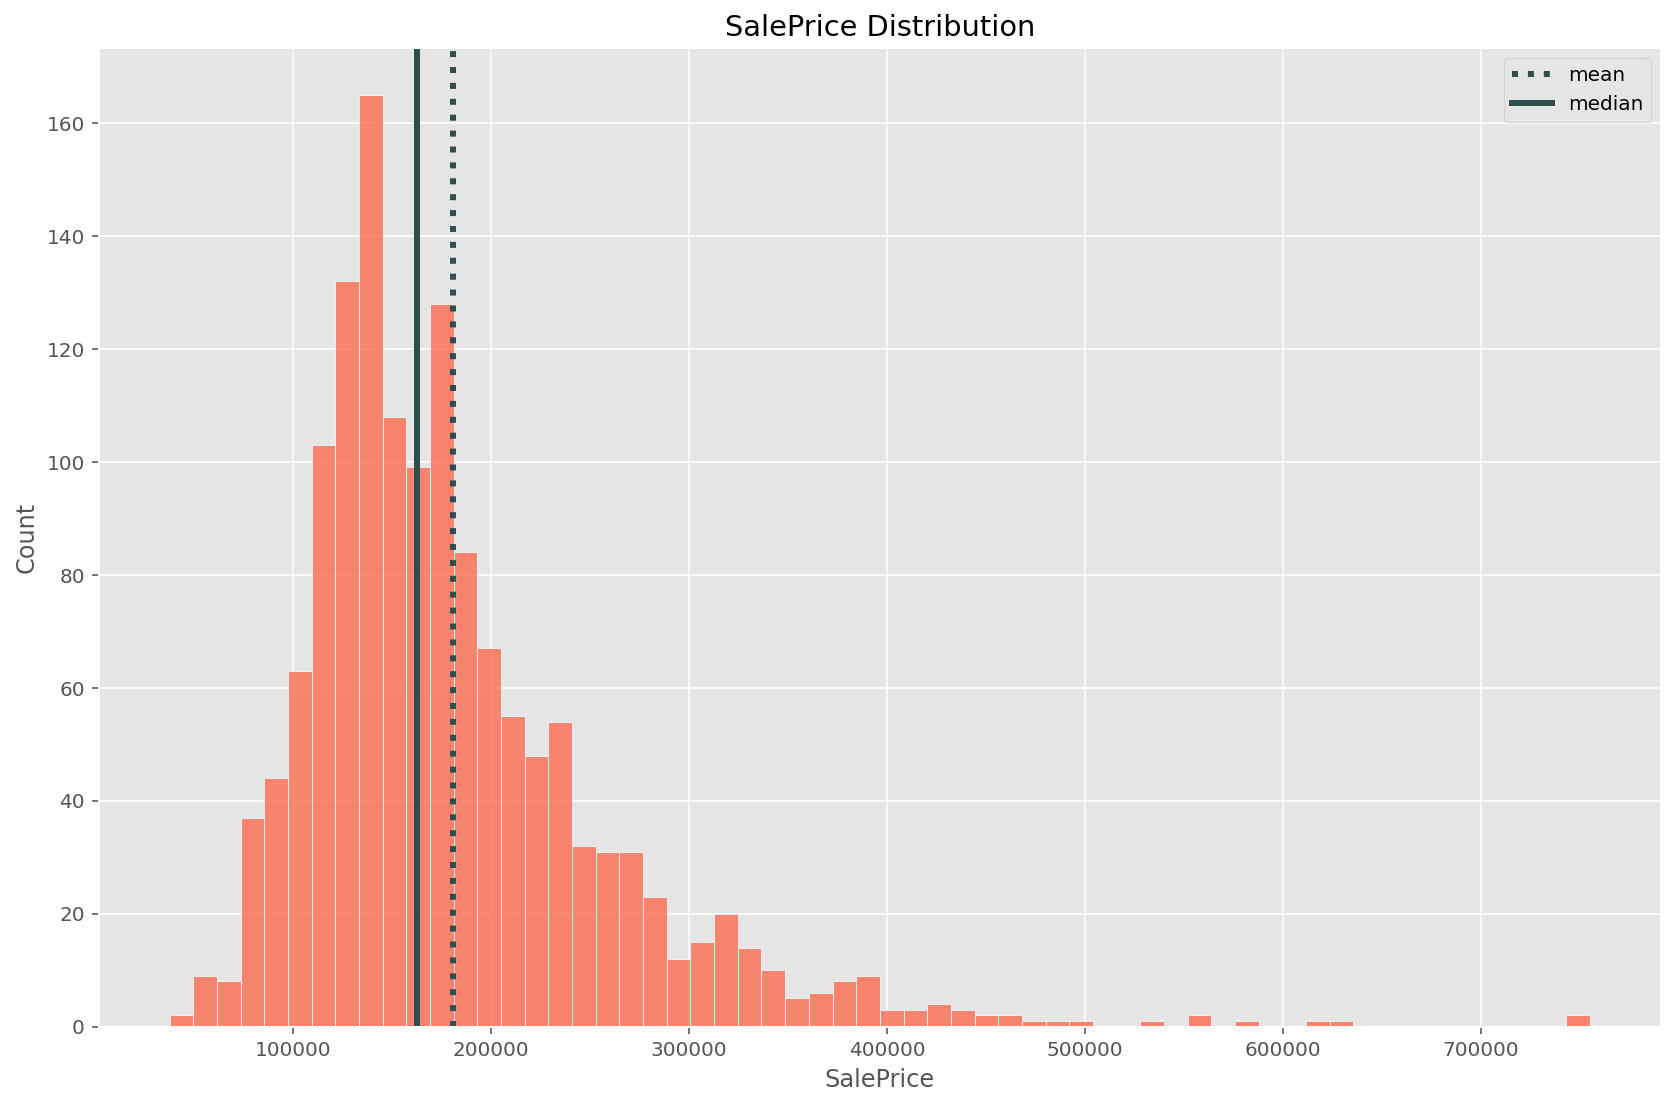

In [393]:
# Distribution of sale price is skewed to the left - with many outliers

fig = plt.figure(figsize=(14,9))
ax = fig.gca()
ax.set_title('SalePrice Distribution')
sns.histplot(house_res['SalePrice'], bins=60, color='tomato', ax=ax)
mean=ax.axvline(house['SalePrice'].mean(), color='darkslategray', linestyle=':', lw=3)
median=ax.axvline(house['SalePrice'].median(), color='darkslategray', lw=3)
plt.legend(['mean', 'median']);

# Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [394]:
# specify target + predictor variables (Train a model on pre-2010 data and evaluate its performance on the 2010 houses)

predictors = house_dum
target = house_dum.pop('SalePrice')

In [395]:
# split into x-train and x-test

X_train= house_dum[house_dum['YrSold']<2010]
y_train= house_res.loc[house_res[house_res['YrSold']<2010].index, 'SalePrice']
X_test= house_dum[house_dum['YrSold']==2010]
y_test= house_res.loc[house_res[house_res['YrSold']==2010].index, 'SalePrice']

In [396]:
house_dum.shape

(1450, 142)

In [397]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1278, 142)
(172, 142)
(1278,)
(172,)


In [398]:
# standardising the variables

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=predictors.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=predictors.columns)

In [399]:
# fit a linear regression model
model_lnr = LinearRegression()

# get cross validated scores
scores = cross_val_score(model_lnr, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training scores:", scores.mean())

# fit and evaluate the data on the whole training set
model_lnr.fit(X_train, y_train)
print("Training Score:", model_lnr.score(X_train, y_train))

# evaluate the data on the test set
print("Test Score:", model_lnr.score(X_test, y_test))

Cross-validated training scores: [ 8.24536542e-01 -6.68390894e+25 -6.55323898e+22 -1.13700331e+19
 -1.47322527e+20]
Mean cross-validated training scores: -1.3380956100644333e+25
Training Score: 0.8433002245487042
Test Score: 0.857541354203907


In [400]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model_lnr.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.head()

coefficients     coef_abs
LotFrontage   -1727.088455  1727.088455
LotArea        5778.148323  5778.148323
YearBuilt      5703.660674  5703.660674
YearRemodAdd   6386.359299  6386.359299
BedroomAbvGr  -6263.858542  6263.858542

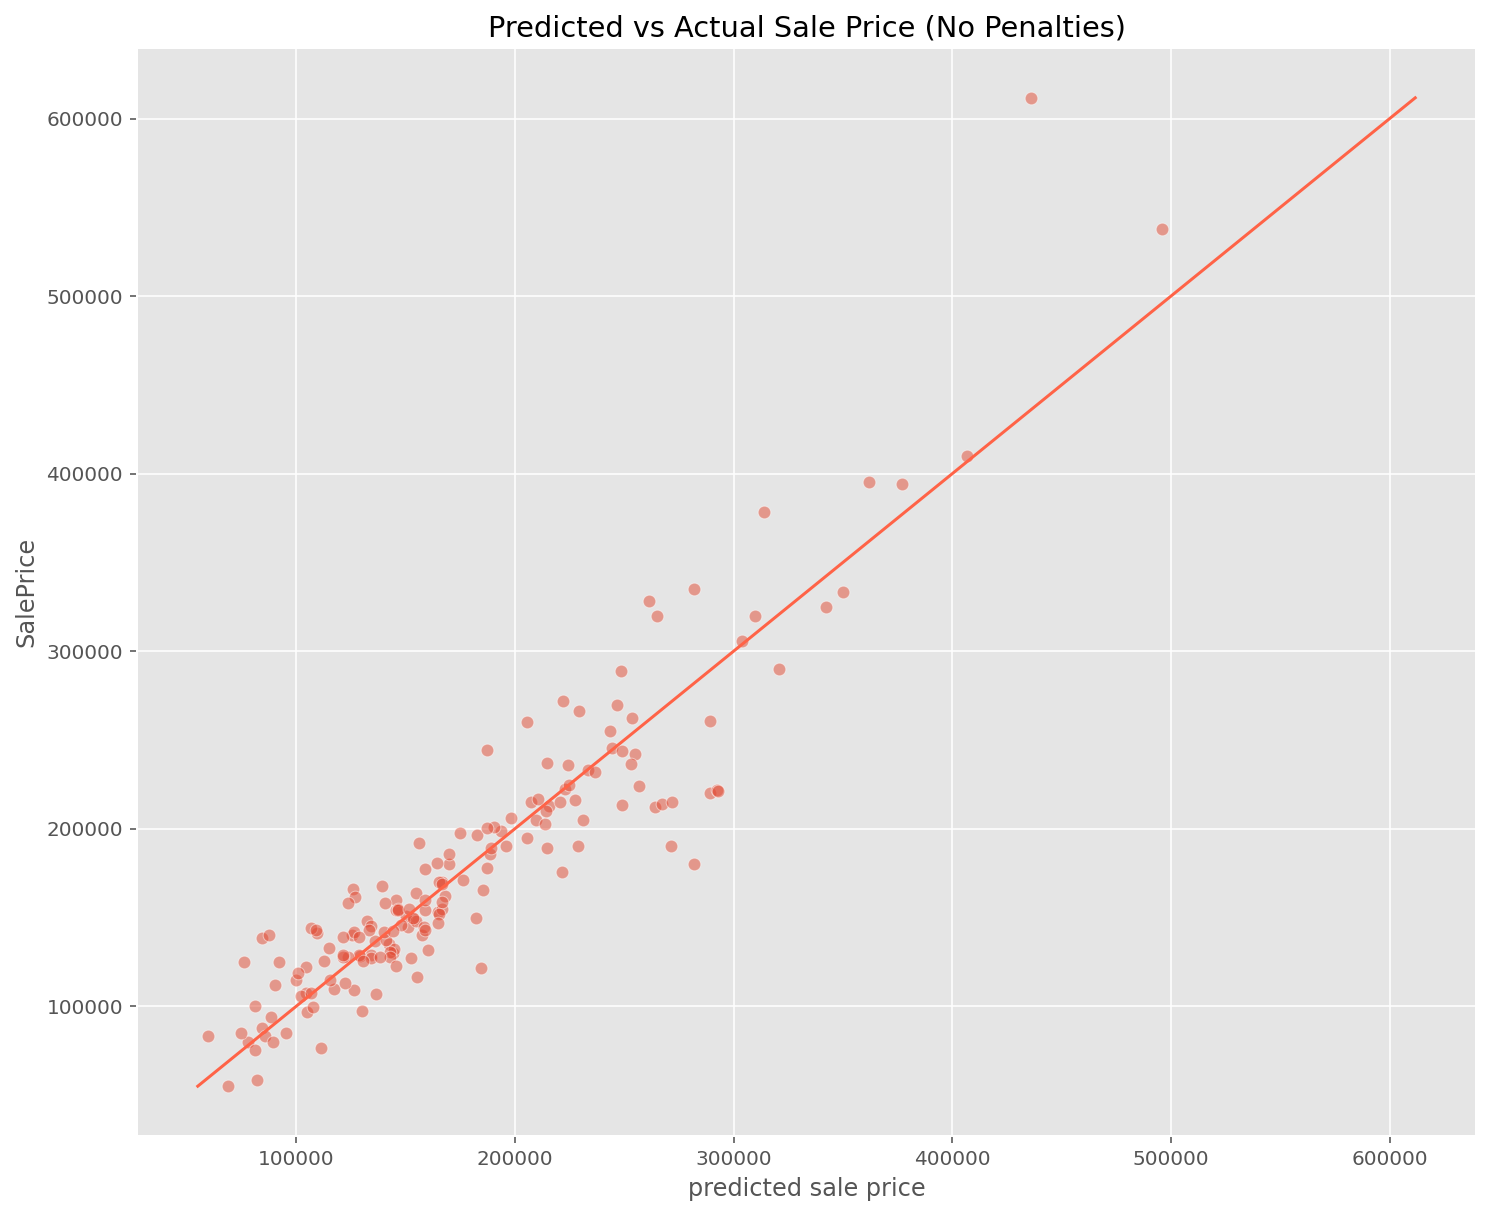

In [406]:
plt.figure(figsize=(12,10))
sns.scatterplot(x = model_lnr.predict(X_test), y = y_test, s = 40, alpha = 0.5)
p1 = max(max(model_lnr.predict(X_test)), max(y_test))
p2 = min(min(model_lnr.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'tomato')
plt.xlabel('predicted sale price')
plt.title('Predicted vs Actual Sale Price (No Penalties)');

In [402]:
# create a LassoCV model instance
model_las = LassoCV(alphas=np.logspace(-4, 4, 10), cv=10)

# fit the model
model_las.fit(X_train, y_train)

# get the best alpha
print('Best alpha:', model_las.alpha_)

# evaluate on the training set
print('Training score:', model_las.score(X_train, y_train))

# evaluate on the test set
print("Test Score:", model_las.score(X_test, y_test))

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 315939321021.5128, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529846746664.8562, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573719640406.5815, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584220613746.4121, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593693519331.1854, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595934640412.291, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/

Best alpha: 1291.5496650148827
Training score: 0.8275626306317402
Test Score: 0.8570996904415957


/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 412362219292.27637, tolerance: 691713685.812671
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371615012957.0935, tolerance: 732230710.9273593
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 528876569222.2199, tolerance: 732230710.9273593
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages

In [ ]:
# Best alpha: 1291.5496650148827
# Training score: 0.8275626306317402
# Test Score: 0.8570996904415957

In [407]:
alpha = model_las.alpha_

# create a Lasso model instance
model_las_alpha = Lasso(alpha=alpha)

# get cross validated scores
scores = cross_val_score(model_las_alpha, X_train, y_train, cv=10)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model_las_alpha.fit(X_train, y_train)
print("Training Score:", model_las_alpha.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model_las_alpha.score(X_test, y_test))

Cross-validated training scores: [0.86766569 0.84778758 0.84831993 0.76250906 0.81374503 0.74368857
 0.86771984 0.80323073 0.48830623 0.83867645]
Mean cross-validated training score: 0.7881649107652565
Training Score: 0.8275626306317402
Test Score: 0.8570996904415957


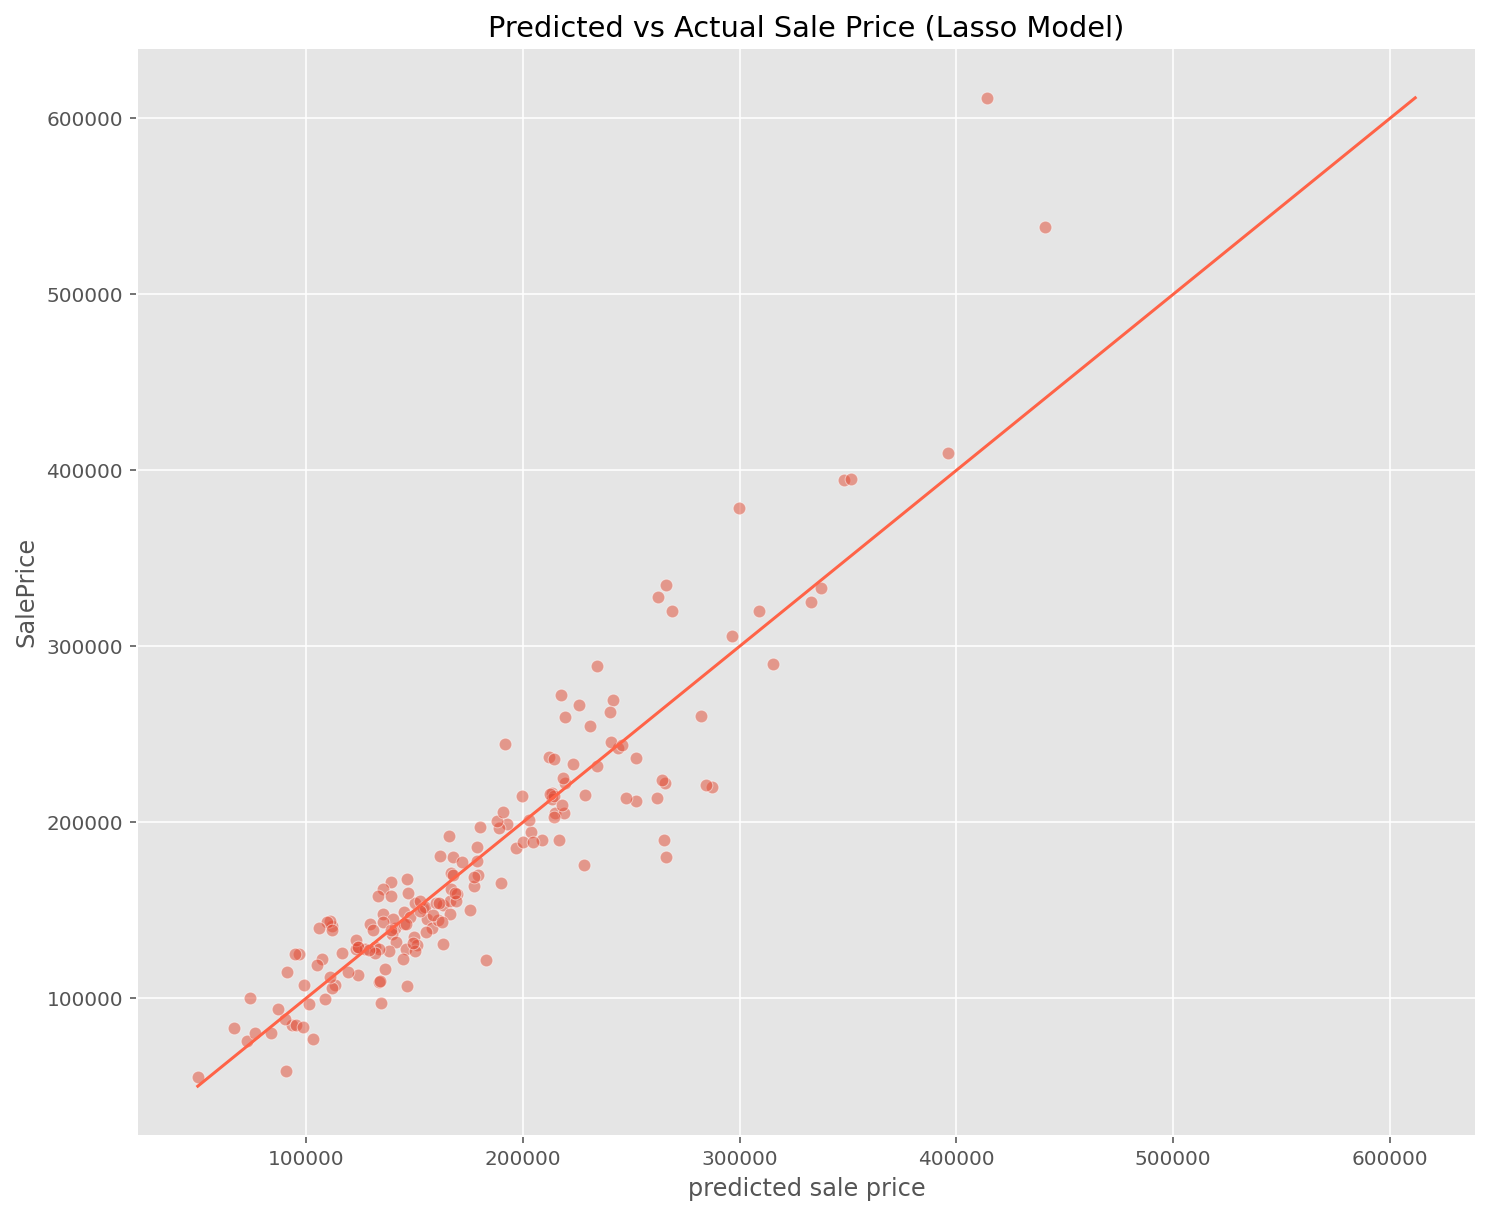

In [408]:
plt.figure(figsize = (12,10))
sns.scatterplot(x = model_las_alpha.predict(X_test), y = y_test, s = 40, alpha = 0.5)
p1 = max(max(model_las_alpha.predict(X_test)), max(y_test))
p2 = min(min(model_las_alpha.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'tomato')
plt.xlabel('predicted sale price')
plt.title('Predicted vs Actual Sale Price (Lasso Model)');

In [409]:
# collect the model coefficients in a dataframe
df_coef_alp_las = pd.DataFrame(model_las_alpha.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef_alp_las['coef_abs'] = df_coef_alp_las.coefficients.abs()
df_coef_alp_las.sort_values('coef_abs', ascending=False)

coefficients      coef_abs
TotalSqft                 31324.165851  31324.165851
Neighborhood_NridgHt      13463.380605  13463.380605
GarageCars                10457.111223  10457.111223
Neighborhood_NoRidge      10261.575255  10261.575255
Neighborhood_StoneBr       7771.906526   7771.906526
YearRemodAdd               6966.459938   6966.459938
TotalBath                  6862.961883   6862.961883
TotRmsAbvGrd               5645.308896   5645.308896
BsmtExposure_Gd            5434.282641   5434.282641
BldgType_1Fam              5119.856518   5119.856518
Neighborhood_Crawfor       5100.147406   5100.147406
BsmtExposure_No           -4473.447471   4473.447471
Neighborhood_Somerst       4395.920685   4395.920685
YearBuilt                  4259.082004   4259.082004
KitchenAbvGr              -4123.280096   4123.280096
SaleType_New               3961.637824   3961.637824
Condition2_PosN           -3706.528013   3706.528013
LotShape_IR3              -2304.245698   2304.245698
LotArea                    2216.633547   2216.633547
Neighborhood_Edwards      -2051.235696   2051.235696
Condition1_Feedr          -1950.619397   1950.619397
BedroomAbvGr              -1644.026520   1644.026520
Neighborhood_Veenker       1491.909113   1491.909113
GarageType_2Types         -1467.174887   1467.174887
LotConfig_CulDSac          1360.588816   1360.588816
Foundation_PConc           1185.743197   1185.743197
LotShape_IR2               1114.763330   1114.763330
Condition2_PosA            1105.575172   1105.575172
Condition1_RRAe           -1084.879082   1084.879082
MSSubClass_160            -1083.672460   1083.672460
GarageType_BuiltIn         1081.405111   1081.405111
LandContour_Bnk            -831.704995    831.704995
BsmtExposure_No_Basement    825.887215    825.887215
Neighborhood_Timber         608.712835    608.712835
SaleCondition_Abnorml      -583.693002    583.693002
SaleCondition_Family       -525.477124    525.477124
LotConfig_FR2              -489.579833    489.579833
GarageType_Detchd          -467.201555    467.201555
SaleType_Con                408.410700    408.410700
SaleType_COD               -390.097111    390.097111
Neighborhood_OldTown       -357.036341    357.036341
LandContour_HLS             348.147801    348.147801
Neighborhood_BrkSide        270.932150    270.932150
Neighborhood_Mitchel       -264.768897    264.768897
BldgType_Duplex            -223.659677    223.659677
Condition1_Norm             195.613520    195.613520
BldgType_Twnhs             -142.064388    142.064388
MSSubClass_90              -128.748460    128.748460
GarageType_CarPort         -110.459925    110.459925
GarageArea                   77.484003     77.484003
BsmtExposure_Av               0.000000      0.000000
HouseStyle_2Story             0.000000      0.000000
HouseStyle_SFoyer            -0.000000      0.000000
HouseStyle_SLvl              -0.000000      0.000000
BsmtExposure_Mn              -0.000000      0.000000
Foundation_BrkTil            -0.000000      0.000000
Foundation_CBlock            -0.000000      0.000000
Foundation_Slab               0.000000      0.000000
Foundation_Stone             -0.000000      0.000000
Foundation_Wood              -0.000000      0.000000
LotFrontage                  -0.000000      0.000000
GarageType_Attchd             0.000000      0.000000
MSSubClass_20                 0.000000      0.000000
MSSubClass_180               -0.000000      0.000000
MSSubClass_120               -0.000000      0.000000
MSSubClass_85                -0.000000      0.000000
MSSubClass_80                -0.000000      0.000000
MSSubClass_75                 0.000000      0.000000
MSSubClass_70                 0.000000      0.000000
MSSubClass_60                 0.000000      0.000000
MSSubClass_50                -0.000000      0.000000
MSSubClass_45                 0.000000      0.000000
MSSubClass_40                -0.000000      0.000000
MSSubClass_30                -0.000000      0.000000
SaleCondition_Partial         0.000000      0.00000

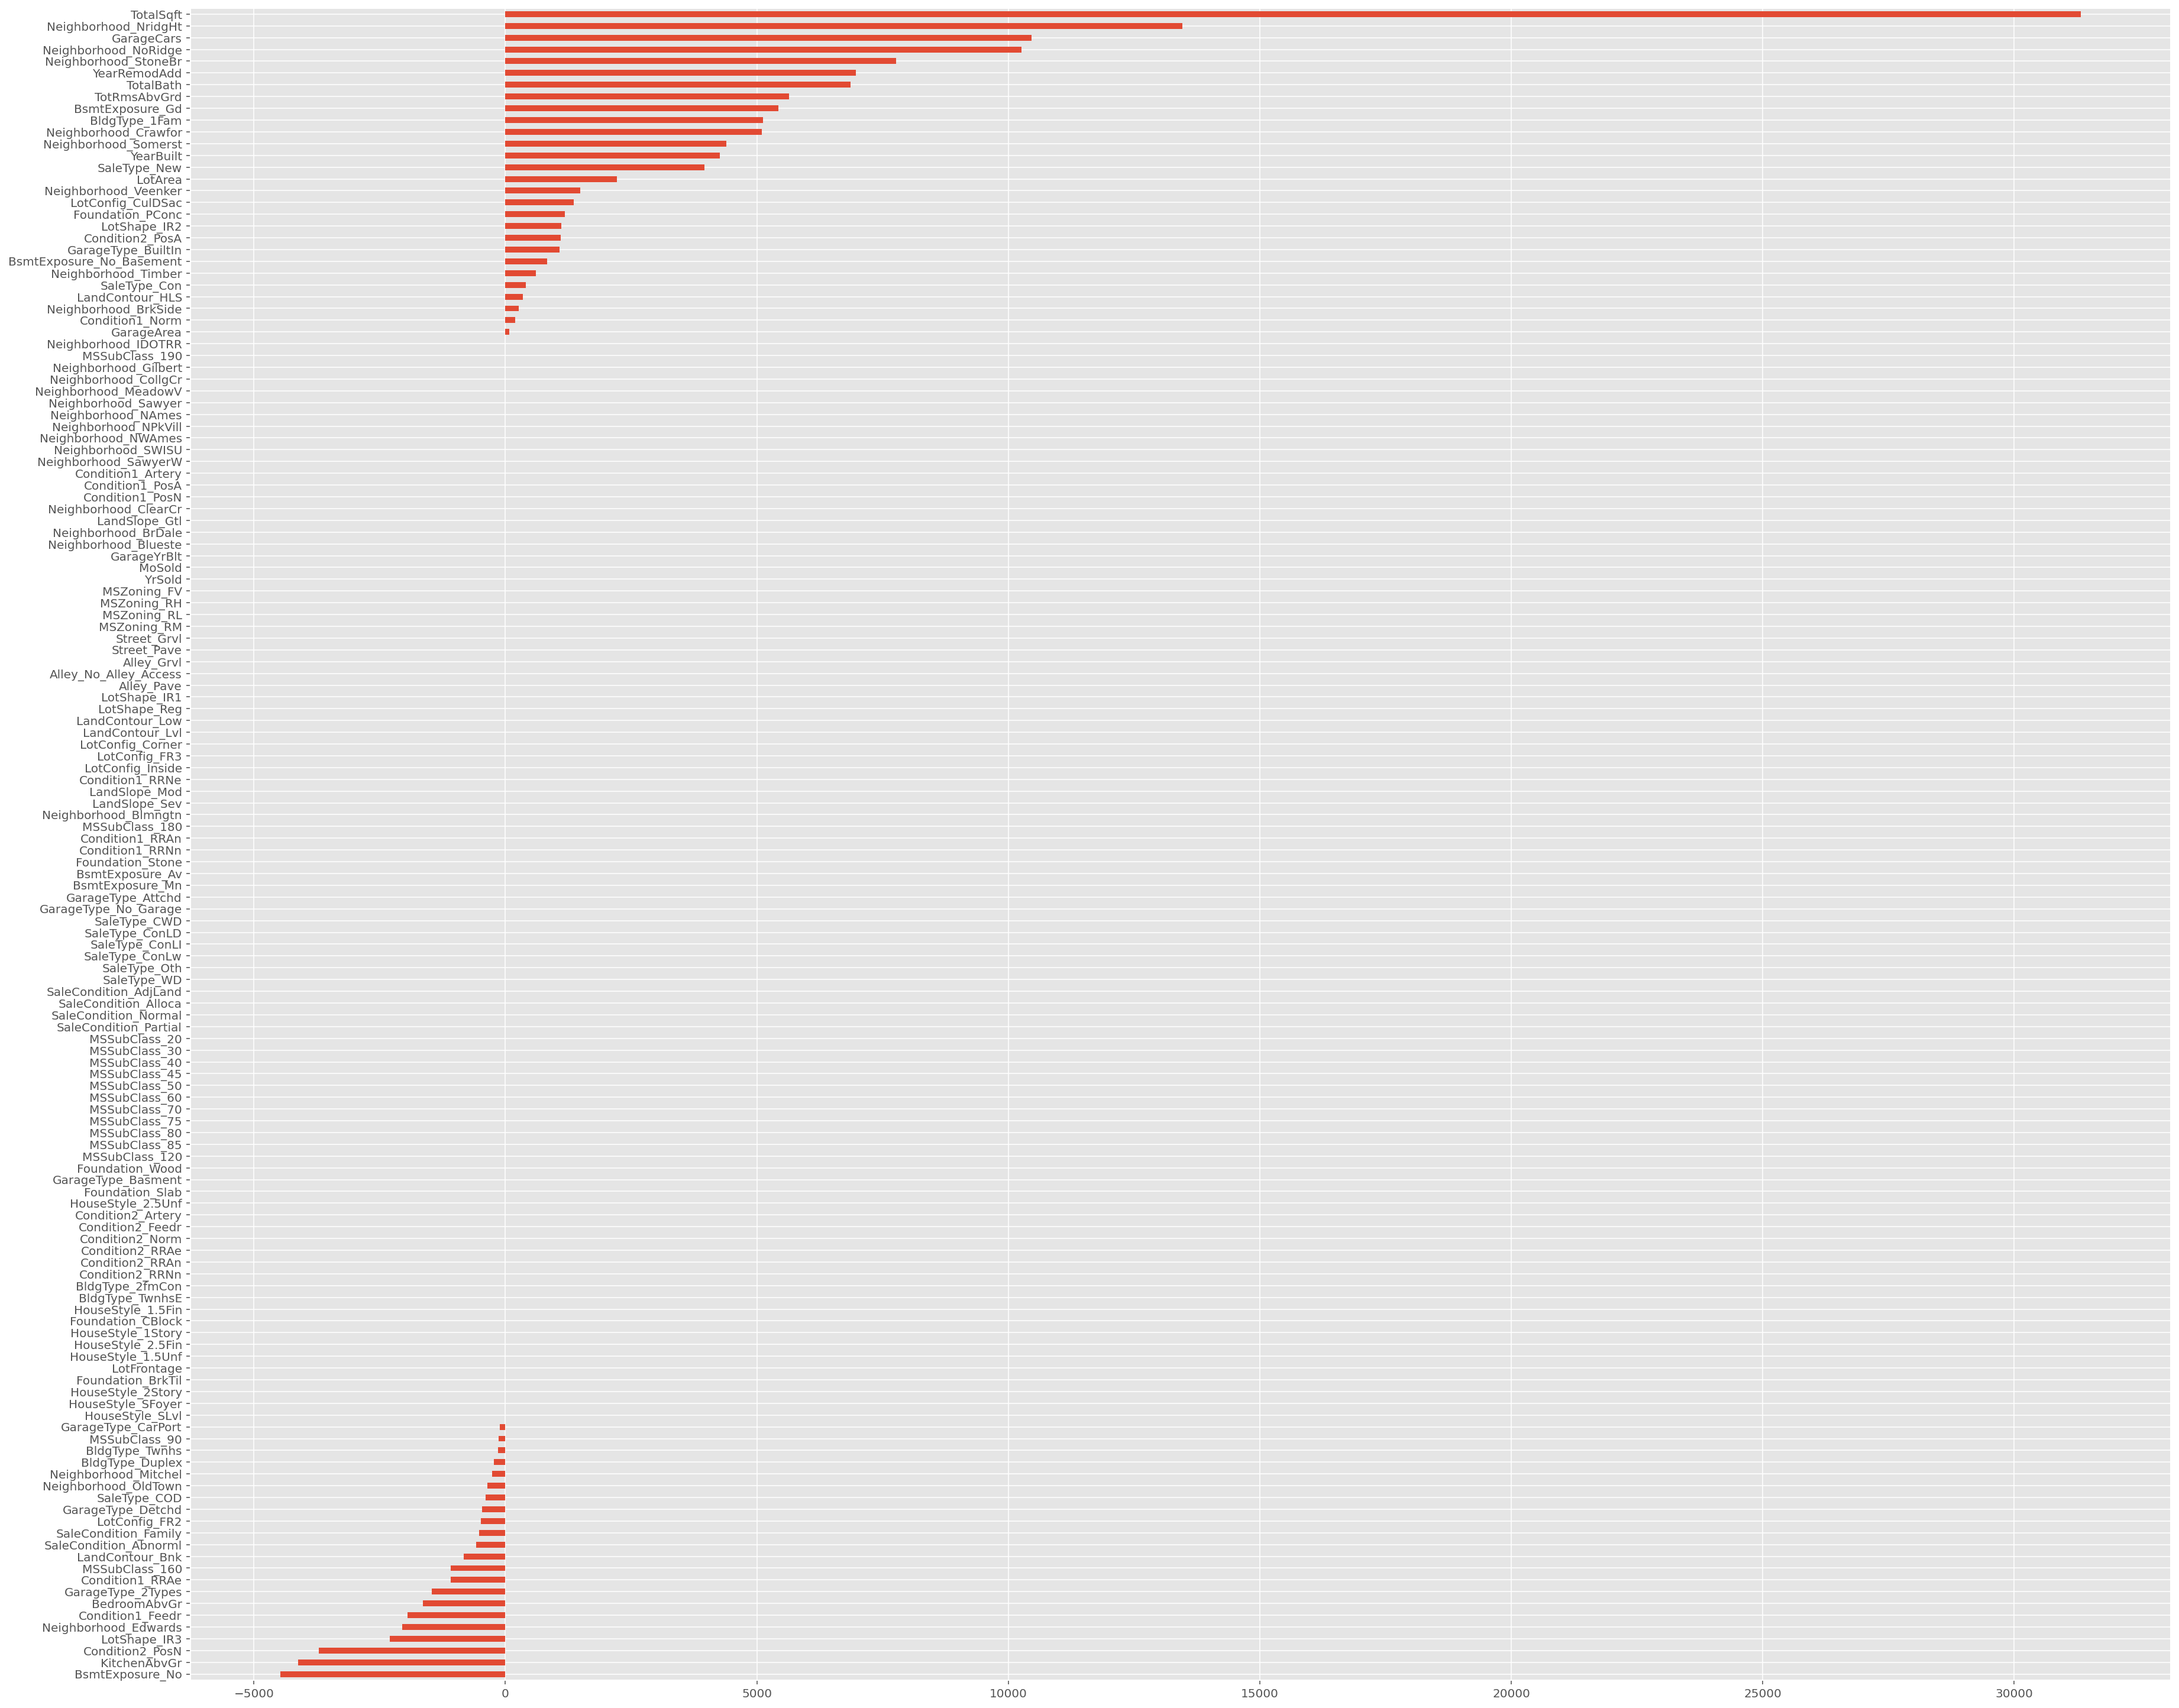

In [410]:
# plot the magnitude of the coefficients

fig = plt.figure(figsize=(30, 26))
df_coef_alp_las['coefficients'].sort_values().plot(kind='barh');

In [411]:
# create a RidgeCV model instance
model_ridg = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=10)
# fit the model
model_ridg.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', model_ridg.alpha_)
# evaluate on the training set
print('Training score:', model_ridg.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", model_ridg.score(X_test, y_test))

Best alpha: 166.81005372000558
Training score: 0.8380009969894173
Test Score: 0.8556247072794974


In [412]:
alpha_ridg = model_ridg.alpha_

# create a Ridge model instance
model_alp_ridg = Ridge(alpha=alpha_ridg)

# get cross validated scores
scores = cross_val_score(model_alp_ridg, X_train, y_train, cv=10)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

# fit and evaluate the data on the whole training set
model_alp_ridg.fit(X_train, y_train)
print("Training Score:", model_alp_ridg.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model_alp_ridg.score(X_test, y_test))

Cross-validated training scores: [0.86295628 0.81646333 0.85480135 0.73714733 0.80967524 0.75623276
 0.85879285 0.80730967 0.57090878 0.82181621]
Mean cross-validated training score: 0.7896103822410347
Training Score: 0.8380009969894173
Test Score: 0.8556247072794974


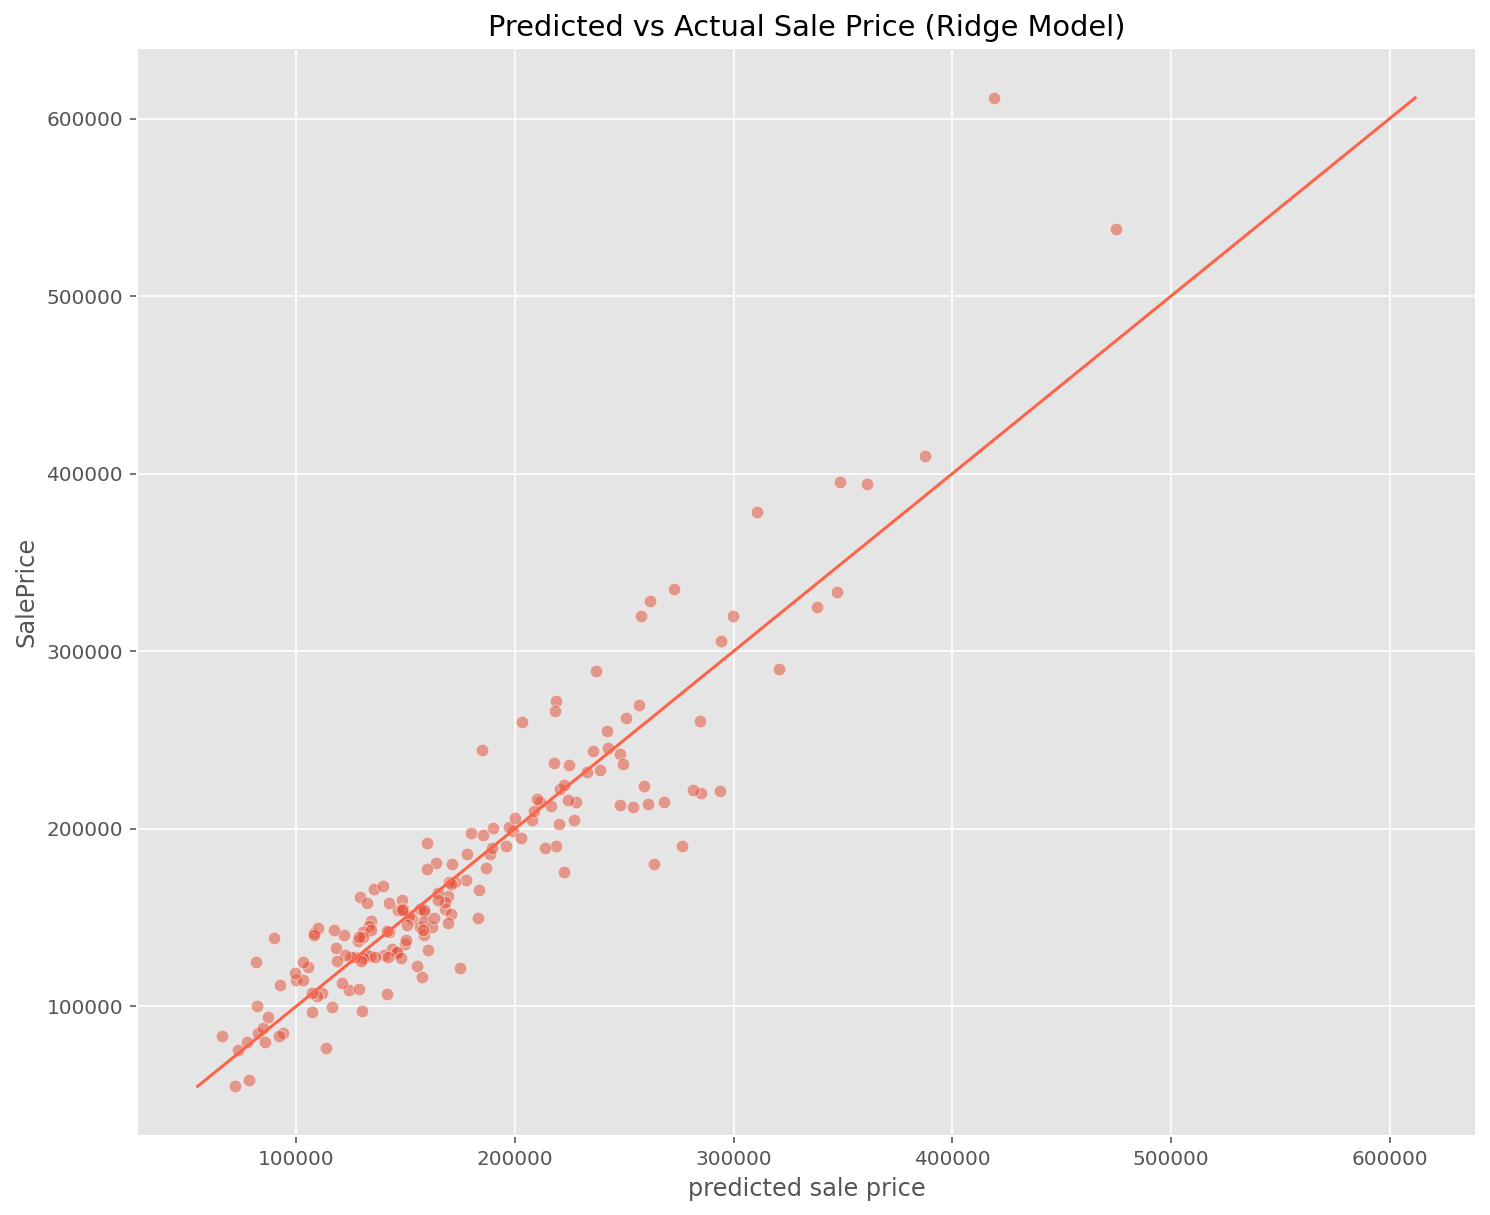

In [413]:
plt.figure(figsize = (12,10))
sns.scatterplot(x = model_alp_ridg.predict(X_test), y = y_test, s = 40, alpha = 0.5)
p1 = max(max(model_alp_ridg.predict(X_test)), max(y_test))
p2 = min(min(model_alp_ridg.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'tomato')
plt.xlabel('predicted sale price')
plt.title('Predicted vs Actual Sale Price (Ridge Model)');

In [414]:
# collect the model coefficients in a dataframe
df_coef_alp_ridg = pd.DataFrame(model_alp_ridg.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef_alp_ridg['coef_abs'] = df_coef_alp_ridg.coefficients.abs()
df_coef_alp_ridg.sort_values('coef_abs', ascending=False).head(6)

coefficients      coef_abs
TotalSqft             22416.937578  22416.937578
Neighborhood_NridgHt  11203.055305  11203.055305
TotRmsAbvGrd           9772.751207   9772.751207
Neighborhood_NoRidge   9696.027287   9696.027287
GarageCars             8556.667953   8556.667953
TotalBath              7895.357032   7895.357032

In [415]:
# create an ElasticNetCV model instance
model_ela = ElasticNetCV(alphas=np.logspace(-4, 4, 100), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=10, n_jobs=2, max_iter=100000)
# fit the model
model_ela.fit(X_train, y_train)
# get the best alpha
print('Best alpha:', model_ela.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', model_ela.l1_ratio_)
# evaluate on the training set
print('Training score:', model_ela.score(X_train, y_train))
# evaluate on the test set
print("Test Score:", model_ela.score(X_test, y_test))

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1254829580.842041, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4562048095.179199, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4346124947.163574, tolerance: 714662029.9952912
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63977872204.809814, tolerance: 714662029.9952912
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4706575341.258179, tolerance: 703840100.3149817
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12940696691.243896, tolerance: 703840100.3149817
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packag

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52805514941.36145, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82146081148.66833, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 923138863.6264648, tolerance: 737091993.7091969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15187492956.043335, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19106031498.478394, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22859105316.184204, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packa

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11395306583.349854, tolerance: 717632505.0834739
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3035756134.310547, tolerance: 673761119.8434244
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14401894415.659058, tolerance: 717632505.0834739
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packag

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79172623344.5498, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 775642666.890625, tolerance: 737091993.7091969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2493293815.6921387, tolerance: 737091993.7091969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168724147049.0205, tolerance: 732230710.9273593
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1125154511.395996, tolerance: 737421154.3555653
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185957104476.55273, tolerance: 732230710.9273593
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-package

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2344815865.125244, tolerance: 703840100.3149817
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5312755611.825684, tolerance: 714662029.9952912
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2968110878.920532, tolerance: 703840100.3149817
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1892374783.5750732, tolerance: 673761119.8434244
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1859752868.5534668, tolerance: 717632505.0834739
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2345655172.7750244, tolerance: 673761119.8434244
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packa

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4152615670.613159, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14326891338.410889, tolerance: 728608825.2792995
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5432729959.916382, tolerance: 752356089.3546773
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-package

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5221793580.605835, tolerance: 737091993.7091969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1410816950.1802979, tolerance: 691713685.812671
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5398391790.948608, tolerance: 737091993.7091969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40719766977.05859, tolerance: 732230710.9273593
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42110421862.11047, tolerance: 732230710.9273593
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43284793732.94031, tolerance: 732230710.9273593
  model = cd_fast.enet_coordinate_descent_gram(


Best alpha: 21.544346900318867
Best l1-ratio: 0.99
Training score: 0.8329457248660734
Test Score: 0.8516598798968341


In [ ]:
# Best alpha: 21.54434690031882
# Best l1-ratio: 0.99
# Training score: 0.8329457248660734
# Test Score: 0.8516598798968341

In [416]:
alpha_el = model_ela.alpha_
l1_ratio_el = model_ela.l1_ratio_

model_ela_alp = ElasticNet(alpha=alpha_el, l1_ratio=l1_ratio_el)

# get cross validated scores
scores = cross_val_score(model_ela_alp, X_train, y_train, cv=10)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())
# fit and evaluate the data on the whole training set
model_ela_alp.fit(X_train, y_train)
print("Training Score:", model_ela_alp.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", model_ela_alp.score(X_test, y_test))

Cross-validated training scores: [0.86405012 0.81530174 0.8510618  0.74325603 0.80058731 0.7679399
 0.85765859 0.81225323 0.58434109 0.82195424]
Mean cross-validated training score: 0.7918404049717752
Training Score: 0.8329457248660734
Test Score: 0.8516598798968341


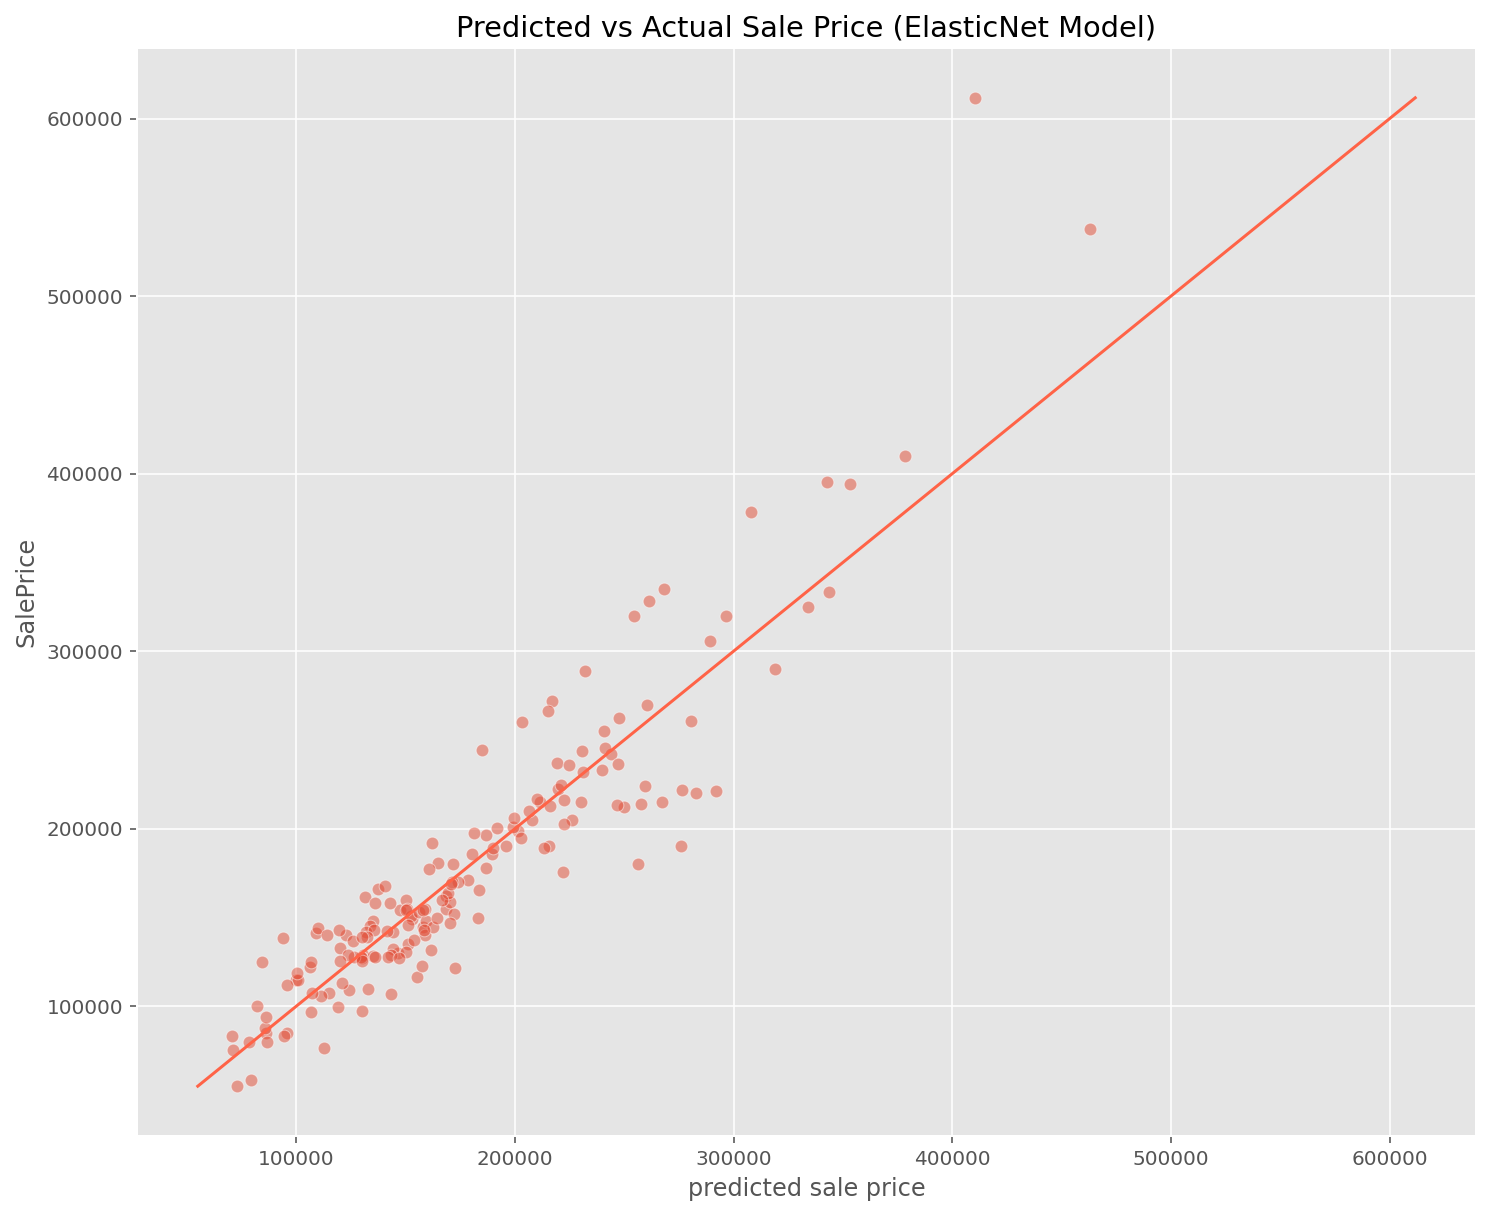

In [417]:
plt.figure(figsize = (12,10))
sns.scatterplot(x = model_ela_alp.predict(X_test), y = y_test, s = 40, alpha = 0.5)
p1 = max(max(model_ela_alp.predict(X_test)), max(y_test))
p2 = min(min(model_ela_alp.predict(X_test)), min(y_test))
plt.plot([p1, p2], [p1, p2], 'tomato')
plt.xlabel('predicted sale price')
plt.title('Predicted vs Actual Sale Price (ElasticNet Model)');

In [ ]:
# we can see a very similiar pattern in predicted vs actual graphs as the model are giving out very close
# mean cv and test scores.

In [422]:
# collect the model coefficients in a dataframe
df_coef_alp_el = pd.DataFrame(model_ela_alp.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
df_coef_alp_el['coef_abs'] = df_coef_alp_el.coefficients.abs()
df_coef_alp_el.sort_values('coef_abs', ascending=False)

coefficients      coef_abs
TotalSqft                 20252.129163  20252.129163
Neighborhood_NridgHt      10495.594566  10495.594566
TotRmsAbvGrd               9478.342133   9478.342133
Neighborhood_NoRidge       9305.128097   9305.128097
GarageCars                 8014.663591   8014.663591
TotalBath                  7500.141564   7500.141564
Neighborhood_StoneBr       6774.460187   6774.460187
BsmtExposure_Gd            6469.524930   6469.524930
YearRemodAdd               5898.422726   5898.422726
GarageArea                 5719.017294   5719.017294
LotArea                    4899.507318   4899.507318
Neighborhood_Crawfor       4297.653130   4297.653130
BsmtExposure_No           -4264.456527   4264.456527
Neighborhood_Edwards      -4146.232261   4146.232261
YearBuilt                  4009.815515   4009.815515
KitchenAbvGr              -3729.517421   3729.517421
Neighborhood_Gilbert      -3638.727589   3638.727589
Condition2_PosN           -3465.134135   3465.134135
Neighborhood_NAmes        -3318.115092   3318.115092
Neighborhood_CollgCr      -2675.598705   2675.598705
Neighborhood_Mitchel      -2640.548108   2640.548108
GarageType_BuiltIn         2604.855203   2604.855203
LotShape_IR3              -2564.730791   2564.730791
MSSubClass_160            -2483.994336   2483.994336
Condition2_PosA            2352.974731   2352.974731
GarageType_2Types         -2328.685512   2328.685512
BedroomAbvGr              -2281.302071   2281.302071
Neighborhood_Sawyer       -2229.885491   2229.885491
Condition1_Feedr          -2218.705934   2218.705934
BldgType_1Fam              2066.675780   2066.675780
SaleType_New               2059.387625   2059.387625
Foundation_PConc           2054.384635   2054.384635
Condition1_RRAe           -2044.271287   2044.271287
Neighborhood_Somerst       1963.342324   1963.342324
GarageType_Detchd         -1932.282322   1932.282322
LandSlope_Sev             -1840.096650   1840.096650
LotConfig_CulDSac          1809.093893   1809.093893
LotShape_IR2               1802.079006   1802.079006
Neighborhood_NWAmes       -1768.843844   1768.843844
LotConfig_FR2             -1726.125997   1726.125997
SaleCondition_Partial      1699.965400   1699.965400
Neighborhood_OldTown      -1630.239253   1630.239253
Neighborhood_Veenker       1533.463255   1533.463255
SaleType_COD              -1527.840440   1527.840440
LandContour_Bnk           -1465.406002   1465.406002
MSSubClass_20              1430.250750   1430.250750
Condition1_Norm            1306.833797   1306.833797
Foundation_CBlock         -1291.860094   1291.860094
BldgType_Twnhs            -1291.416370   1291.416370
SaleCondition_Family      -1228.747047   1228.747047
GarageType_CarPort        -1148.029603   1148.029603
Neighborhood_ClearCr      -1129.737277   1129.737277
SaleType_Con               1129.116036   1129.116036
SaleType_CWD               1127.600814   1127.600814
MSZoning_FV                1116.946856   1116.946856
Neighborhood_Blmngtn      -1111.133240   1111.133240
Condition1_RRNn            1107.015899   1107.015899
BldgType_TwnhsE           -1104.759341   1104.759341
SaleCondition_Abnorml     -1097.357264   1097.357264
SaleType_WD               -1096.450771   1096.450771
Condition1_PosN            1074.655366   1074.655366
LandContour_HLS            1051.231760   1051.231760
MSSubClass_90             -1018.734751   1018.734751
BldgType_Duplex           -1018.033202   1018.033202
MSSubClass_30             -1014.837323   1014.837323
MSZoning_RM               -1009.015691   1009.015691
Neighborhood_MeadowV       -969.335324    969.335324
Foundation_BrkTil          -874.847706    874.847706
Condition2_Norm             853.209027    853.209027
GarageType_No_Garage        851.741465    851.741465
LandSlope_Mod               803.082543    803.082543
GarageYrBlt                -796.812714    796.812714
HouseStyle_1.5Unf           790.685740    790.685740
HouseStyle_SLvl            -776.510257    776.510257
HouseStyle_2.5Fin           733.936726    733.93672

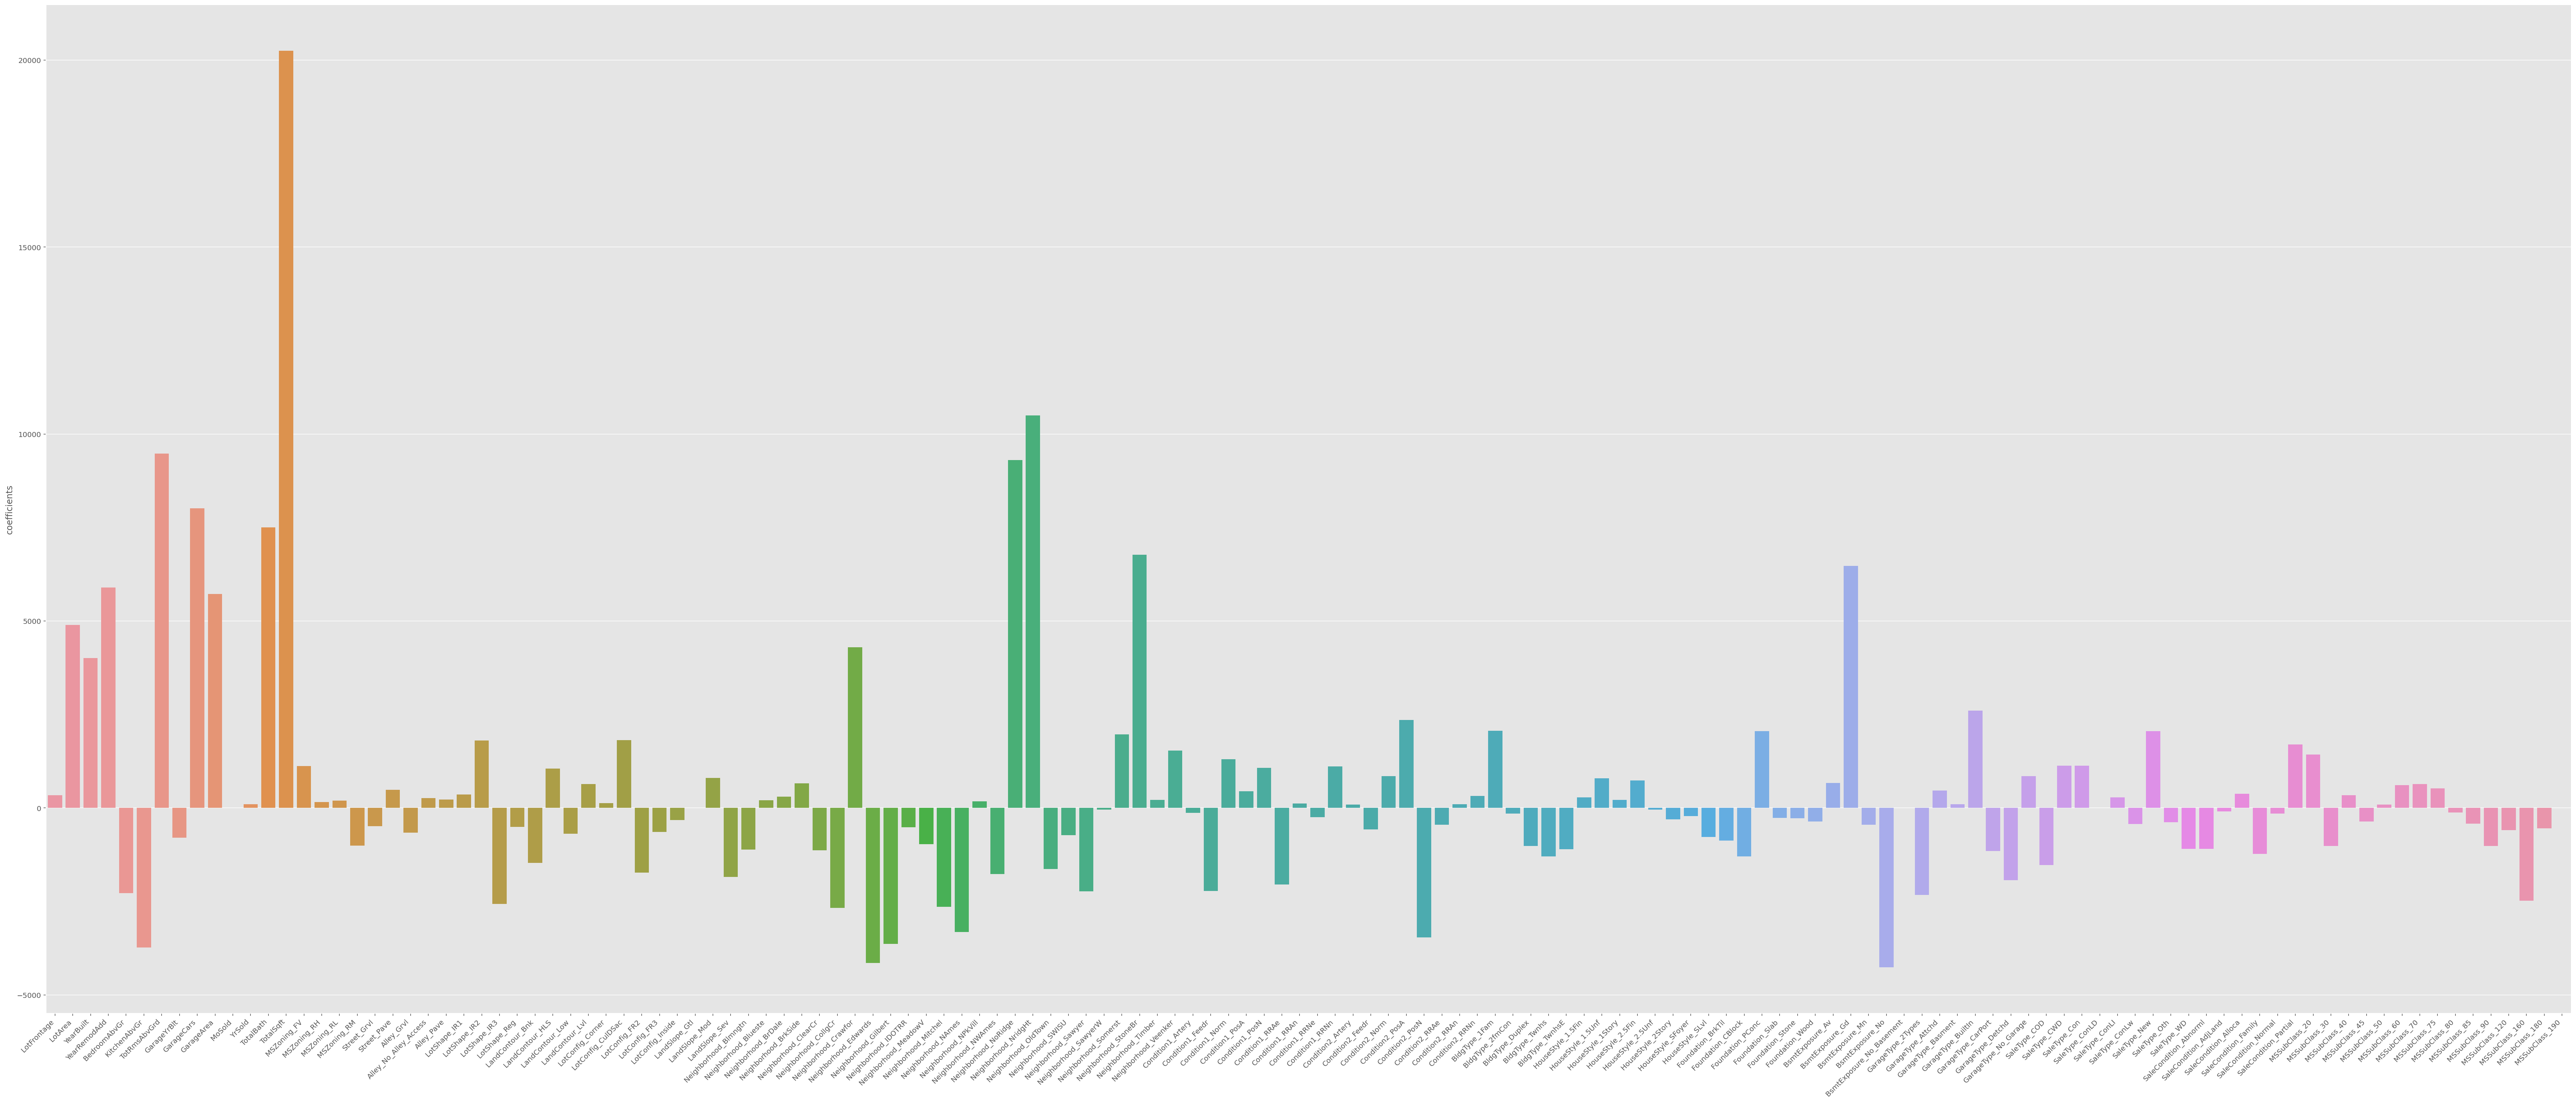

In [439]:
# let's see how all the features affected the SalePrice
sns.catplot(x=df_coef_alp_el.index, y='coefficients', 
               data=df_coef_alp_el, kind='bar', height=20, aspect=2.5).set_xticklabels(rotation=45, horizontalalignment='right');

In [440]:
# Scores:

print('Lasso')
print("Mean cross-validated training score:", 0.7881649107652565)
model_las_alpha.fit(X_train, y_train)
print("Training Score:", model_las_alpha.score(X_train, y_train))
print("Test Score:", model_las_alpha.score(X_test, y_test), '*Best*')
print('\n')
print('Ridge')
print("Mean cross-validated training score:", 0.7896103822410347)
model_alp_ridg.fit(X_train, y_train)
print("Training Score:", model_alp_ridg.score(X_train, y_train), '*Best*')
print("Test Score:", model_alp_ridg.score(X_test, y_test))
print('\n')
print('ElasticNet')
print("Mean cross-validated training score:", 0.7918404049717752, '*Best*')
model_ela_alp.fit(X_train, y_train)
print("Training Score:", model_ela_alp.score(X_train, y_train))
print("Test Score:", model_ela_alp.score(X_test, y_test))
print("\n")
print("Intercept for ElasticNet:", model_ela_alp.intercept_)

Lasso
Mean cross-validated training score: 0.7881649107652565
Training Score: 0.8275626306317402
Test Score: 0.8570996904415957 *Best*


Ridge
Mean cross-validated training score: 0.7896103822410347
Training Score: 0.8380009969894173 *Best*
Test Score: 0.8556247072794974


ElasticNet
Mean cross-validated training score: 0.7918404049717752 *Best*
Training Score: 0.8329457248660734
Test Score: 0.8516598798968341


Intercept for ElasticNet: 181989.78247261344


Characterize your model. How well does it perform? What are the best estimates of price?

In [ ]:
# ElasticNet has the best mean cv score (R-squared) with 0.792. Meaning 79.2% of the 
# SalePrice variation is explained by this model. 

# All models peformed better in the test than in the training sets, perhaps denoting to these
# fixed features being more prominant in the houses in 2010. But it means the model generalises
# well as well.

# We can see that Lasso removed 92 of the variables, as the correlation of the 
# co-efficients was insignificant. I therefore feel the model would have improved if some 
# of the features had been dropped or combined before modelling.

# The best estimators for price are:
# 1 - Totalsqft
# 2 - Neighborhood_NRidgHt
# 3 - TotalRmsAbvGrd
# 4 - Neighborhood_NoRidge
# 5 - GarageCars
# 6 - TotalBath
# (which is a similiar list to our strongest correlations in the heatmap above)

# For our best model (ElasticNet) the intercept is the price obtained for the mean of the features
# which would be zero.

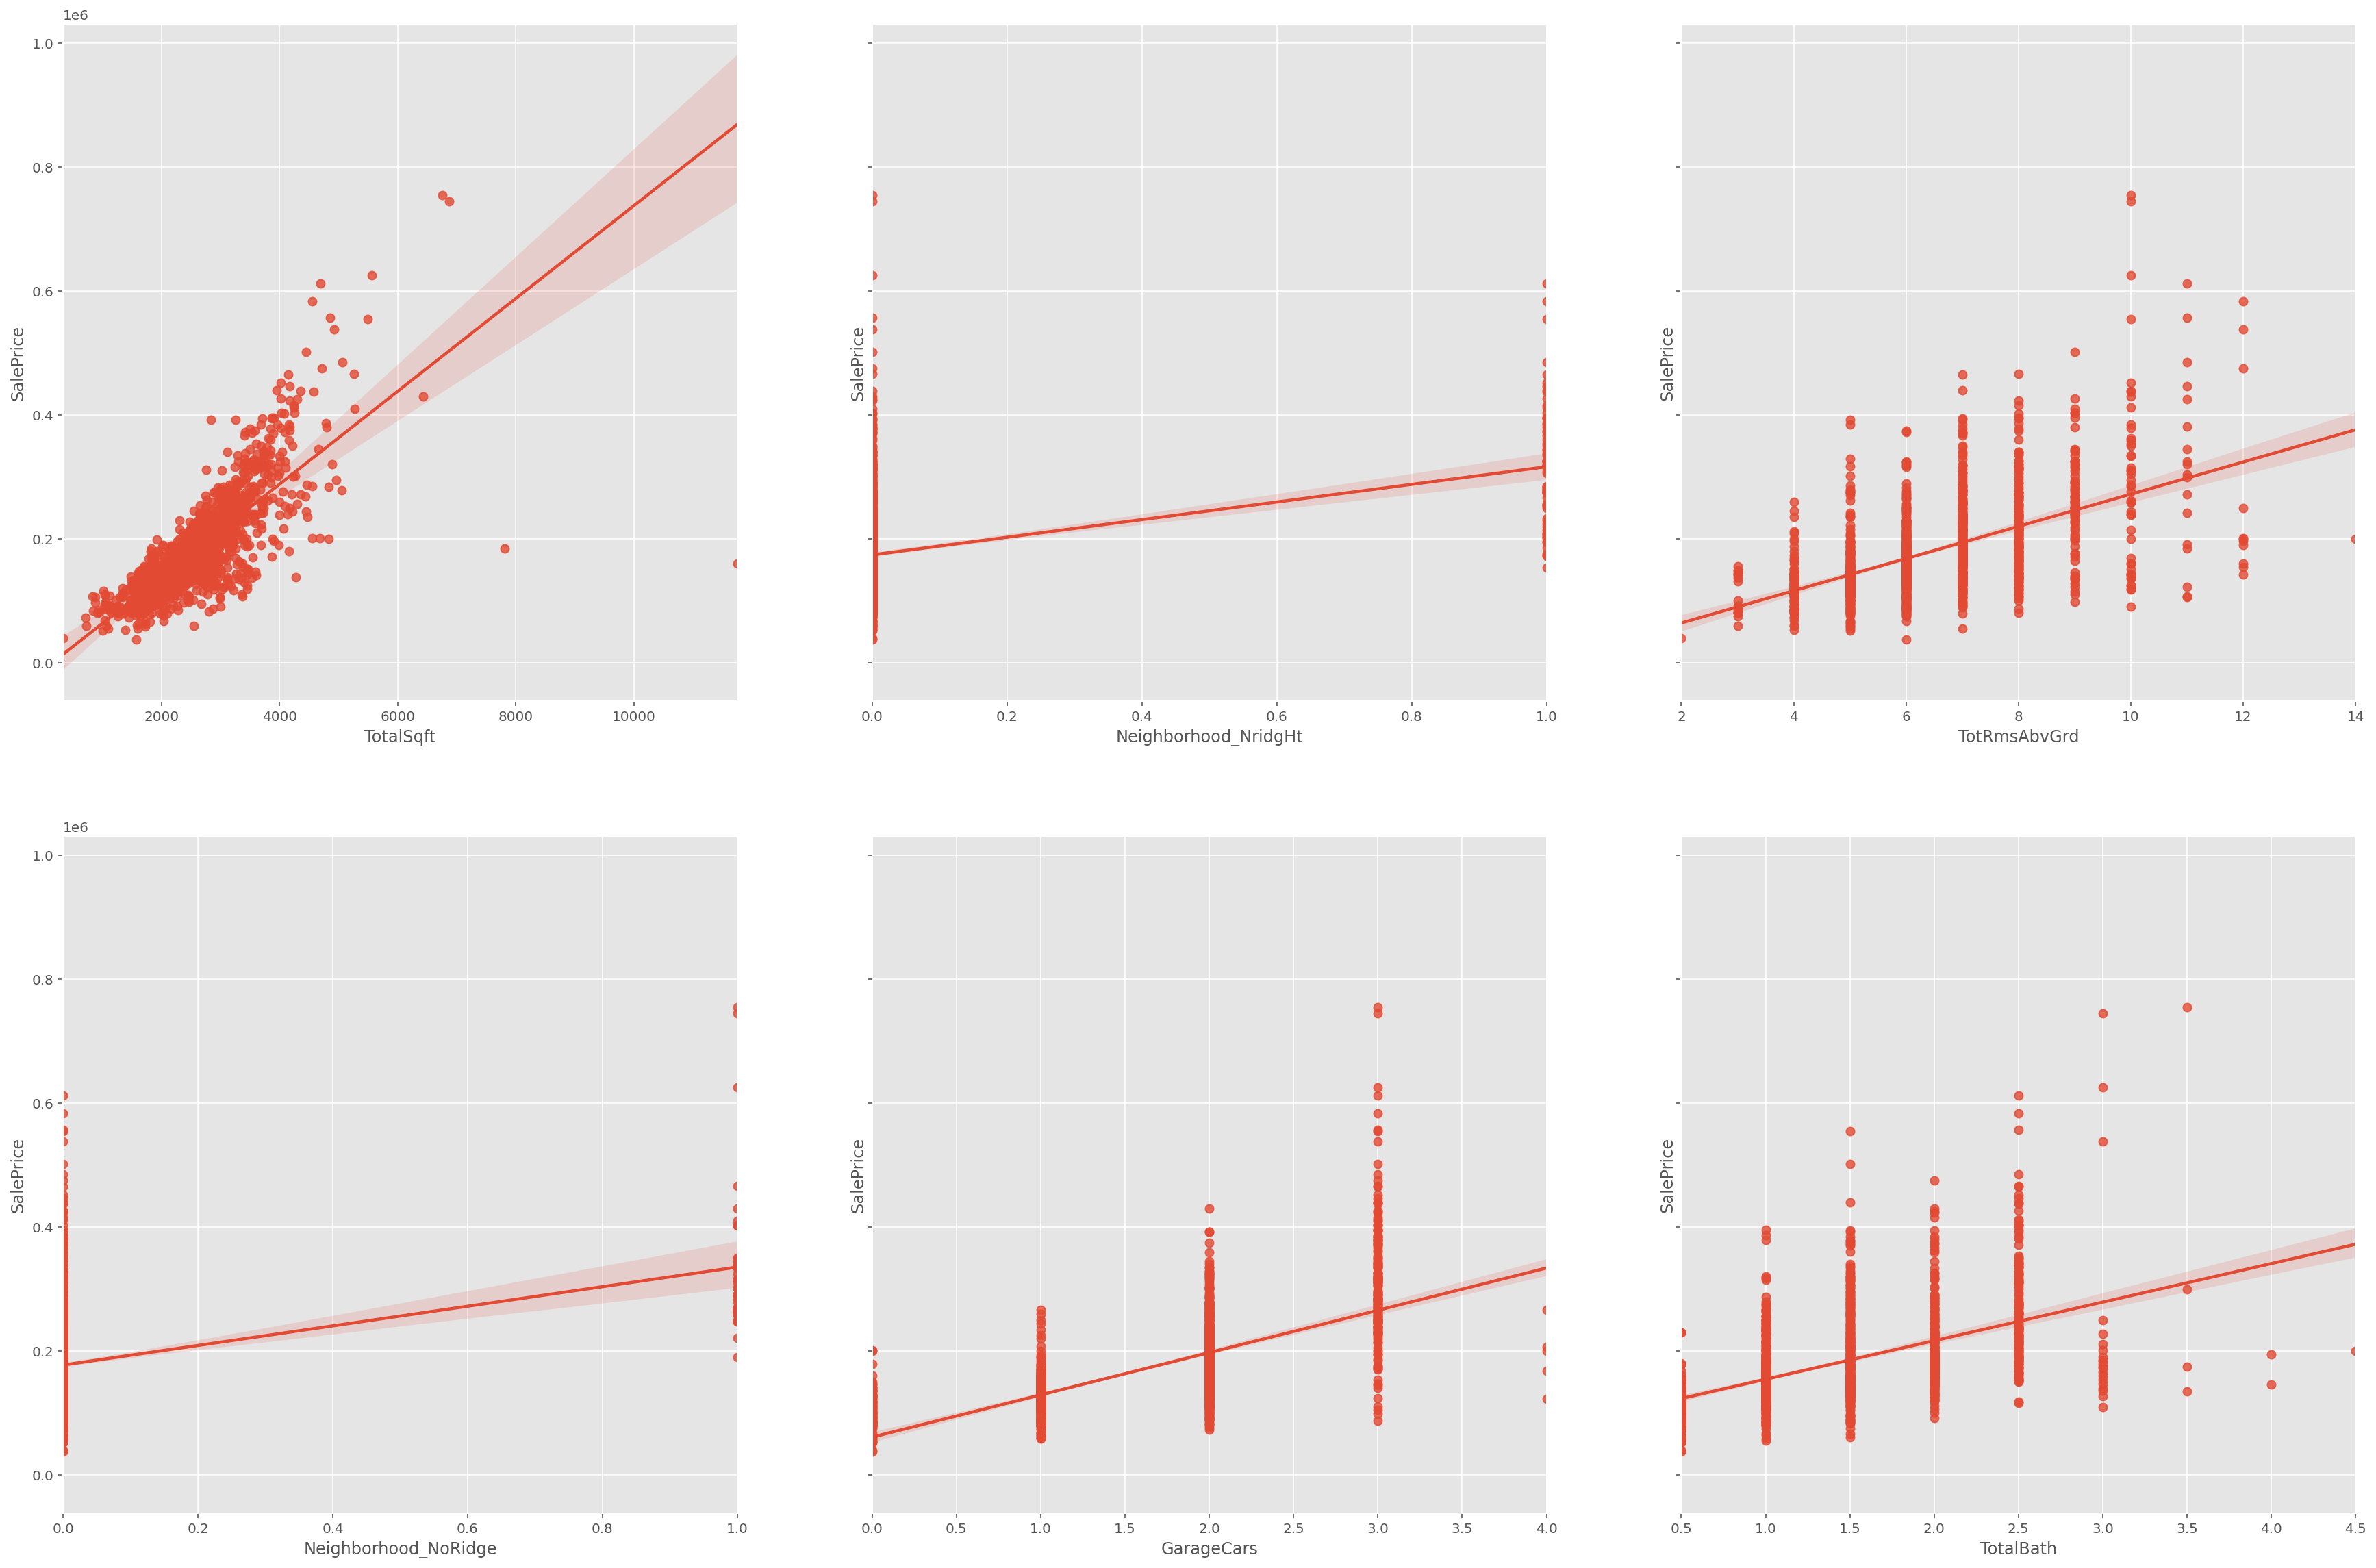

In [463]:
fig, ax = plt.subplots(ncols=3, nrows=2,  figsize=(30, 20), sharey=True)
sns.regplot(x=house_dum['TotalSqft'], y=house_res['SalePrice'], ax=ax[0][0])
sns.regplot(x=house_dum['Neighborhood_NridgHt'], y=house_res['SalePrice'], ax=ax[0][1])
sns.regplot(x=house_dum['TotRmsAbvGrd'], y=house_res['SalePrice'], ax=ax[0][2])
sns.regplot(x=house_dum['Neighborhood_NoRidge'], y=house_res['SalePrice'], ax=ax[1][0])
sns.regplot(x=house_dum['GarageCars'], y=house_res['SalePrice'], ax=ax[1][1])
sns.regplot(x=house_dum['TotalBath'], y=house_res['SalePrice'], ax=ax[1][2])
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# by looking at the residuals of the first model we can see how much of the sales price is missing from 
# our predictions

# our best first model =
# ElasticNet
# Mean cross-validated training score: 0.7918404049717752

# Meaning we have 0.2081595950282248 of the sale price unaccounted for 

In [67]:
# new target to identify is the residuals for all the data
all_residuals = np.append(model_ela_alp.predict(X_train), model_ela_alp.predict(X_test))
all_res = pd.DataFrame(all_residuals, columns=['Predicted'])
all_res['Actual'] = np.append(y_train.values, y_test.values)
all_res['Residuals'] = (all_res['Actual'] - all_res['Predicted'])

In [68]:
# index and id are set at different starter values - change index to datasets Id
all_res.index = house_res.index
all_res.head()

Predicted  Actual     Residuals
Id                                     
1   207702.206229  208500    797.793771
2   205717.892611  181500 -24217.892611
3   210926.870348  223500  12573.129652
4   194774.560046  140000 -54774.560046
5   319778.406719  250000 -69778.406719

In [70]:
# renovatable features are not the ones used in the first model
predictors_reno =  [c for c in house.columns if c not in house_res.columns]
predictors_reno

['Id',
 'Utilities',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal']

In [164]:
house_reno = house.copy()
house_reno = house_reno[['Utilities',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'YrSold',
 'MSZoning']]

In [165]:
# we are still only looking at residential properties
house_reno = house_reno[house_reno.MSZoning != 'C (all)']
house_reno.shape

(1450, 45)

In [166]:
# but we don't need the MSZoning column
house_reno.drop('MSZoning', axis=1)

Utilities  OverallQual  OverallCond RoofStyle RoofMatl Exterior1st  \
0       AllPub            7            5     Gable  CompShg     VinylSd   
1       AllPub            6            8     Gable  CompShg     MetalSd   
2       AllPub            7            5     Gable  CompShg     VinylSd   
3       AllPub            7            5     Gable  CompShg     Wd Sdng   
4       AllPub            8            5     Gable  CompShg     VinylSd   
...        ...          ...          ...       ...      ...         ...   
1455    AllPub            6            5     Gable  CompShg     VinylSd   
1456    AllPub            6            6     Gable  CompShg     Plywood   
1457    AllPub            7            9     Gable  CompShg     CemntBd   
1458    AllPub            5            6       Hip  CompShg     MetalSd   
1459    AllPub            5            6     Gable  CompShg     HdBoard   

     Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond BsmtQual BsmtCond  \
0        VinylSd    BrkFace       196.0        Gd        TA       Gd       TA   
1        MetalSd       None         0.0        TA        TA       Gd       TA   
2        VinylSd    BrkFace       162.0        Gd        TA       Gd       TA   
3        Wd Shng       None         0.0        TA        TA       TA       Gd   
4        VinylSd    BrkFace       350.0        Gd        TA       Gd       TA   
...          ...        ...         ...       ...       ...      ...      ...   
1455     VinylSd       None         0.0        TA        TA       Gd       TA   
1456     Plywood      Stone       119.0        TA        TA       Gd       TA   
1457     CmentBd       None         0.0        Ex        Gd       TA       Gd   
1458     MetalSd       None         0.0        TA        TA       TA       TA   
1459     HdBoard       None         0.0        Gd        TA       TA       TA   

     BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF Heating  \
0             GLQ         706          Unf           0        150    GasA   
1             ALQ         978          Unf           0        284    GasA   
2             GLQ         486          Unf           0        434    GasA   
3             ALQ         216          Unf           0        540    GasA   
4             GLQ         655          Unf           0        490    GasA   
...           ...         ...          ...         ...        ...     ...   
1455          Unf           0          Unf           0        953    GasA   
1456          ALQ         790          Rec         163        589    GasA   
1457          GLQ         275          Unf           0        877    GasA   
1458          GLQ          49          Rec        1029          0    GasA   
1459          BLQ         830          LwQ         290        136    GasA   

     HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0           Ex          Y      SBrkr       856       854             0   
1           Ex          Y      SBrkr      1262         0             0   
2           Ex          Y      SBrkr       920       866             0   
3           Gd          Y      SBrkr       961       756             0   
4           Ex          Y      SBrkr      1145      1053             0   
...        ...        ...        ...       ...       ...           ...   
1455        Ex          Y      SBrkr       953       694             0   
1456        TA          Y      SBrkr      2073         0             0   
1457        Ex          Y      SBrkr      1188      1152             0   
1458        Gd          Y      FuseA      1078         0             0   
1459        Gd          Y      SBrkr      1256         0             0   

     KitchenQual Functional  Fireplaces FireplaceQu GarageFinish GarageQual  \
0             Gd        Typ           0         NaN          RFn         TA   
1             TA        Typ           1          TA          RFn         TA   
2             Gd        Typ           1          TA          RFn         TA   
3

In [167]:
# let's get rid of the nas

house_reno.fillna( {
                    'BsmtQual': 'No_Basement',
                    'BsmtCond': 'No_Basement',
                    'BsmtExposure': 'No_Basement',
                    'BsmtFinType1': 'No_Basement',
                    'BsmtFinType2': 'No_Basement',
                    'BsmtFinType2': 'No_Basement',
                    'LotFrontage': 0,
                    'Alley': 'No_Alley_Access',
                    'FireplaceQu': 'No_Fireplace',
                    'GarageType': 'No_Garage',
                    'GarageFinish': 'No_Garage',
                    'GarageQual': 'No_Garage',
                    'GarageCond': 'No_Garage',
                    'PoolQC': 'No_Pool',
                    'Fence': 'No_Fence',
                    'MiscFeature': 'No_Extra_Features',
                                                        } , inplace=True)

In [168]:
house_reno.fillna( {'Electrical': 'SBrkr'} , inplace=True)
house_reno.fillna( {'GarageYrBlt': 'None'} , inplace=True)
house_reno.fillna( {'MasVnrType': 'None'} , inplace=True)      
house_reno.fillna( {'MasVnrArea': 0} , inplace=True) 

In [169]:
# let's dummify so we can use all columns
house_reno_dum = pd.get_dummies(house_reno)
house_reno_dum

OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0               7            5       196.0         706           0        150   
1               6            8         0.0         978           0        284   
2               7            5       162.0         486           0        434   
3               7            5         0.0         216           0        540   
4               8            5       350.0         655           0        490   
...           ...          ...         ...         ...         ...        ...   
1455            6            5         0.0           0           0        953   
1456            6            6       119.0         790         163        589   
1457            7            9         0.0         275           0        877   
1458            5            6         0.0          49        1029          0   
1459            5            6         0.0         830         290        136   

      1stFlrSF  2ndFlrSF  LowQualFinSF  Fireplaces  WoodDeckSF  OpenPorchSF  \
0          856       854             0           0           0           61   
1         1262         0             0           1         298            0   
2          920       866             0           1           0           42   
3          961       756             0           1           0           35   
4         1145      1053             0           1         192           84   
...        ...       ...           ...         ...         ...          ...   
1455       953       694             0           1           0           40   
1456      2073         0             0           2         349            0   
1457      1188      1152             0           2           0           60   
1458      1078         0             0           0         366            0   
1459      1256         0             0           0         736           68   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  YrSold  \
0                 0          0            0         0        0    2008   
1                 0          0            0         0        0    2007   
2                 0          0            0         0        0    2008   
3               272          0            0         0        0    2006   
4                 0          0            0         0        0    2008   
...             ...        ...          ...       ...      ...     ...   
1455              0          0            0         0        0    2007   
1456              0          0            0         0        0    2010   
1457              0          0            0         0     2500    2010   
1458            112          0            0         0        0    2010   
1459              0          0            0         0        0    2008   

      Utilities_AllPub  Utilities_NoSeWa  RoofStyle_Flat  RoofStyle_Gable  \
0                    1                 0               0                1   
1                    1                 0               0                1   
2                    1                 0               0                1   
3                    1                 0               0                1   
4                    1                 0               0                1   
...                ...               ...             ...              ...   
1455                 1                 0               0                1   
1456                 1                 0               0                1   
1457                 1                 0               0                1   
1458                 1                 0               0                0   
1459                 1                 0               0                1   

      RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  RoofStyle_Shed  \
0                     0              0                  0               0   
1                     0              0                  0               0   
2                     0              0 

In [170]:
house_reno_dum.index = all_res.index

In [171]:
# let's grab those residuals from the first model above 
house_reno_dum['Residuals'] = all_res['Residuals']

In [172]:
# specify target + predictor variables (Train a model on pre-2010 data and evaluate its performance on the 2010 houses)

predictors = house_reno_dum
target = house_reno_dum.pop('Residuals')

In [173]:
# split into x-train and x-test

X_reno_train= house_reno_dum[house_reno_dum['YrSold']<2010]
y_reno_train= house_reno_dum.loc[house_reno_dum[house_reno_dum['YrSold']<2010].index, 'Residuals']
X_reno_test= house_reno_dum[house_reno_dum['YrSold']==2010]
y_reno_test= house_reno_dum.loc[house_reno_dum[house_reno_dum['YrSold']==2010].index, 'Residuals']

In [174]:
X_reno_train= X_reno_train.drop('YrSold', axis=1)
X_reno_test= X_reno_test.drop('YrSold', axis=1)
X_reno_train= X_reno_train.drop('Residuals', axis=1)
X_reno_test= X_reno_test.drop('Residuals', axis=1)

In [175]:
# standardising the variables

scaler = StandardScaler()
X_reno_train_std = pd.DataFrame(scaler.fit_transform(X_reno_train))
X_reno_test_std = pd.DataFrame(scaler.transform(X_reno_test))

In [176]:
# fit a linear regression model
model_lnr_reno = LinearRegression()

# get cross validated scores
scores_reno = cross_val_score(model_lnr_reno, X_reno_train_std, y_reno_train, cv=5)
print("Cross-validated training scores:", scores_reno)
print("Mean cross-validated training scores:", scores_reno.mean())

# fit and evaluate the data on the whole training set
model_lnr_reno.fit(X_reno_train_std, y_reno_train)
print("Training Score:", model_lnr_reno.score(X_reno_train_std, y_reno_train))

# evaluate the data on the test set
print("Test Score:", model_lnr_reno.score(X_reno_test_std, y_reno_test))

Cross-validated training scores: [-7.07519814e+26 -1.09737484e+27 -1.73205179e+26 -4.77191963e+25
 -3.19037036e+27]
Mean cross-validated training scores: -1.0432378798095062e+27
Training Score: 0.08690273117030278
Test Score: -4.838168216661207e+23


In [84]:
# our training score is higher than our test score (still low at only 0.09) meaning our model learnt
# from our training data but our test score is negative denoting a bad model that doesn't generalise well.

In [177]:
# as elasticnet performed the best for us last time lets try this first time here
model_reno_ela = ElasticNetCV(alphas=np.logspace(-4, 4, 100), 
                     l1_ratio=np.array([.1, .5, .7, .9, .95, .99, 1]),
                     cv=5, n_jobs=2, max_iter=100000)
# fit the model
model_reno_ela.fit(X_reno_train_std, y_reno_train)
# get the best alpha
print('Best alpha:', model_reno_ela.alpha_)
# get the best l1-ratio
print('Best l1-ratio:', model_reno_ela.l1_ratio_)

Best alpha: 291.5053062825182
Best l1-ratio: 0.95


In [178]:
alpha_reno_ela = model_reno_ela.alpha_
l1_ratio_reno_ela = model_reno_ela.l1_ratio_

model_reno_ela_alp = ElasticNet(alpha=alpha_reno_ela, l1_ratio=l1_ratio_reno_ela)

# get cross validated scores
scores_reno_ela = cross_val_score(model_reno_ela_alp, X_reno_train_std, y_reno_train, cv=5)
print("Cross-validated training scores:", scores_reno_ela)
print("Mean cross-validated training score:", scores_reno_ela.mean())
# fit and evaluate the data on the whole training set
model_reno_ela_alp.fit(X_reno_train_std, y_reno_train)
print("Training Score:", model_reno_ela_alp.score(X_reno_train_std, y_reno_train))
# evaluate the data on the test set
print("Test Score:", model_reno_ela_alp.score(X_reno_test_std, y_reno_test))

Cross-validated training scores: [-0.01115073  0.00081243 -0.00062829  0.00340703 -0.00423429]
Mean cross-validated training score: -0.0023587691085176
Training Score: 0.011833525715583382
Test Score: -0.003170171629645724


In [ ]:
# our training and test scores are closer than above and our mean cvs score has improved
# as the l1 ratio came up at 0.95 let's try a lasso model

In [179]:
# create a LassoCV model instance
model_reno_las = LassoCV(alphas=np.logspace(-3, 1, 30), cv=5)

# fit the model
model_reno_las.fit(X_reno_train_std, y_reno_train)

# get the best alpha
print('Best alpha:', model_reno_las.alpha_)

# evaluate on the training set
print('Training score:', model_reno_las.score(X_reno_train_std, y_reno_train))

# evaluate on the test set
print("Test Score:", model_reno_las.score(X_reno_test_std, y_reno_test))

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574892632.3380127, tolerance: 115913348.09220763
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1206735623.6345215, tolerance: 113414391.94142137
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128860980.52416992, tolerance: 113414391.94142137
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-pac

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 756868748.057251, tolerance: 111996618.8033087
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 752348709.7030029, tolerance: 111996618.8033087
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 748943253.2381592, tolerance: 111996618.8033087
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/

Best alpha: 10.0
Training score: 0.11919674358371568
Test Score: -0.6620936426667505


/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312577257.6772461, tolerance: 111922087.41631766
  model = cd_fast.enet_coordinate_descent_gram(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533728154.5600586, tolerance: 136234609.89436764
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Best alpha: 10.0
# Training score: 0.11919674358371568
# Test Score: -0.6620936426667505

In [180]:
alpha_reno = model_reno_las.alpha_

# create a Lasso model instance
model_reno_las_alpha = Lasso(alpha=alpha_reno)

# get cross validated scores
scores_reno_las_alpha = cross_val_score(model_reno_las_alpha, X_reno_train_std, y_reno_train, cv=5)
print("Cross-validated training scores:", scores_reno_las_alpha)
print("Mean cross-validated training score:", scores_reno_las_alpha.mean())
# fit and evaluate the data on the whole training set
model_reno_las_alpha.fit(X_reno_train_std, y_reno_train)
print("Training Score:", model_reno_las_alpha.score(X_reno_train_std, y_reno_train))
# evaluate the data on the test set
print("Test Score:", model_reno_las_alpha.score(X_reno_test_std, y_reno_test))

/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574892632.3095703, tolerance: 115913348.09220763
  model = cd_fast.enet_coordinate_descent(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1206735623.612671, tolerance: 113414391.94142137
  model = cd_fast.enet_coordinate_descent(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 821855780.9029541, tolerance: 111996618.8033087
  model = cd_fast.enet_coordinate_descent(


Cross-validated training scores: [-0.2918094  -0.42699623 -0.10600342 -0.0247877  -0.35692494]
Mean cross-validated training score: -0.2413043379487363
Training Score: 0.11919674358371568
Test Score: -0.6620936426667505


/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 920774594.5101318, tolerance: 91644985.15962416
  model = cd_fast.enet_coordinate_descent(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312577257.67907715, tolerance: 111922087.41631766
  model = cd_fast.enet_coordinate_descent(
/Users/KStamp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533728154.5600586, tolerance: 136234609.89436764
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Cross-validated training scores: [-0.2918094  -0.42699623 -0.10600342 -0.0247877  -0.35692494]
# Mean cross-validated training score: -0.2413043379487363
# Training Score: 0.11919674358371568
# Test Score: -0.6620936426667505

In [ ]:
# our training score worsened but our mean cvs score and test score improved (although still negative results)

In [200]:
# let's look at the coefficients to see what lasso removed
df_coef_reno_alp_las = pd.DataFrame(model_reno_las_alpha.coef_, index=X_reno_train.columns,
                       columns=['coefficients'])

df_coef_reno_alp_las['coef_abs'] = df_coef_reno_alp_las.coefficients.abs()

df_coef_reno_alp_las.sort_values('coef_abs', ascending=False)

# the lasso model removed 28 features that were 0 coefficients 
# we can also see that 'Exterior' features appear to be of the strongest correlations

coefficients      coef_abs
MiscFeature_Gar2               1.652492e+04  1.652492e+04
MiscVal                       -1.581219e+04  1.581219e+04
Exterior2nd_MetalSd            7.192599e+03  7.192599e+03
ExterQual_Ex                  -4.890149e+03  4.890149e+03
Exterior1st_MetalSd           -4.890055e+03  4.890055e+03
RoofStyle_Shed                -4.777851e+03  4.777851e+03
BsmtUnfSF                      4.409931e+03  4.409931e+03
BsmtFinSF2                     3.925552e+03  3.925552e+03
Fireplaces                    -3.765921e+03  3.765921e+03
Exterior2nd_Wd Sdng            3.380994e+03  3.380994e+03
KitchenQual_Gd                -3.335305e+03  3.335305e+03
Exterior1st_Wd Sdng           -3.334714e+03  3.334714e+03
Exterior2nd_HdBoard           -3.328928e+03  3.328928e+03
Exterior1st_CemntBd            3.311557e+03  3.311557e+03
Exterior1st_HdBoard            3.251707e+03  3.251707e+03
BsmtQual_No_Basement           2.857468e+03  2.857468e+03
RoofMatl_CompShg               2.710217e+03  2.710217e+03
OverallCond                    2.613116e+03  2.613116e+03
Exterior1st_Plywood            2.564567e+03  2.564567e+03
MiscFeature_No_Extra_Features -2.506880e+03  2.506880e+03
WoodDeckSF                     2.284313e+03  2.284313e+03
Heating_Wall                  -2.238692e+03  2.238692e+03
Exterior2nd_CmentBd           -2.220371e+03  2.220371e+03
Exterior1st_WdShing            2.093689e+03  2.093689e+03
PavedDrive_Y                  -2.078093e+03  2.078093e+03
BsmtQual_Fa                   -2.030317e+03  2.030317e+03
BsmtFinType1_GLQ               2.011574e+03  2.011574e+03
1stFlrSF                      -1.937349e+03  1.937349e+03
BsmtQual_Ex                    1.931352e+03  1.931352e+03
Exterior2nd_ImStucc           -1.893218e+03  1.893218e+03
Exterior1st_Stone              1.888658e+03  1.888658e+03
ExterQual_TA                   1.835425e+03  1.835425e+03
GarageQual_Po                  1.835344e+03  1.835344e+03
2ndFlrSF                       1.824056e+03  1.824056e+03
Functional_Mod                -1.727708e+03  1.727708e+03
RoofStyle_Flat                -1.725782e+03  1.725782e+03
ExterQual_Fa                   1.545004e+03  1.545004e+03
ExterCond_Gd                   1.534462e+03  1.534462e+03
RoofMatl_Membran               1.449741e+03  1.449741e+03
OverallQual                    1.418341e+03  1.418341e+03
MSZoning_RL                    1.409820e+03  1.409820e+03
Exterior2nd_Plywood           -1.407364e+03  1.407364e+03
BsmtFinType1_LwQ              -1.384679e+03  1.384679e+03
Heating_Grav                   1.371497e+03  1.371497e+03
Exterior2nd_AsbShng            1.369284e+03  1.369284e+03
FireplaceQu_No_Fireplace      -1.339245e+03  1.339245e+03
Exterior2nd_Wd Shng           -1.338983e+03  1.338983e+03
MiscFeature_TenC               1.318177e+03  1.318177e+03
MasVnrType_Stone               1.304624e+03  1.304624e+03
KitchenQual_Ex                 1.287935e+03  1.287935e+03
HeatingQC_Ex                   1.278745e+03  1.278745e+03
GarageCond_Po                 -1.273100e+03  1.273100e+03
FireplaceQu_Gd                 1.255582e+03  1.255582e+03
ExterCond_Ex                  -1.226173e+03  1.226173e+03
RoofMatl_Metal                 1.217745e+03  1.217745e+03
GarageQual_Fa                  1.171124e+03  1.171124e+03
CentralAir_N                  -1.166122e+03  1.166122e+03
BsmtFinType1_Unf              -1.154455e+03  1.154455e+03
BsmtQual_TA                   -1.151004e+03  1.151004e+03
MasVnrType_None               -1.099112e+03  1.099112e+03
RoofMatl_ClyTile               1.079499e+03  1.079499e+03
GarageQual_Gd                  1.075762e+03  1.075762e+03
MasVnrArea                    -1.012294e+03  1.012294e+03
Functional_Maj1                9.864871e+02  9.864871e+02
PoolQC_Ex                      9.842075e+02  9.842075e+02
BsmtFinType1_Rec              -9.584853e+02  9.584853e+02
Electrical_FuseF               9.484112e+02  9.484112e+02
Heating_GasW                   9.422692e+02  9.422692e+02
BsmtFinSF1                   

In [ ]:
# let's check the Ridge model

In [185]:
# create a RidgeCV model instance
model_reno_ridge = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
# fit the model
model_reno_ridge.fit(X_reno_train_std, y_reno_train)
# get the best alpha
print('Best alpha:', model_reno_ridge.alpha_)
# evaluate on the training set
print('Training score:', model_reno_ridge.score(X_reno_train_std, y_reno_train))
# evaluate on the test set
print("Test Score:", model_reno_ridge.score(X_reno_test_std, y_reno_test))

Best alpha: 10000.0
Training score: 0.024642254331900038
Test Score: -0.0020546592867458635


In [186]:
alpha_reno_ridge = model_reno_ridge.alpha_

# create a Ridge model instance
model_reno_alp_ridge = Ridge(alpha=alpha_reno_ridge)

# get cross validated scores
scores_reno_alp = cross_val_score(model_reno_alp_ridge, X_reno_train_std, y_reno_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores_reno_alp.mean())

# fit and evaluate the data on the whole training set
model_reno_alp_ridge.fit(X_reno_train_std, y_reno_train)
print("Training Score:", model_reno_alp_ridge.score(X_reno_train_std, y_reno_train))
# evaluate the data on the test set
print("Test Score:", model_reno_alp_ridge.score(X_reno_test_std, y_reno_test))

Cross-validated training scores: [0.86295628 0.81646333 0.85480135 0.73714733 0.80967524 0.75623276
 0.85879285 0.80730967 0.57090878 0.82181621]
Mean cross-validated training score: -0.0032875513916062137
Training Score: 0.024642254331900038
Test Score: -0.0020546592867458635


In [188]:
# Scores:

print('Lasso')
print("Mean cross-validated training score:", scores_reno_las_alpha.mean())
print("Training Score:", model_reno_las_alpha.score(X_reno_train_std, y_reno_train), '*Best*')
print("Test Score:", model_reno_las_alpha.score(X_reno_test_std, y_reno_test))
print('\n')

print('Ridge')
print("Mean cross-validated training score:", scores_reno_alp.mean())
print("Training Score:", model_reno_alp_ridge.score(X_reno_train_std, y_reno_train))
print("Test Score:", model_reno_alp_ridge.score(X_reno_test_std, y_reno_test), '*Best*')
print('\n')

print('ElasticNet')
print("Mean cross-validated training score:", scores_reno_ela.mean(), '*Best*')
print("Training Score:", model_reno_ela_alp.score(X_reno_train_std, y_reno_train))
print("Test Score:", model_reno_ela_alp.score(X_reno_test_std, y_reno_test))
print("\n")

print("Intercept for ElasticNet:", model_reno_ela_alp.intercept_)

Lasso
Mean cross-validated training score: -0.2413043379487363
Training Score: 0.11919674358371568 *Best*
Test Score: -0.6620936426667505


Ridge
Mean cross-validated training score: -0.0032875513916062137
Training Score: 0.024642254331900038
Test Score: -0.0020546592867458635 *Best*


ElasticNet
Mean cross-validated training score: -0.0023587691085176 *Best*
Training Score: 0.011833525715583382
Test Score: -0.003170171629645724


Intercept for ElasticNet: -119.82135529042861


In [ ]:
# Although our training scores are small in value, they are are postive. However, all of our test scores are 
# negative, denoting to a poor fitting model, even our best model, again using elasticnet, denotes a poor fit,
# as we can see on the graph below.

# The houses before 2010 (training set) could have had more renovatable features which derived more of a 
# positive correlation to 'SalePrice', and there could have been a change in this in 2010 (test set), 
# which would also be worth investigating further.

# For our best model (ElasticNet) the intercept is the $ of th residuals for the mean of the features
# which would be zero. Which doesn't really make sense in this case. We should stick to comparing the model
# using a constant like in the graph below.

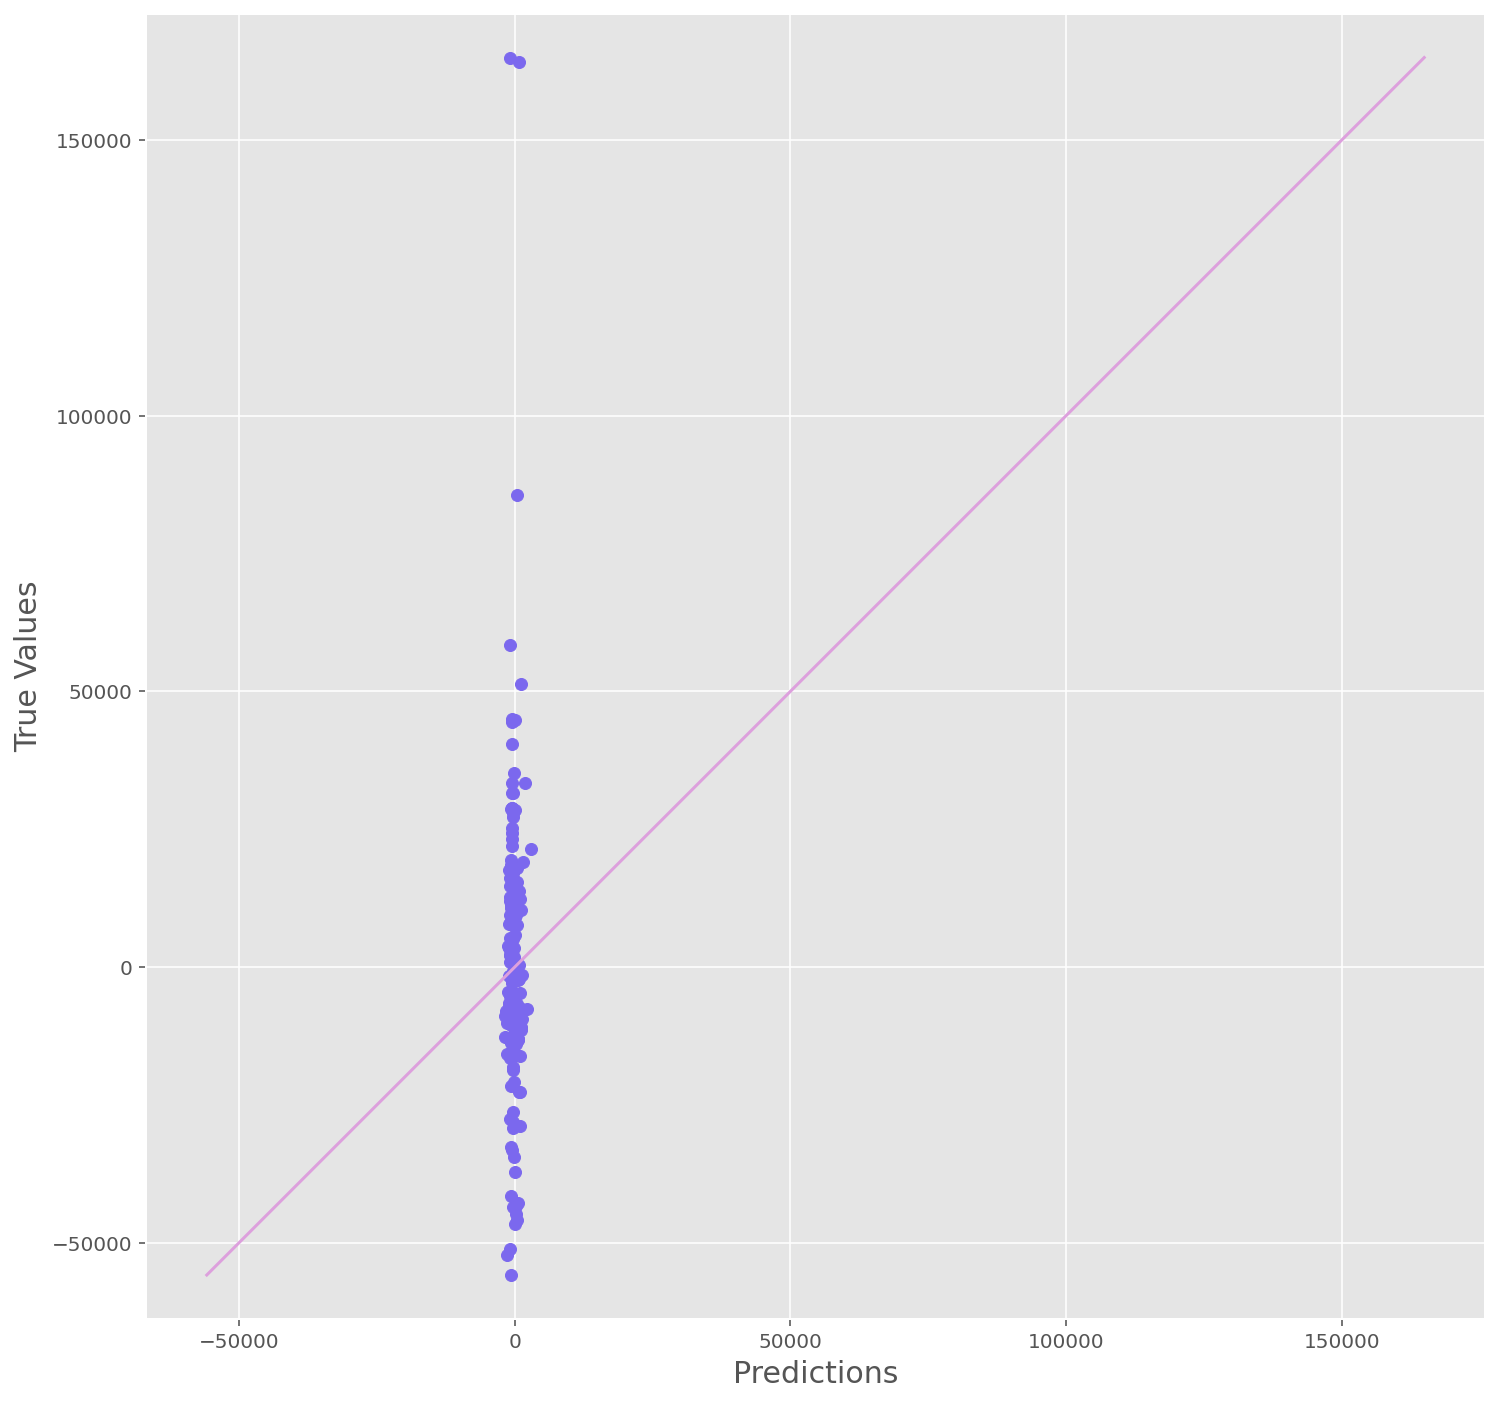

In [189]:
plt.figure(figsize=(12,12))
plt.scatter(model_reno_ela_alp.predict(X_reno_test_std), y_reno_test, c='mediumslateblue')

p1 = max(max(model_reno_ela_alp.predict(X_reno_test_std)), max(y_reno_test))
p2 = min(min(model_reno_ela_alp.predict(X_reno_test_std)), min(y_reno_test))
plt.plot([p1, p2], [p1, p2], 'plum')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.
Investigate how much of the variance in price remaining is explained by these features.

In [ ]:
# Well, we did technically have a 'Best' model so we can look at which renovatable features would give us the
# better understanding of the difference in price from the first model.

In [201]:
en_best = pd.DataFrame(model_reno_ela_alp.coef_, index=X_reno_train.columns,
                       columns=['coefficients'])
en_best['coef_abs'] = en_best.coefficients.abs()

pd.set_option('display.max_rows', 500)
en_best.sort_values('coefficients', ascending=False)

coefficients    coef_abs
PavedDrive_N                     117.877956  117.877956
RoofMatl_CompShg                 112.369032  112.369032
KitchenQual_Ex                   104.761182  104.761182
WoodDeckSF                        84.735173   84.735173
Heating_Grav                      83.926924   83.926924
BsmtFinSF2                        83.625249   83.625249
BsmtQual_Ex                       80.857124   80.857124
ExterCond_Gd                      80.131112   80.131112
OverallCond                       77.785359   77.785359
Exterior2nd_MetalSd               76.203012   76.203012
ExterQual_Fa                      72.500584   72.500584
Exterior1st_MetalSd               61.808951   61.808951
GarageQual_Po                     57.844754   57.844754
MiscFeature_No_Extra_Features     57.785289   57.785289
FireplaceQu_Ex                    57.091563   57.091563
GarageQual_Fa                     54.511394   54.511394
MasVnrType_Stone                  53.447253   53.447253
PavedDrive_P                      52.363684   52.363684
RoofStyle_Mansard                 51.685073   51.685073
Exterior2nd_AsphShn               50.843122   50.843122
Exterior1st_Stone                 50.737134   50.737134
KitchenQual_Fa                    46.751780   46.751780
Exterior2nd_AsbShng               46.487081   46.487081
BsmtFinType2_No_Basement          45.687112   45.687112
Exterior1st_CemntBd               43.322896   43.322896
BsmtQual_No_Basement              42.142574   42.142574
BsmtCond_No_Basement              42.142539   42.142539
BsmtFinType1_No_Basement          42.142526   42.142526
Functional_Typ                    41.874788   41.874788
Heating_GasW                      41.184798   41.184798
GarageCond_Po                     37.945384   37.945384
Exterior2nd_CmentBd               37.654296   37.654296
2ndFlrSF                          37.361333   37.361333
RoofStyle_Shed                    32.600818   32.600818
BsmtFinType2_LwQ                  32.481813   32.481813
GarageCond_Fa                     32.105556   32.105556
Functional_Maj1                   31.543057   31.543057
LowQualFinSF                      31.154624   31.154624
Exterior1st_AsbShng               30.899470   30.899470
PoolQC_Ex                         29.137899   29.137899
KitchenQual_TA                    28.422470   28.422470
HeatingQC_Ex                      26.926251   26.926251
FireplaceQu_Gd                    26.884059   26.884059
Heating_OthW                      25.076276   25.076276
Exterior1st_CBlock                25.054390   25.054390
Exterior2nd_CBlock                25.054382   25.054382
Exterior1st_BrkFace               22.917945   22.917945
Fence_GdPrv                       22.531242   22.531242
BsmtFinType2_Rec                  21.939227   21.939227
HeatingQC_Fa                      21.116995   21.116995
GarageCond_Ex                     20.972907   20.972907
BsmtUnfSF                         20.407423   20.407423
GarageQual_Ex                     19.771196   19.771196
Electrical_FuseF                  19.661375   19.661375
Fence_MnPrv                       18.861623   18.861623
BsmtFinType2_GLQ                  18.029017   18.029017
ExterQual_TA                      17.474417   17.474417
RoofStyle_Hip                     16.253127   16.253127
GarageFinish_Unf                  14.110327   14.110327
Exterior2nd_Stone                 13.325151   13.325151
Functional_Sev                    13.108231   13.108231
PoolArea                          12.494715   12.494715
Electrical_Mix                    11.225947   11.225947
ExterCond_Fa                      11.106482   11.106482
GarageQual_Gd                     10.195546   10.195546
RoofStyle_Gambrel                  8.676927    8.676927
GarageCond_No_Garage               8.341170    8.341170
GarageQual_No_Garage               8.341117    8.341117
GarageFinish_No_Garage             8.341090    8.341090
BsmtFinType1_GLQ                   7.868034    7.868034
FireplaceQu_Fa                     6.480095    6.480095

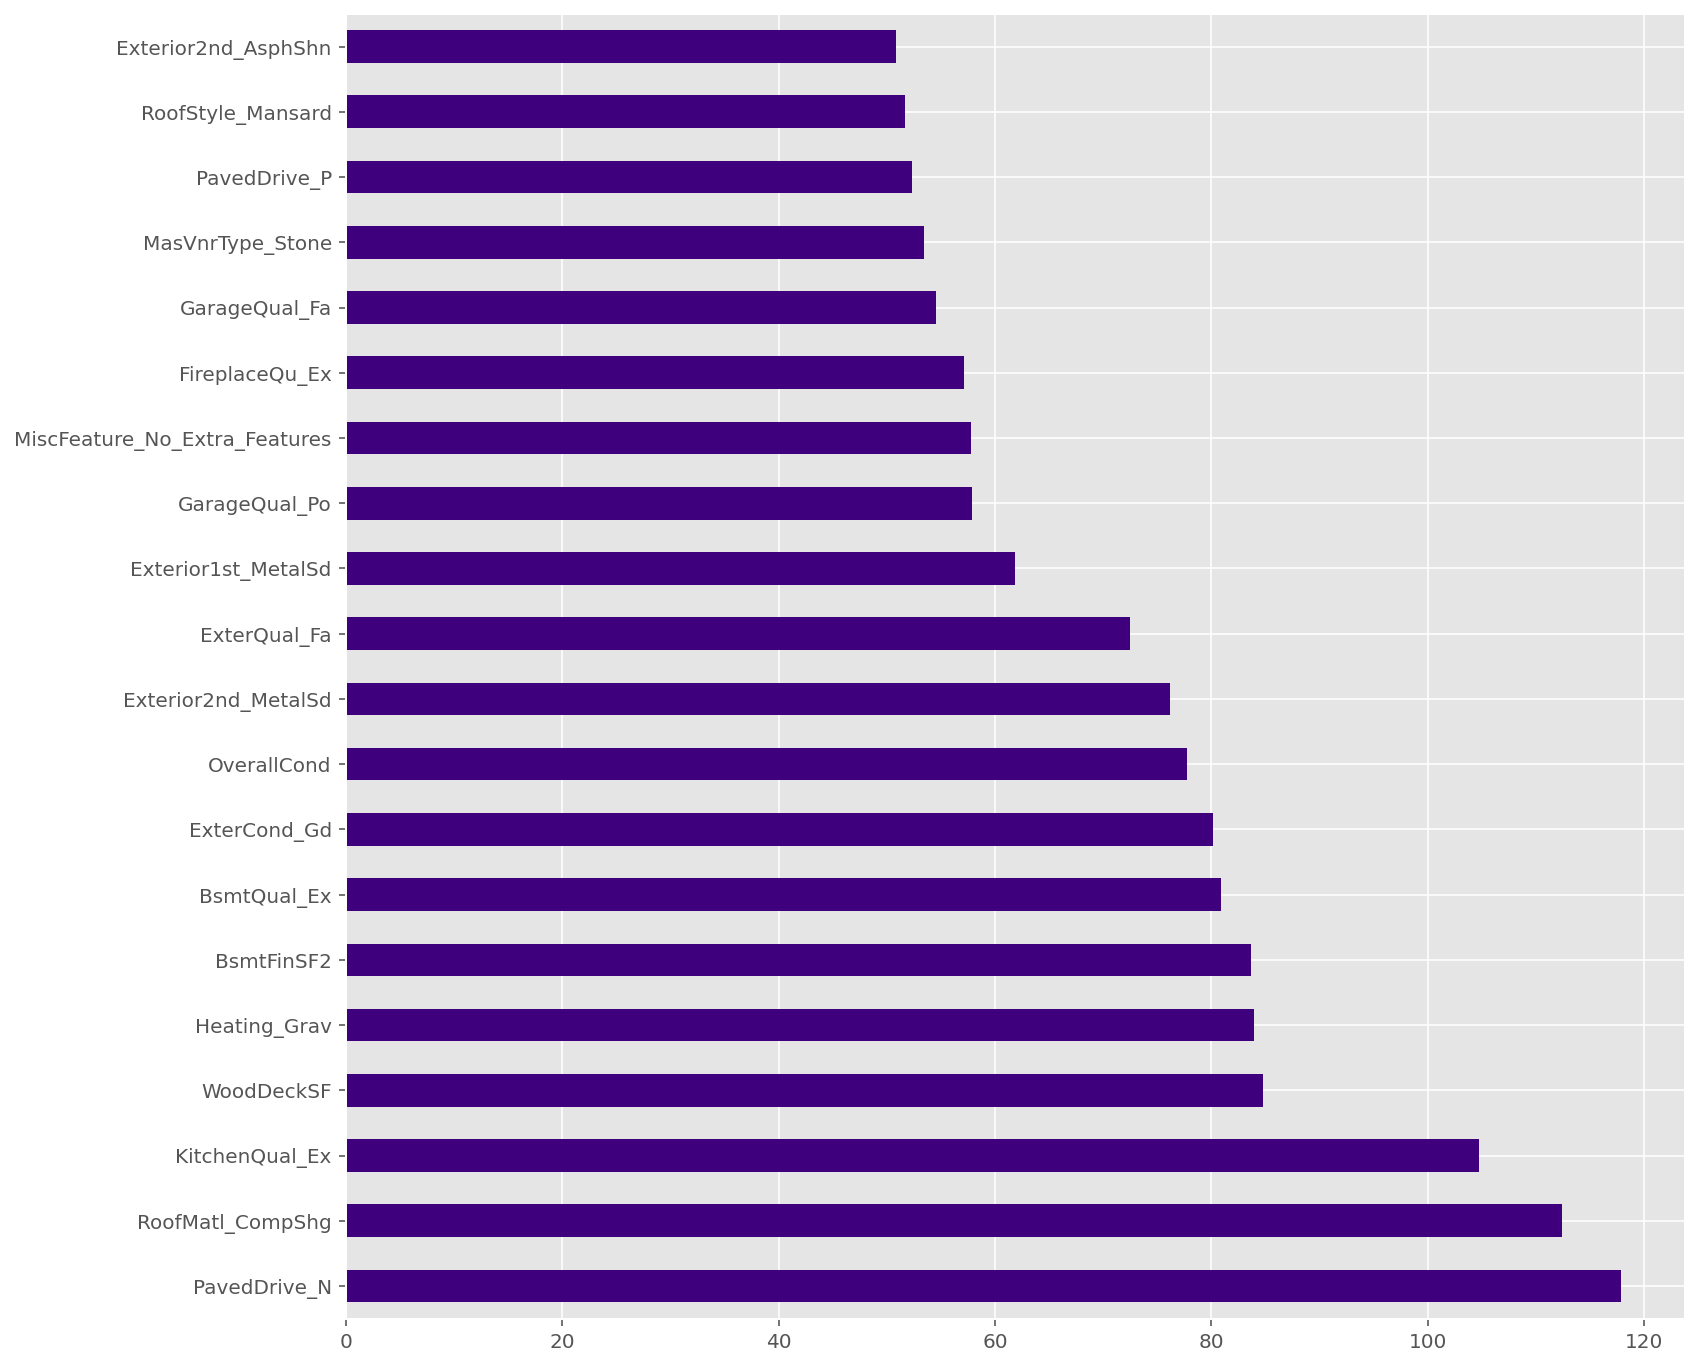

In [191]:
fig = plt.figure(figsize=(12, 12))
en_best['coefficients'].sort_values(ascending=False).head(20).plot(kind='barh', cmap='Purples_r');

In [ ]:
# What we can see here is that alot of the 'Exterior' features have a positive impact on filling in the gap 
# between our first model and the SalePrice, which makes sense as alot of the fixed features were based on
# interior sqft and layout.

# Top features were:
# PavedDrive (N) - Dirt / Gravel
# Roof Material - Standard (Composite) Shingle
# Kitchen Quality - Excellent
# Wood Deck Square Footage
# Heating - Gravity Furnace

# Meaning that having or renovating a paveddrive with dirt and gravel, having or renovating a composite 
# shingle roof, having or renovating a kitchen to an excellent quality, having or renovating a wood deck
# or having or renovating to gravity furnace heating will help to improve the 'SalePrice' missing from 
# having the fixed features from the first model.

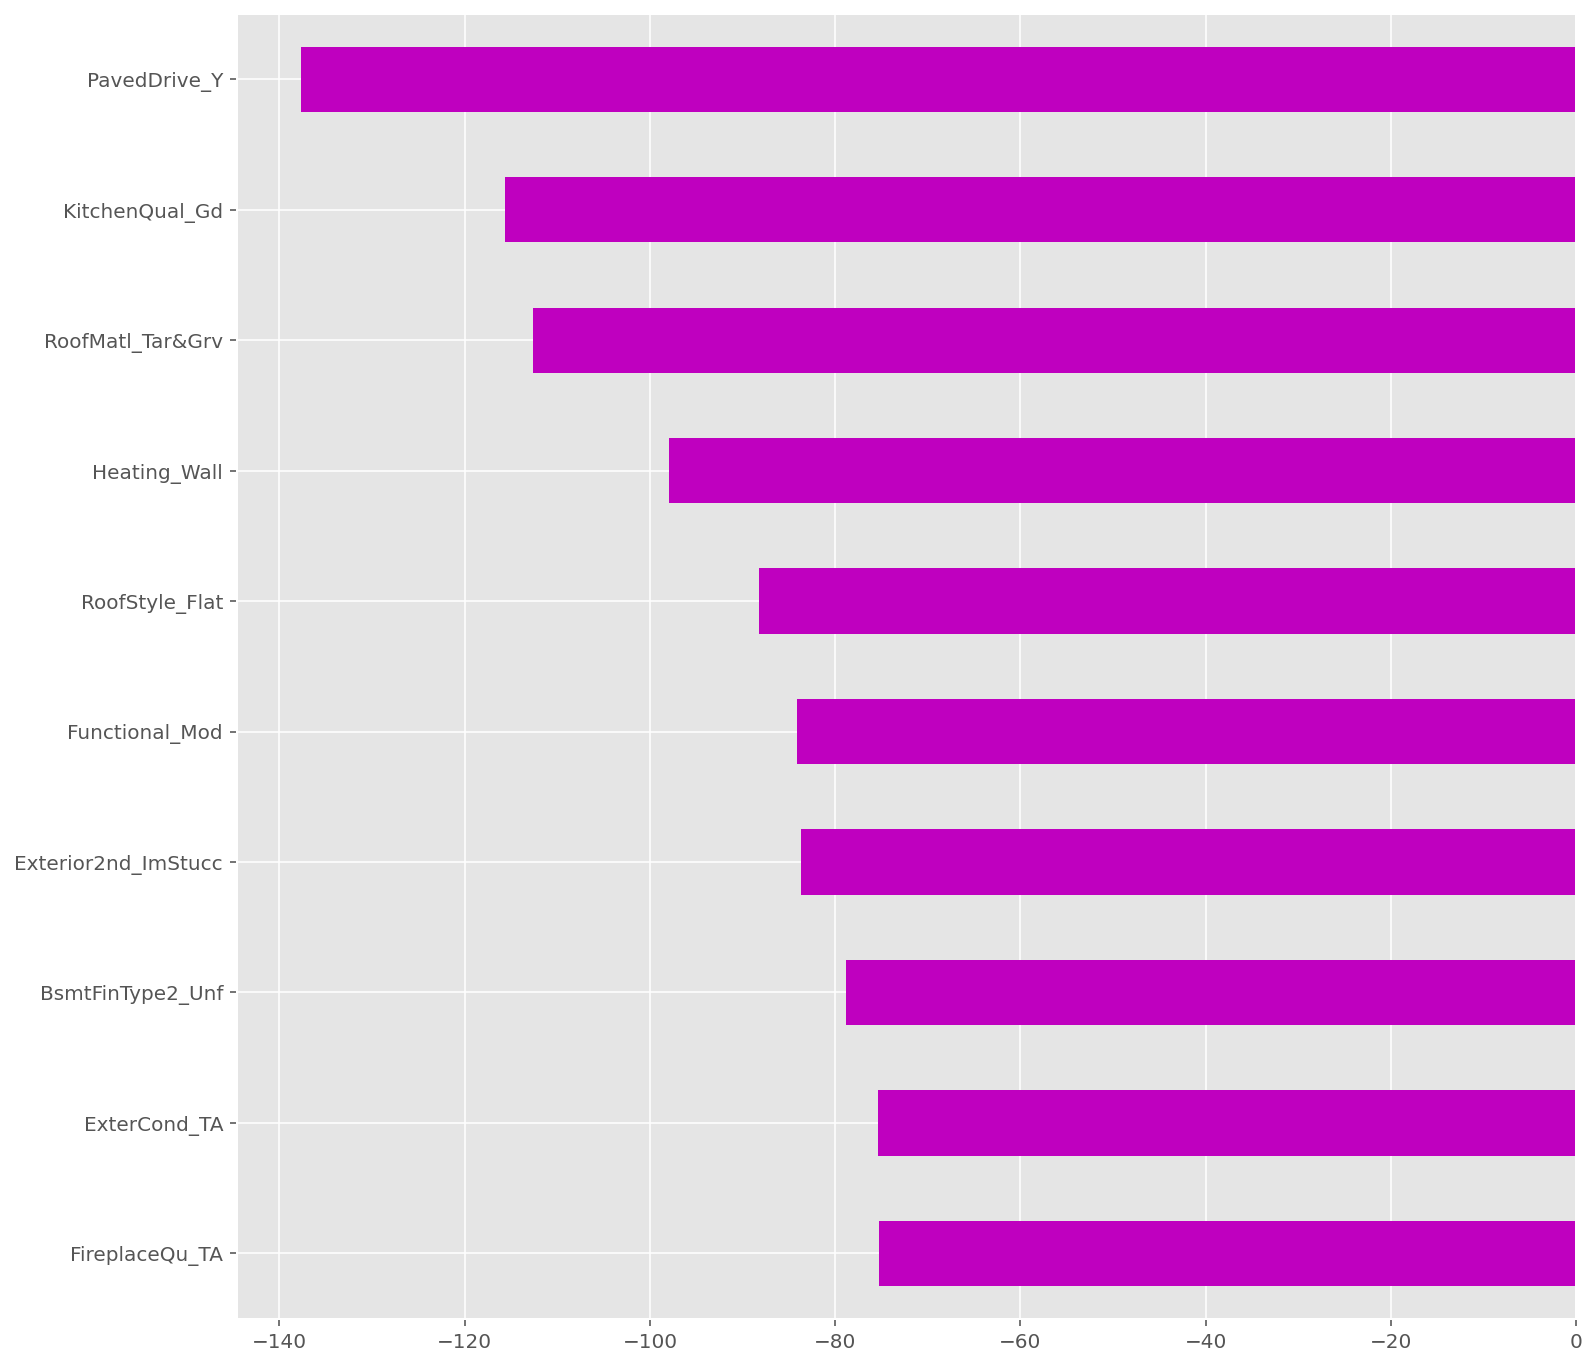

In [195]:
fig = plt.figure(figsize=(12, 12))
en_best['coefficients'].sort_values(ascending=False).tail(10).plot(kind='barh', color='m');

In [ ]:
# The least effective features were:
# Paved Drive - Yes
# Kitchen Quality - Good
# Roof Material - Gravel & Tar
# Heating - Wall furnace
# Roofstyle - Flat

# My advice from the effect of these coefficients would be if you have a paved drive - make sure it's dirt 
# and gravel, if you have a good quality kitchen - make it excellent, if you have a roof with tar and gravel -
# renovate to composite shingle, if you have wall furnace heating - renovate to a gravity furnace and if you 
# have a flat roofstyle renovate to a mansard roof style, in order to get the best price after renovating
# a property.

Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# From the graph above we can see that this is a poor fitting model, therefore I would not use it to try and 
# recover the missing amount of 'SalePrice' from our first model. It is likely that there are other factors
# that influence the SalePrice more. 

In [ ]:
# My next steps would be to either try polynomial features or look for another model that would be a better 
# fit.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [307]:
# breaking from the original data with .copy()
house_ab = house.copy()

In [308]:
# checking for any obvious correlations between abnormal sale and any other feature visually
house_ab[(house_ab['SaleCondition'] == 'Abnorml')].head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
3    4          70       RL         60.0     9550   Pave   NaN      IR1   
8    9          50       RM         51.0     6120   Pave   NaN      Reg   
19  20          20       RL         70.0     7560   Pave   NaN      Reg   
38  39          20       RL         68.0     7922   Pave   NaN      Reg   
40  41          20       RL         84.0     8658   Pave   NaN      Reg   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
3          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
8          Lvl    AllPub    Inside       Gtl      OldTown     Artery   
19         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
38         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
40         Lvl    AllPub    Inside       Gtl        NAmes       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
3        Norm     1Fam     2Story            7            5       1915   
8        Norm     1Fam     1.5Fin            7            5       1931   
19       Norm     1Fam     1Story            5            6       1958   
38       Norm     1Fam     1Story            5            7       1953   
40       Norm     1Fam     1Story            6            5       1965   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
3           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
8           1950     Gable  CompShg     BrkFace     Wd Shng       None   
19          1965       Hip  CompShg     BrkFace     Plywood       None   
38          2007     Gable  CompShg     VinylSd     VinylSd       None   
40          1965     Gable  CompShg     Wd Sdng     Wd Sdng    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
3          0.0        TA        TA     BrkTil       TA       Gd           No   
8          0.0        TA        TA     BrkTil       TA       TA           No   
19         0.0        TA        TA     CBlock       TA       TA           No   
38         0.0        TA        Gd     CBlock       TA       TA           No   
40       101.0        TA        TA     CBlock       TA       TA           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
3           ALQ         216          Unf           0        540          756   
8           Unf           0          Unf           0        952          952   
19          LwQ         504          Unf           0        525         1029   
38          GLQ         731          Unf           0        326         1057   
40          Rec         643          Unf           0        445         1088   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
3     GasA        Gd          Y      SBrkr       961       756             0   
8     GasA        Gd          Y      FuseF      1022       752             0   
19    GasA        TA          Y      SBrkr      1339         0             0   
38    GasA        TA          Y      SBrkr      1057         0             0   
40    GasA        Ex          Y      SBrkr      1324         0             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
3        1717             1             0         1         0             3   
8        1774             0             0         2         0             2   
19       1339             0             0         1         0             3   
38       1057             1             0         1         0             3   
40       1324             0             0         2         0             3   

    KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
3              1          Gd             7        Typ           1          Gd   
8              2          TA             8       Min1           2          TA   
19             1          TA             6       Min1           0    

In [309]:
# let's remove the NA's (turns out this was useful after all)

house_ab.fillna( {
                    'BsmtQual': 'No_Basement',
                    'BsmtCond': 'No_Basement',
                    'BsmtExposure': 'No_Basement',
                    'BsmtFinType1': 'No_Basement',
                    'BsmtFinType2': 'No_Basement',
                    'BsmtFinType2': 'No_Basement',
                    'LotFrontage': 0,
                    'Alley': 'No_Alley_Access',
                    'FireplaceQu': 'No_Fireplace',
                    'GarageType': 'No_Garage',
                    'GarageFinish': 'No_Garage',
                    'GarageQual': 'No_Garage',
                    'GarageCond': 'No_Garage',
                    'PoolQC': 'No_Pool',
                    'Fence': 'No_Fence',
                    'MiscFeature': 'No_Extra_Features',
                                                        } , inplace=True)

In [310]:
house_ab.fillna( {'Electrical': 'SBrkr'} , inplace=True)
house_ab.fillna( {'GarageYrBlt': 'No_Garage'} , inplace=True)
house_ab.fillna( {'MasVnrType': 'None'} , inplace=True)      
house_ab.fillna( {'MasVnrArea': 'None'} , inplace=True)   

In [311]:
# dummify the features that are categorical
house_ab_dumm = pd.get_dummies(house_ab)
house_ab_dumm.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0          2003         706           0        150          856       856   
1          1976         978           0        284         1262      1262   
2          2002         486           0        434          920       920   
3          1970         216           0        540          756       961   
4          2000         655           0        490         1145      1145   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0       854             0       1710             1             0         2   
1         0             0       1262             0             1         2   
2       866             0       1786             1             0         2   
3       756             0       1717             1             0         1   
4      1053             0       2198             1             0         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3             1             8           0           2   
1         0             3             1             6           1           2   
2         1             3             1             6           1           2   
3         0             3             1             7           1           3   
4         1             4             1             9           1           3   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0         548           0           61              0          0            0   
1         460         298            0              0          0            0   
2         608           0           42              0          0            0   
3         642           0           35            272          0            0   
4         836         192           84              0          0            0   

   PoolArea  MiscVal  MoSold  YrSold  SalePrice  MSZoning_C (all)  \
0         0        0       2    2008     208500                 0   
1         0        0       5    2007     181500                 0   
2         0        0       9    2008     223500                 0   
3         0        0       2    2006     140000                 0   
4         0        0      12    2008     250000                 0   

   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   Street_Pave  Alley_Grvl  Alley_No_Alley_Access  Alley_Pave  LotShape_IR1  \
0            1           0                      1           0             0   
1            1           0                      1           0             0   
2            1           0                      1           0             1   
3            1           0                      1           0             1   
4            1           0                      1           0             1   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   
2             0             0             0                0  

In [312]:
# remember to dummify MSSubClass as it is actually categories
house_ab_dumm = pd.get_dummies(house_ab_dumm, columns=['MSSubClass'])
house_ab_dumm.head()

Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1         65.0     8450            7            5       2003   
1   2         80.0     9600            6            8       1976   
2   3         68.0    11250            7            5       2001   
3   4         60.0     9550            7            5       1915   
4   5         84.0    14260            8            5       2000   

   YearRemodAdd  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0          2003         706           0        150          856       856   
1          1976         978           0        284         1262      1262   
2          2002         486           0        434          920       920   
3          1970         216           0        540          756       961   
4          2000         655           0        490         1145      1145   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0       854             0       1710             1             0         2   
1         0             0       1262             0             1         2   
2       866             0       1786             1             0         2   
3       756             0       1717             1             0         1   
4      1053             0       2198             1             0         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0         1             3             1             8           0           2   
1         0             3             1             6           1           2   
2         1             3             1             6           1           2   
3         0             3             1             7           1           3   
4         1             4             1             9           1           3   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0         548           0           61              0          0            0   
1         460         298            0              0          0            0   
2         608           0           42              0          0            0   
3         642           0           35            272          0            0   
4         836         192           84              0          0            0   

   PoolArea  MiscVal  MoSold  YrSold  SalePrice  MSZoning_C (all)  \
0         0        0       2    2008     208500                 0   
1         0        0       5    2007     181500                 0   
2         0        0       9    2008     223500                 0   
3         0        0       2    2006     140000                 0   
4         0        0      12    2008     250000                 0   

   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   Street_Pave  Alley_Grvl  Alley_No_Alley_Access  Alley_Pave  LotShape_IR1  \
0            1           0                      1           0             0   
1            1           0                      1           0             0   
2            1           0                      1           0             1   
3            1           0                      1           0             1   
4            1           0                      1           0             1   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   
2             0             0             0                0                0   
3             0             0             0          

In [313]:
# drop that Id 
house_ab_dumm = house_ab_dumm.drop('Id', axis=1)

In [314]:
# check out the value counts
house.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [315]:
# binarize the SaleConditions - for each option append to a class
house_ab_dumm['abnorm'] = house_ab.SaleCondition.map(lambda x: 1 if x == 'Abnorml' else 2 if x == 'Normal' else 3 if x == 'Partial' else 4 if x == 'Family' else 5 if x == 'Alloca' else 6 if x == 'AdjLand' else 0)
house_ab_dumm.abnorm.value_counts(dropna=False)

2    1198
3     125
1     101
4      20
5      12
6       4
Name: abnorm, dtype: int64

In [316]:
# only 7% of sales are abnormal - this is what we need to try and predict
house_ab_dumm.abnorm.value_counts(normalize=True)

2    0.820548
3    0.085616
1    0.069178
4    0.013699
5    0.008219
6    0.002740
Name: abnorm, dtype: float64

In [317]:
# baseline is 82% - from Normal sales
house_ab_dumm.abnorm.value_counts(normalize=True).max()

0.8205479452054795

In [318]:
# now we can drop the columns that were used to binarize 
house_ab_dumm = house_ab_dumm.drop(['SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial'], axis=1)

In [319]:
house_ab_dumm.head()

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0         65.0     8450            7            5       2003          2003   
1         80.0     9600            6            8       1976          1976   
2         68.0    11250            7            5       2001          2002   
3         60.0     9550            7            5       1915          1970   
4         84.0    14260            8            5       2000          2000   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
0         706           0        150          856       856       854   
1         978           0        284         1262      1262         0   
2         486           0        434          920       920       866   
3         216           0        540          756       961       756   
4         655           0        490         1145      1145      1053   

   LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  \
0             0       1710             1             0         2         1   
1             0       1262             0             1         2         0   
2             0       1786             1             0         2         1   
3             0       1717             1             0         1         0   
4             0       2198             1             0         2         1   

   BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0             3             1             8           0           2   
1             3             1             6           1           2   
2             3             1             6           1           2   
3             3             1             7           1           3   
4             4             1             9           1           3   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0         548           0           61              0          0            0   
1         460         298            0              0          0            0   
2         608           0           42              0          0            0   
3         642           0           35            272          0            0   
4         836         192           84              0          0            0   

   PoolArea  MiscVal  MoSold  YrSold  SalePrice  MSZoning_C (all)  \
0         0        0       2    2008     208500                 0   
1         0        0       5    2007     181500                 0   
2         0        0       9    2008     223500                 0   
3         0        0       2    2006     140000                 0   
4         0        0      12    2008     250000                 0   

   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  \
0            0            0            1            0            0   
1            0            0            1            0            0   
2            0            0            1            0            0   
3            0            0            1            0            0   
4            0            0            1            0            0   

   Street_Pave  Alley_Grvl  Alley_No_Alley_Access  Alley_Pave  LotShape_IR1  \
0            1           0                      1           0             0   
1            1           0                      1           0             0   
2            1           0                      1           0             1   
3            1           0                      1           0             1   
4            1           0                      1           0             1   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  \
0             0             0             1                0                0   
1             0             0             1                0                0   
2             0             0             0                0                0   
3             0             0             0                0                0

In [320]:
# now we can have a look at the closest correlated features to 'abnorm'
house_ab_dumm.corr()['abnorm'].sort_values(ascending=False).head(6)

abnorm                1.000000
SaleType_New          0.490556
GarageYrBlt_2006.0    0.198341
YearBuilt             0.182836
BldgType_Duplex       0.181761
MSSubClass_90         0.181761
Name: abnorm, dtype: float64

In [321]:
# so now we have target which is abnorm and predictors, which is everything else
X_ab = house_ab_dumm
y_ab = house_ab_dumm.pop('abnorm')

In [322]:
# I felt it was important to have up to date information so I did perform this model with 2010 houses as my 
# test data - however, when I completed my confusion matrix I saw there was only 1 abnorml sale, so the test came back
# with 100% accuracy, this time I will split all on data and use stratify to get a fair split and increase test size.

In [323]:
X_ab_train, X_ab_test, y_ab_train, y_ab_test = train_test_split(X_ab, y_ab, stratify=y_ab, test_size=0.3, random_state=42)

In [324]:
# training and test baseline
print(y_ab_train.value_counts(normalize=True).max())
print(y_ab_test.value_counts(normalize=True).max())

0.8209393346379648
0.819634703196347


In [325]:
# standardise the features as they are vast

In [326]:
scaler = StandardScaler()
X_ab_train_std = scaler.fit_transform(X_ab_train)
X_ab_test_std = scaler.transform(X_ab_test)

In [327]:
from sklearn.linear_model import LogisticRegression

In [328]:
from sklearn.model_selection import GridSearchCV

In [329]:
# now we set-up a logistic regression model to make some predictions
lra = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='ovr')
lra.fit(X_ab_train_std, y_ab_train)
print('mean cv score of logistic regression training set :', cross_val_score(lra, X_ab_train_std, y_ab_train, cv=2).mean())

mean cv score of logistic regression training set : 0.8835616438356164


In [284]:
# only 0.06 better than baseline

In [330]:
# using GridSearchCV to optimise the log reg model

In [331]:
lra.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [332]:
gs_params = {'penalty': ['l1', 'l2'],
              'solver': ['liblinear'],
              'C': np.logspace(-3, 0, 50),
              'multi_class': ['ovr']}

# create gridsearch object
lra_gridsearch = GridSearchCV(lra,
                              gs_params,
                              n_jobs=2, 
                              cv=2, 
                              verbose=1)
# fit to training data
lra_gridsearch.fit(X_ab_train_std, y_ab_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


GridSearchCV(cv=2,
             estimator=LogisticRegression(max_iter=1000, multi_class='ovr'),
             n_jobs=2,
             param_grid={'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.0...947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
                         'multi_class': ['ovr'], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             verbose=1)

In [333]:
# find mean cv score for optimised model and compare to default
print('mean cv score for optimised model:', lra_gridsearch.best_score_)
print('Best estimator score on training set:', lra_gridsearch.score(X_ab_train_std, y_ab_train))
print('mean cv score of log regression on training set (not optimised):', cross_val_score(lra, X_ab_train_std, y_ab_train, cv=2).mean())

mean cv score for optimised model: 0.9080234833659491
Best estimator score on training set: 0.9119373776908023
mean cv score of log regression on training set (not optimised): 0.8835616438356164


In [334]:
# get the best estimator for model and use on test data
best_lra = lra_gridsearch.best_estimator_
print(best_lra)
print('best score on test set for optimised model:', lra_gridsearch.score(X_ab_test_std, y_ab_test))

LogisticRegression(C=0.03906939937054617, max_iter=1000, multi_class='ovr',
                   penalty='l1', solver='liblinear')
best score on test set for optimised model: 0.8972602739726028


In [335]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap

In [336]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

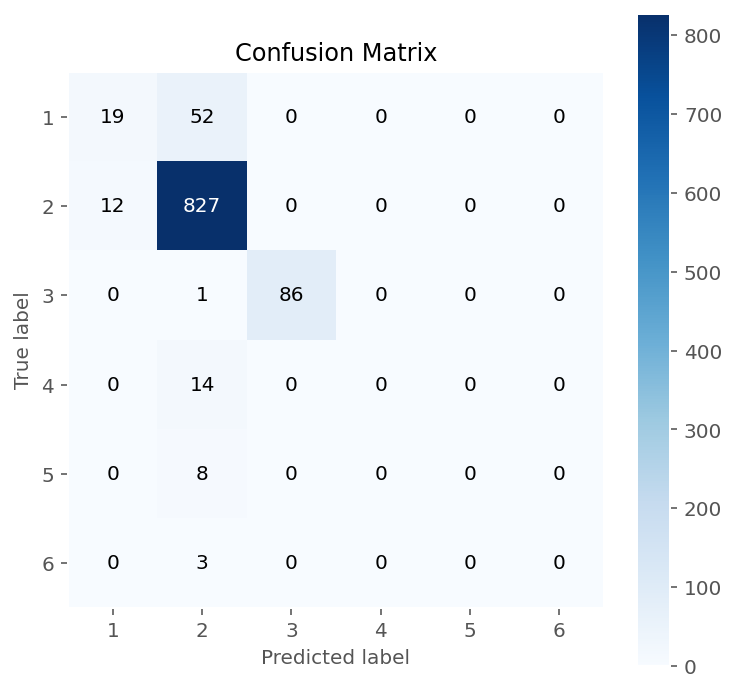

In [337]:
# let's evaluate the new model with a confusion matrix 
skplt.metrics.plot_confusion_matrix(y_ab_train, best_lra.predict(X_ab_train_std), figsize=(6, 6))
plt.show()

In [338]:
print(classification_report(y_ab_train, best_lra.predict(X_ab_train_std), zero_division=0))

              precision    recall  f1-score   support

           1       0.61      0.27      0.37        71
           2       0.91      0.99      0.95       839
           3       1.00      0.99      0.99        87
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3

    accuracy                           0.91      1022
   macro avg       0.42      0.37      0.39      1022
weighted avg       0.88      0.91      0.89      1022



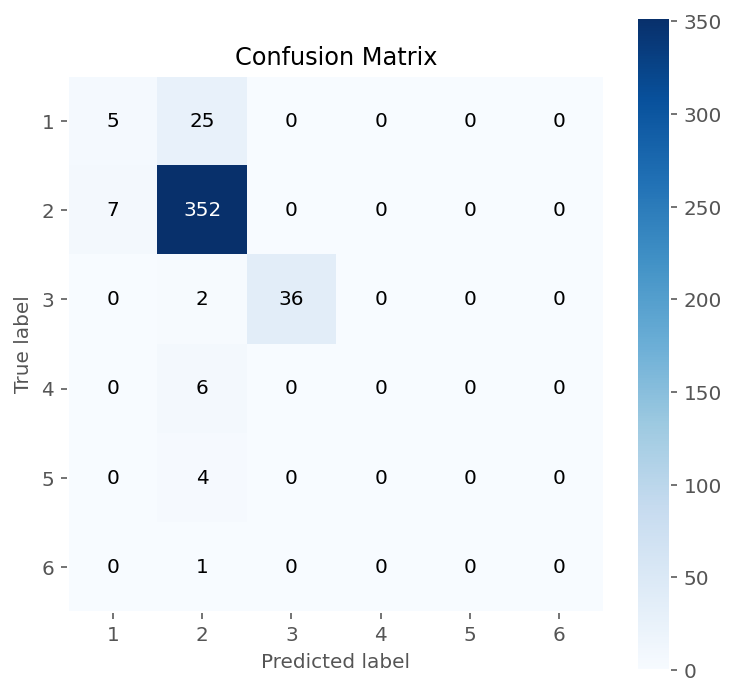

In [339]:
# test set 
skplt.metrics.plot_confusion_matrix(y_ab_test, best_lra.predict(X_ab_test_std), figsize=(6, 6))
plt.show()

In [340]:
print(classification_report(y_ab_test, best_lra.predict(X_ab_test_std), zero_division=0))

              precision    recall  f1-score   support

           1       0.42      0.17      0.24        30
           2       0.90      0.98      0.94       359
           3       1.00      0.95      0.97        38
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1

    accuracy                           0.90       438
   macro avg       0.39      0.35      0.36       438
weighted avg       0.86      0.90      0.87       438



In [341]:
# Here, the accuracy of the model on the test data is 0.90 which is an excellent score. But on the other hand, 
# the majority of f1 scores are zero which indicates that the model is performing poorly on the minority class.
# We can see that precision and recall are also 0 which makes sense as f1 is a balance of these two. 
# We can confirm this by also looking at the confusion matrices above.

In [342]:
best_lra.predict_proba(X_ab_test_std)[:10]

array([[0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.06624086, 0.04895375, 0.80108539, 0.03215467, 0.02778207,
        0.02378327],
       [0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.0707992 , 0.80908008, 0.03063955, 0.03436738, 0.02969388,
        0.0254199 ],
       [0.0710584 , 0.80838112, 0.03075172, 0.0344932 , 0.02980259,
        0.02551297]])

In [343]:
# The model is not predicting all categories, we can only see a very small % of sales from some of the classes
# this should have shown me earlier that there is a weight class imbalance and we will need to refine this 
# during the modelling.

In [344]:
# let's optimize class weights
weights_param = {'penalty': ['l1', 'l2'],
              'solver': ['liblinear'],
              'C': np.logspace(-3, 0, 50),
              'multi_class': ['ovr'],
              'class_weight': ['balanced']}

# create gridsearch object
weights_gs =     GridSearchCV(lra,
                              weights_param,
                              n_jobs=2,         
                              cv=2, 
                              verbose=1)
# fit to training data
weights_gs.fit(X_ab_train_std, y_ab_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


GridSearchCV(cv=2,
             estimator=LogisticRegression(max_iter=1000, multi_class='ovr'),
             n_jobs=2,
             param_grid={'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.0...
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
                         'class_weight': ['balanced'], 'multi_class': ['ovr'],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=1)

In [345]:
# get the best estimator for model and use on test data
best_weights = weights_gs.best_estimator_
print(best_weights)
print('Best test score from optimising the weights:', best_weights.score(X_ab_test_std, y_ab_test))

LogisticRegression(C=0.044984326689694466, class_weight='balanced',
                   max_iter=1000, multi_class='ovr', penalty='l1',
                   solver='liblinear')
Best test score from optimising the weights: 0.863013698630137


In [242]:
# so the accuracy score has decreased from the model above (0.8972602739726028), however we can now see that
# all classes have values, as below.

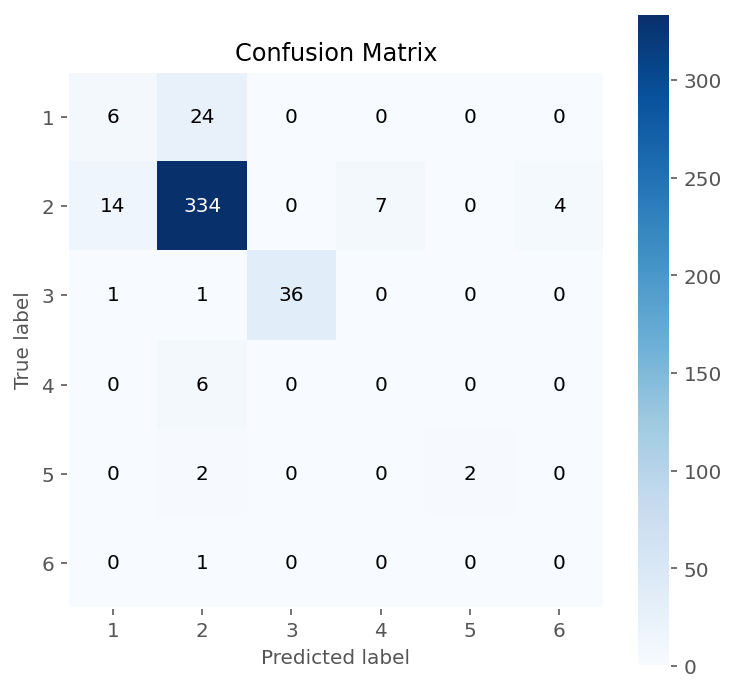

In [346]:
# refined class-weight model on test set 
skplt.metrics.plot_confusion_matrix(y_ab_test, best_weights.predict(X_ab_test_std), figsize=(6, 6))
plt.show()

In [ ]:
# now we can see predictions for all categories

In [347]:
# lets create a dataframe showing the magnitude of the coefficients for predicting column [0] 
# (equivilant of group 1 & abnormal sale)

df_coef_weights = pd.DataFrame({'feature': X_ab_test.columns,
                        'coef': weights_gs.best_estimator_.coef_[0],
                        'abs_coef': np.abs(weights_gs.best_estimator_.coef_[0])})

df_coef_weights.sort_values('coef', ascending=False, inplace=True)
df_coef_weights

feature      coef  abs_coef
711        SaleType_COD  0.532249  0.532249
697           PoolQC_Ex  0.183898  0.183898
612  GarageYrBlt_1946.0  0.141805  0.141805
718        SaleType_Oth  0.136814  0.136814
61        LandSlope_Sev  0.124438  0.124438
..                  ...       ...       ...
256    MasVnrArea_145.0  0.000000  0.000000
257    MasVnrArea_146.0  0.000000  0.000000
734      MSSubClass_190  0.000000  0.000000
574   GarageType_Attchd -0.042379  0.042379
33            SalePrice -0.093910  0.093910

[735 rows x 3 columns]

In [348]:
df_coef_weights.describe()

coef    abs_coef
count  735.000000  735.000000
mean     0.005097    0.005468
std      0.027887    0.027816
min     -0.093910    0.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      0.000000    0.000000
max      0.532249    0.532249

In [349]:
# lets look at the features with coefficients below the mean for our negative predictors
df_coef_weights[(df_coef_weights['coef'] < 0.005097)].tail()

feature      coef  abs_coef
256   MasVnrArea_145.0  0.000000  0.000000
257   MasVnrArea_146.0  0.000000  0.000000
734     MSSubClass_190  0.000000  0.000000
574  GarageType_Attchd -0.042379  0.042379
33           SalePrice -0.093910  0.093910

In [ ]:
# the bottom 2 here are GarageType_Attached and SalePrice
# meaning that these are the 2 worst predictors for finding 'abnormal' sales
# after these 2 there are alot of features with 0 coefficients

In [350]:
# now lets look at the features with coefficients above the mean for our positive predictors
df_coef_weights[(df_coef_weights['coef'] > 0.005097)].head()

feature      coef  abs_coef
711        SaleType_COD  0.532249  0.532249
697           PoolQC_Ex  0.183898  0.183898
612  GarageYrBlt_1946.0  0.141805  0.141805
718        SaleType_Oth  0.136814  0.136814
61        LandSlope_Sev  0.124438  0.124438

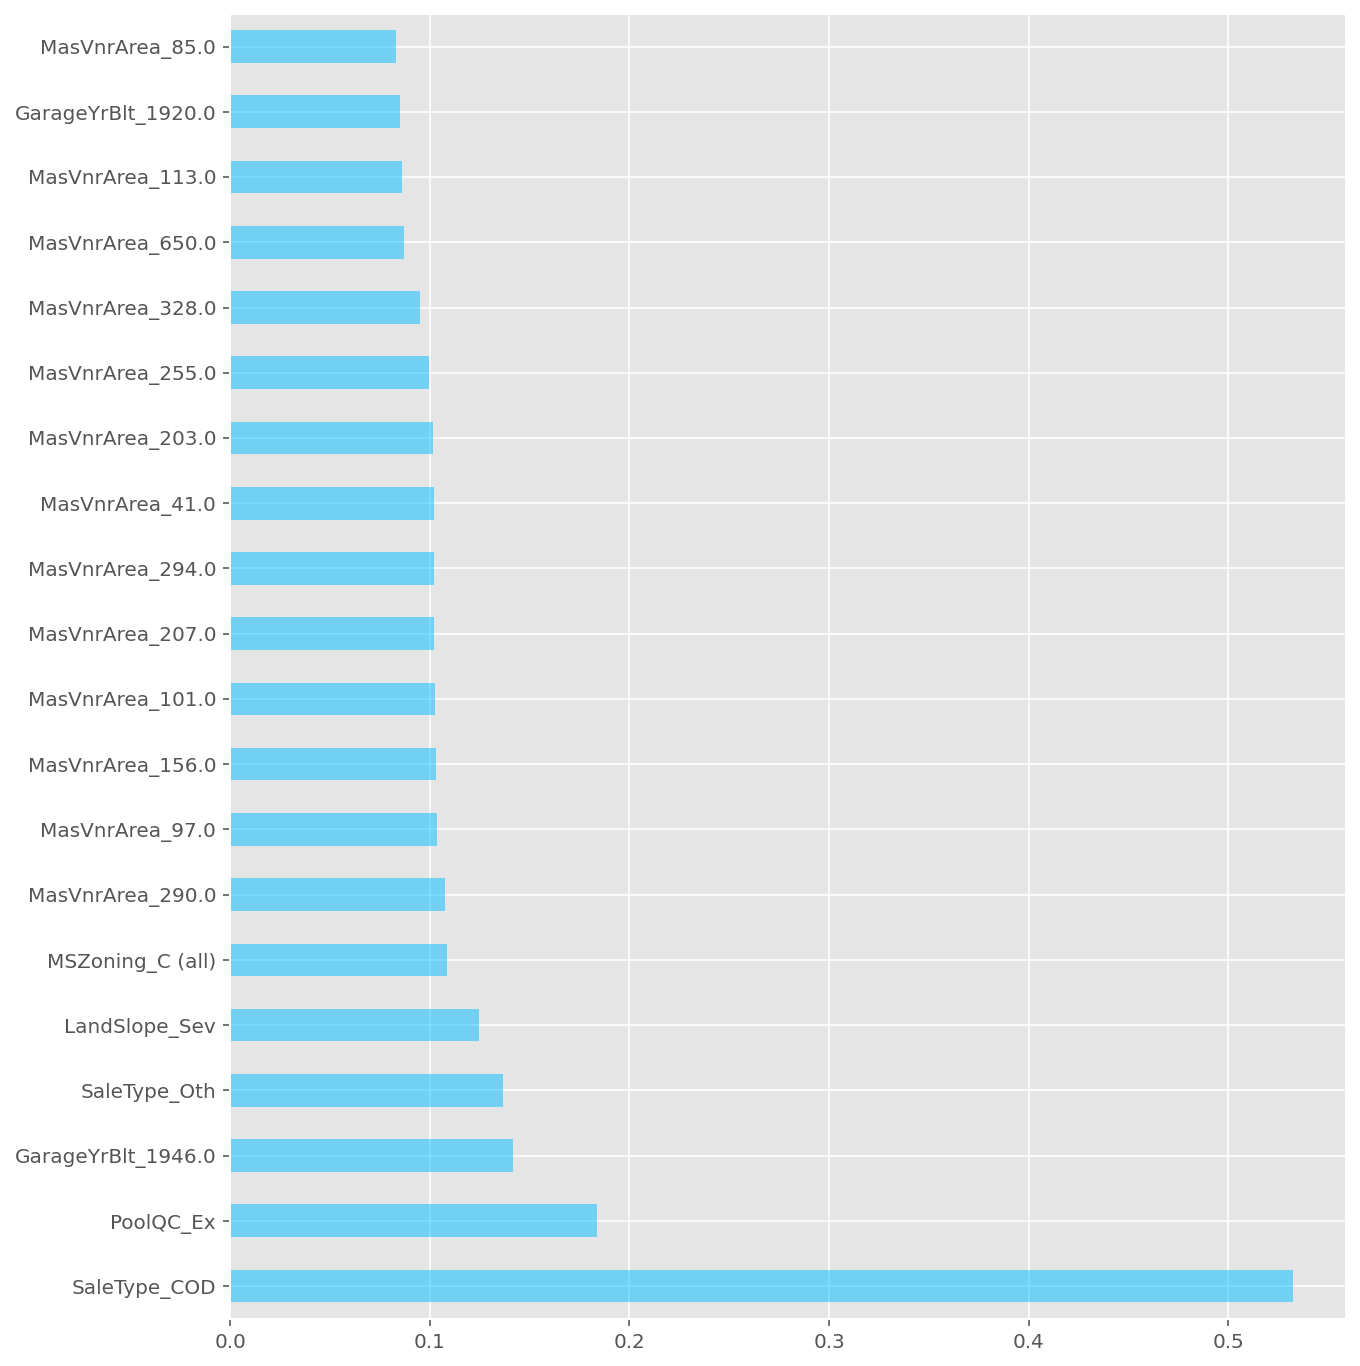

In [467]:
fig, ax = plt.subplots(figsize=(10, 12))
df_coef_weights.coef[:20].plot(kind='barh', ax=ax, alpha=0.5, sort_columns=True, color='deepskyblue')
ax.set_yticklabels(df_coef_weights.feature[:20].values)
plt.show()

In [ ]:
# the top 5 features for predicting an abnormal sale are:
# 1 - SaleType Court Officer Deed/Estate
# 2 - Pool Quality Excellent
# 3 - GarageYrBuilt in 1946
# 4 - SaleType Other
# 5 - LandSlope Severe

In [ ]:
# so in order to find a house that is a predicted foreclosure, trade or short sale we need a house where an 
# executor of an estate is transferring a title on behalf of an estate or conservatorship (potentially due to
# death in the family), that has a pool in excellent quality (perhaps expensive to maintain) / with a garage 
# built in 1946 (denoting an older property) / or a saletype of 'other' (not a normal sale type) with a 
# severe landslope.

In [ ]:
#######

In [ ]:
# in order to improve the predictions even further, we could look at the thresholds

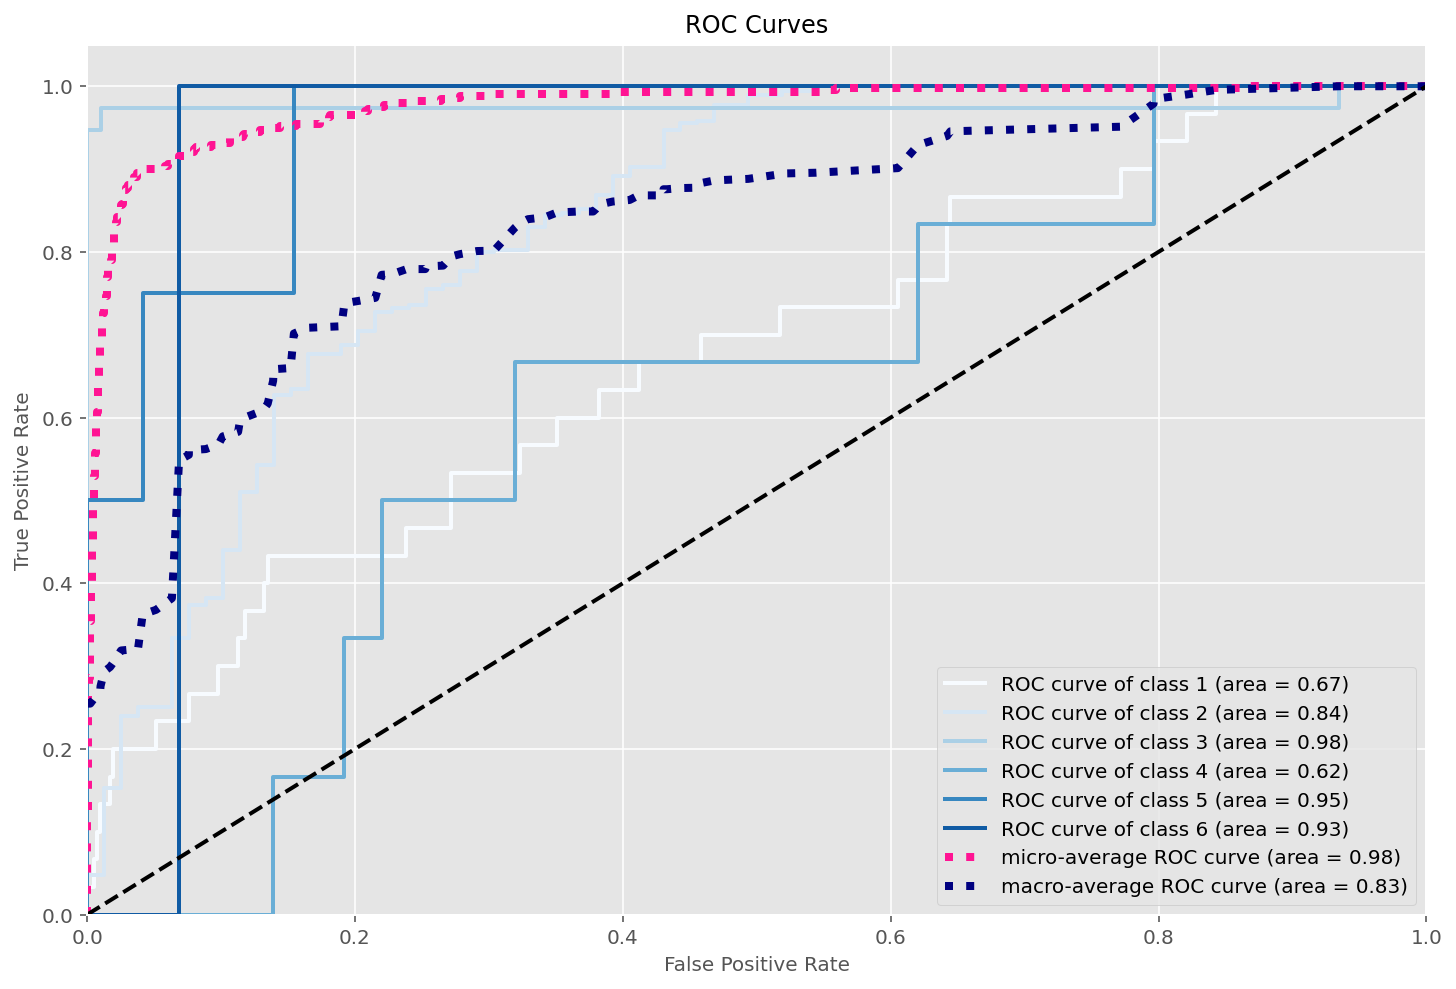

In [465]:
skplt.metrics.plot_roc(y_ab_test, best_weights.predict_proba(X_ab_test_std), cmap='Blues', figsize=(12,8))
plt.show()

In [ ]:
# we can see that due to the small size of the class (1 for abnormal sales) or roc curve is imbalanced.

In [353]:
# let's check the number of correct predictions vs a change in threshold (for 'abnormal' sales)

accuracies = []
for thresh in np.arange(1, 100)/100.:
    labeled_1 = np.array([1 if x >= thresh else 0 for x in best_weights.predict_proba(X_ab_test_std)[:, 0]])
    acc = np.mean(y_ab_test==labeled_1)
    accuracies.append((thresh, acc))
    print('Threshold:', thresh, 'Correct predictions:', acc)
accuracies = np.array(accuracies)

Threshold: 0.01 Correct predictions: 0.0684931506849315
Threshold: 0.02 Correct predictions: 0.0684931506849315
Threshold: 0.03 Correct predictions: 0.0684931506849315
Threshold: 0.04 Correct predictions: 0.0684931506849315
Threshold: 0.05 Correct predictions: 0.0684931506849315
Threshold: 0.06 Correct predictions: 0.0684931506849315
Threshold: 0.07 Correct predictions: 0.0684931506849315
Threshold: 0.08 Correct predictions: 0.0684931506849315
Threshold: 0.09 Correct predictions: 0.06621004566210045
Threshold: 0.1 Correct predictions: 0.0593607305936073
Threshold: 0.11 Correct predictions: 0.04794520547945205
Threshold: 0.12 Correct predictions: 0.03881278538812785
Threshold: 0.13 Correct predictions: 0.0319634703196347
Threshold: 0.14 Correct predictions: 0.02968036529680365
Threshold: 0.15 Correct predictions: 0.02968036529680365
Threshold: 0.16 Correct predictions: 0.02968036529680365
Threshold: 0.17 Correct predictions: 0.02968036529680365
Threshold: 0.18 Correct predictions: 0.025

In [ ]:
# we can see that around a threshold of 0.08 the correct predictions are at the highest 

In [354]:
def predict_at_threshold(x, threshold=0.08):
    if x >= threshold:
        return 1
    else:
        return 0

In [355]:
# if we apply the change in threshold to 0.08 to the abnormal sales column we can see the change in numbers below
y_ab_prob = pd.DataFrame(best_weights.predict_proba(X_ab_test_std), columns = ['Abnorml', 'Normal', 'Partial', 'Family', 'Alloca', 'AdjLand'])
y_ab_prob

Abnorml    Normal   Partial    Family    Alloca   AdjLand
0    0.094119  0.764558  0.039246  0.045828  0.030374  0.025875
1    0.114984  0.712935  0.036596  0.031154  0.075627  0.028703
2    0.121692  0.749329  0.038465  0.035386  0.029769  0.025359
3    0.110445  0.766302  0.039336  0.027540  0.030443  0.025934
4    0.120423  0.733353  0.037645  0.054627  0.029134  0.024819
5    0.067890  0.042696  0.812716  0.040342  0.019632  0.016724
6    0.185639  0.683301  0.035075  0.041329  0.027146  0.027510
7    0.177289  0.699742  0.035919  0.035570  0.027799  0.023681
8    0.124710  0.749810  0.038489  0.031827  0.029788  0.025376
9    0.146953  0.728814  0.037412  0.033203  0.028954  0.024665
10   0.100854  0.670815  0.034434  0.126105  0.029511  0.038281
11   0.183482  0.163923  0.031581  0.575753  0.024441  0.020821
12   0.112471  0.755348  0.038774  0.037837  0.030008  0.025563
13   0.123153  0.745616  0.038274  0.038103  0.029621  0.025234
14   0.147275  0.694775  0.035664  0.069281  0.027601  0.025404
15   0.088176  0.778207  0.039947  0.036417  0.030916  0.026337
16   0.109434  0.759073  0.038965  0.036684  0.030156  0.025689
17   0.067540  0.042728  0.813334  0.040014  0.019647  0.016737
18   0.119505  0.735641  0.037762  0.052971  0.029225  0.024896
19   0.055426  0.342953  0.017604  0.558785  0.013625  0.011606
20   0.108440  0.753807  0.038694  0.043601  0.029947  0.025511
21   0.153965  0.606340  0.031125  0.036344  0.151706  0.020520
22   0.215426  0.277007  0.014219  0.028361  0.029384  0.435603
23   0.069737  0.042771  0.814145  0.036928  0.019666  0.016753
24   0.172536  0.696372  0.035746  0.044114  0.027665  0.023567
25   0.132483  0.658756  0.033815  0.076814  0.026170  0.071962
26   0.105680  0.752273  0.038616  0.048086  0.029886  0.025459
27   0.099922  0.765545  0.039297  0.038915  0.030413  0.025908
28   0.117723  0.750405  0.038520  0.038145  0.029811  0.025396
29   0.450784  0.460113  0.023619  0.031634  0.018279  0.015571
30   0.068943  0.042664  0.812110  0.039954  0.019617  0.016711
31   0.105996  0.707390  0.036312  0.098259  0.028103  0.023940
32   0.106449  0.730067  0.037476  0.072296  0.029003  0.024707
33   0.104649  0.716466  0.036778  0.083205  0.034655  0.024247
34   0.705206  0.158770  0.030588  0.061596  0.023673  0.020166
35   0.114503  0.745211  0.038253  0.047208  0.029605  0.025220
36   0.213992  0.559804  0.028736  0.043729  0.131201  0.022538
37   0.080103  0.489736  0.025139  0.368992  0.019456  0.016574
38   0.063137  0.043059  0.819629  0.037510  0.019799  0.016866
39   0.098903  0.766110  0.039326  0.039298  0.030435  0.025927
40   0.106638  0.569785  0.029248  0.250859  0.022636  0.020833
41   0.232604  0.449683  0.086634  0.106914  0.067048  0.057117
42   0.102148  0.755244  0.038768  0.048276  0.030004  0.025560
43   0.114777  0.695659  0.035710  0.102675  0.027637  0.023543
44   0.501194  0.419978  0.021558  0.026372  0.016685  0.014213
45   0.301618  0.559466  0.028719  0.067516  0.022226  0.020456
46   0.211125  0.677750  0.034790  0.026473  0.026925  0.022937
47   0.056635  0.044113  0.839698  0.021991  0.020283  0.017279
48   0.137952  0.625913  0.032129  0.036204  0.024866  0.142936
49   0.071364  0.043019  0.818871  0.030115  0.019780  0.016850
50   0.070093  0.042611  0.811107  0.039905  0.019593  0.016691
51   0.145435  0.725532  0.037243  0.031417  0.028823  0.031549
52   0.077646  0.042838  0.815420  0.027620  0.019697  0.016779
53   0.105394  0.752514  0.038628  0.048102  0.029895  0.025467
54   0.140133  0.723534  0.037141  0.043993  0.028744  0.026455
55   0.088390  0.623716  0.032017  0.209990  0.024778  0.021108
56   0.148910  0.717819  0.036847  0.041660  0.028517  0.026246
57   0.102452  0.751995  0.038601  0.051627  0.029875  0.025450
58   0.083561  0.511251  0.026244  0.039936  0.321706  0.017302
59   0.069187  0.043054  0.819531  0.031567  0.019796  0.016864
60   0.281423  0.530355  0.027224  0.090607  0.049039  0.021353
61   0.121477  0.728135  0.037377  0.0

In [356]:
y_ab_prob['threshold at 0.08'] = y_ab_prob.Abnorml.apply(predict_at_threshold, 
                                                threshold=0.08)
y_ab_prob
print('1s predicted at 0.08 threshold:\n', y_ab_prob['threshold at 0.08'].value_counts(normalize=True))

1s predicted at 0.08 threshold:
 1    0.881279
0    0.118721
Name: threshold at 0.08, dtype: float64


In [ ]:
# Now we can see the abnormal sales are predicted 88% of the time, which again is a decrease on accuracy
# from the optimised model with no weight class optimization, but it yields a fairer balance, and it
# is a higher score than baseline.

In [ ]:
# Moving forward I would research into tools that can help when in comes to imbalances in the dataset, 
# potentially using SMOTE or a resampling tool.